# Models 

This notebook contains the examples of attempted models and approaches employed towards finding solution to the ACMG classification problem. This particular version is concerned with custom parsing - related notebook EDA - Custom Parsing

## Imports

In [14]:
from utils.EDA_utils import *
from utils.utils import get_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import dalex as dx
from sklearn.model_selection import LeaveOneOut
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [15]:
EE15 = get_dataset("data/", samples=["EE_015"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)
EE50 = get_dataset("data/", samples=["EE_050"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)
EE69 = get_dataset("data/", samples=["EE_069"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)

EE15['patient'] = 'EE15'
EE50['patient'] = 'EE50'
EE69['patient'] = 'EE69'

target_column = "ACMG_class"
df = pd.concat([EE15, EE50, EE69])

In [32]:
df.head()

#CHROM     POS REF ALT QUAL  FILTER_germline  FILTER_fragment  \
0   chr1   15820   G   T    .              0.0              0.0   
1   chr1   17385   G   A    .              0.0              0.0   
2   chr1   17697   G   C    .              0.0              0.0   
3   chr1  133129   G   A    .              0.0              0.0   
4   chr1  183629   G   A    .              0.0              0.0   

   FILTER_haplotype  FILTER_clustered_events  FILTER_slippage  ...  SIFT_pred  \
0               0.0                      0.0              0.0  ...        NaN   
1               0.0                      0.0              0.0  ...        NaN   
2               0.0                      0.0              0.0  ...        NaN   
3               0.0                      0.0              0.0  ...        NaN   
4               0.0                      0.0              0.0  ...        NaN   

   PolyPhen_class PolyPhen_pred  patient  FILTER_strand_bias  \
0             NaN           NaN     EE15                 NaN   
1             NaN           NaN     EE15                 NaN   
2             NaN           NaN     EE15                 NaN   
3             NaN           NaN     EE15                 NaN   
4             NaN           NaN     EE15                 NaN   

   FILTER_base_qual  FILTER_map_qual  FILTER_weak_evidence  \
0               NaN              NaN                   NaN   
1               NaN              NaN                   NaN   
2               NaN              NaN                   NaN   
3               NaN              NaN                   NaN   
4               NaN              NaN                   NaN   

   Existing_variation_BM  Existing_variation_HM  
0                    NaN                    NaN  
1                    NaN                    NaN  
2                    NaN                    NaN  
3                    NaN                    NaN  
4                    NaN                    NaN  

[5 rows x 117 columns]

In [17]:
custom_mapping = {
    'Benign': 0,
    'Likely%40Benign': 1,
    'Uncertain%40Significance': 2,
    'Likely%40Pathogenic': 3,
    'Pathogenic': 4
}

target_column = "ACMG_class"


df = df.loc[:, ~df.columns.duplicated()]
preprocessed_df1 = preprocess(df)
preprocessed_df2 = preprocess(df, fill_median=True)
preprocessed_df3 = preprocess(df, one_hot_nans = False)

encoded_df1, encoders1, target_mapping1 = encode(preprocessed_df1, target_column, custom_mapping)
encoded_df2, encoders2, target_mapping2 = encode(preprocessed_df2, target_column, custom_mapping)
encoded_df3, encoders3, target_mapping3 = encode(preprocessed_df3, target_column, custom_mapping)

In [18]:
encoded_df1.head()

#CHROM     POS   REF   ALT  QUAL  FILTER_germline  FILTER_fragment  \
0       0   15820  1773  2117     0              0.0              0.0   
1       0   17385  1773     0     0              0.0              0.0   
2       0   17697  1773   721     0              0.0              0.0   
3       0  133129  1773     0     0              0.0              0.0   
4       0  183629  1773     0     0              0.0              0.0   

   FILTER_haplotype  FILTER_clustered_events  FILTER_slippage  ...  \
0               0.0                      0.0              0.0  ...   
1               0.0                      0.0              0.0  ...   
2               0.0                      0.0              0.0  ...   
3               0.0                      0.0              0.0  ...   
4               0.0                      0.0              0.0  ...   

   SIFT_class_is_nan  SIFT_pred_is_nan  PolyPhen_class_is_nan  \
0                  1                 1                      1   
1                  1                 1                      1   
2                  1                 1                      1   
3                  1                 1                      1   
4                  1                 1                      1   

   PolyPhen_pred_is_nan  FILTER_strand_bias_is_nan  FILTER_base_qual_is_nan  \
0                     1                          1                        1   
1                     1                          1                        1   
2                     1                          1                        1   
3                     1                          1                        1   
4                     1                          1                        1   

   FILTER_map_qual_is_nan  FILTER_weak_evidence_is_nan  \
0                       1                            1   
1                       1                            1   
2                       1                            1   
3                       1                            1   
4                       1                            1   

   Existing_variation_BM_is_nan  Existing_variation_HM_is_nan  
0                             1                             1  
1                             1                             1  
2                             1                             1  
3                             1                             1  
4                             1                             1  

[5 rows x 185 columns]

In [19]:
encoded_df2.head()

#CHROM     POS   REF   ALT  QUAL  FILTER_germline  FILTER_fragment  \
0       0   15820  1773  2117     0              0.0              0.0   
1       0   17385  1773     0     0              0.0              0.0   
2       0   17697  1773   721     0              0.0              0.0   
3       0  133129  1773     0     0              0.0              0.0   
4       0  183629  1773     0     0              0.0              0.0   

   FILTER_haplotype  FILTER_clustered_events  FILTER_slippage  ...  \
0               0.0                      0.0              0.0  ...   
1               0.0                      0.0              0.0  ...   
2               0.0                      0.0              0.0  ...   
3               0.0                      0.0              0.0  ...   
4               0.0                      0.0              0.0  ...   

   SIFT_class_is_nan  SIFT_pred_is_nan  PolyPhen_class_is_nan  \
0                  1                 1                      1   
1                  1                 1                      1   
2                  1                 1                      1   
3                  1                 1                      1   
4                  1                 1                      1   

   PolyPhen_pred_is_nan  FILTER_strand_bias_is_nan  FILTER_base_qual_is_nan  \
0                     1                          1                        1   
1                     1                          1                        1   
2                     1                          1                        1   
3                     1                          1                        1   
4                     1                          1                        1   

   FILTER_map_qual_is_nan  FILTER_weak_evidence_is_nan  \
0                       1                            1   
1                       1                            1   
2                       1                            1   
3                       1                            1   
4                       1                            1   

   Existing_variation_BM_is_nan  Existing_variation_HM_is_nan  
0                             1                             1  
1                             1                             1  
2                             1                             1  
3                             1                             1  
4                             1                             1  

[5 rows x 185 columns]

In [20]:
encoded_df3.head()

#CHROM     POS   REF   ALT  QUAL  FILTER_germline  FILTER_fragment  \
0       0   15820  1773  2117     0              0.0              0.0   
1       0   17385  1773     0     0              0.0              0.0   
2       0   17697  1773   721     0              0.0              0.0   
3       0  133129  1773     0     0              0.0              0.0   
4       0  183629  1773     0     0              0.0              0.0   

   FILTER_haplotype  FILTER_clustered_events  FILTER_slippage  ...  SIFT_pred  \
0               0.0                      0.0              0.0  ...       -1.0   
1               0.0                      0.0              0.0  ...       -1.0   
2               0.0                      0.0              0.0  ...       -1.0   
3               0.0                      0.0              0.0  ...       -1.0   
4               0.0                      0.0              0.0  ...       -1.0   

   PolyPhen_class  PolyPhen_pred  patient  FILTER_strand_bias  \
0               0           -1.0        0                -1.0   
1               0           -1.0        0                -1.0   
2               0           -1.0        0                -1.0   
3               0           -1.0        0                -1.0   
4               0           -1.0        0                -1.0   

   FILTER_base_qual  FILTER_map_qual  FILTER_weak_evidence  \
0              -1.0             -1.0                  -1.0   
1              -1.0             -1.0                  -1.0   
2              -1.0             -1.0                  -1.0   
3              -1.0             -1.0                  -1.0   
4              -1.0             -1.0                  -1.0   

   Existing_variation_BM  Existing_variation_HM  
0                   -1.0                   -1.0  
1                   -1.0                   -1.0  
2                   -1.0                   -1.0  
3                   -1.0                   -1.0  
4                   -1.0                   -1.0  

[5 rows x 117 columns]

## Model Training

In [21]:
def invert_dict(original_dict):
    inverted_dict = {v: k for k, v in original_dict.items()}
    return inverted_dict

In [22]:
inverted_mapping = invert_dict(target_mapping1)

Example model training

In [23]:
X = encoded_df1.drop(columns=['ACMG_class'])
y = encoded_df1['ACMG_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
clf = RandomForestClassifier(class_weight=dict(enumerate(class_weights)))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.81      0.69      0.75      5151
           2       0.89      0.64      0.74      6781
           3       0.80      0.16      0.27        25
           4       0.50      0.10      0.17        10

    accuracy                           0.95     88889
   macro avg       0.79      0.52      0.58     88889
weighted avg       0.95      0.95      0.95     88889



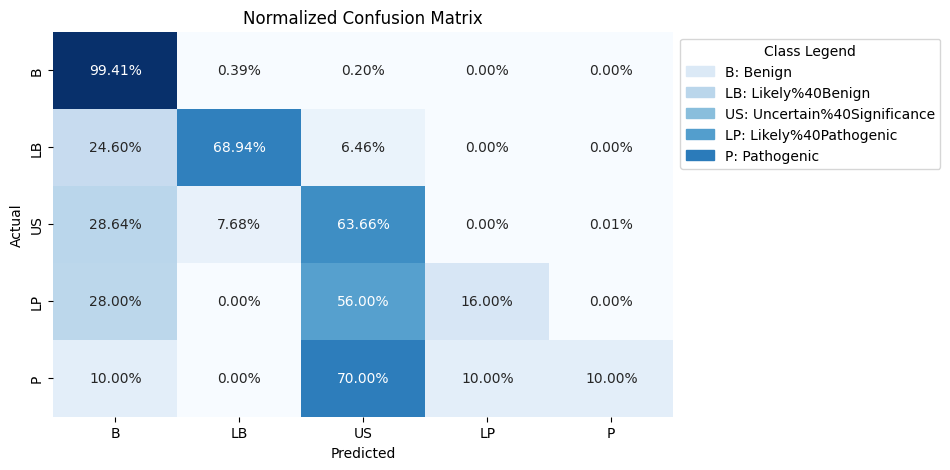

In [24]:
get_confusion_matrix_plot(y_test, y_pred, inverted_mapping)

In [25]:
encoded_df1 = encoded_df1.drop_duplicates()
encoded_df2 = encoded_df2.drop_duplicates()
encoded_df3 = encoded_df3.drop_duplicates()

### Pipeline for Trying multiple different models in sklearn

This pipeline compares the performance of different models implemented in sklearn: Random Forrest, AdaBoost, Decision Tree, Logistic Regression, Bagging.
The results are shown in the form of a confusion matrix. The most promissing model appears to be AdaBoost.
Good performance on majority class is often balanced by bad performance minority class and vice-verse, as such ensamble models might be a good idea.

Classification report for Random Forest with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     29391
           1       0.80      0.71      0.75      2308
           2       0.89      0.62      0.73      2480
           3       1.00      0.64      0.78        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.73      0.59      0.65     34193
weighted avg       0.94      0.95      0.94     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


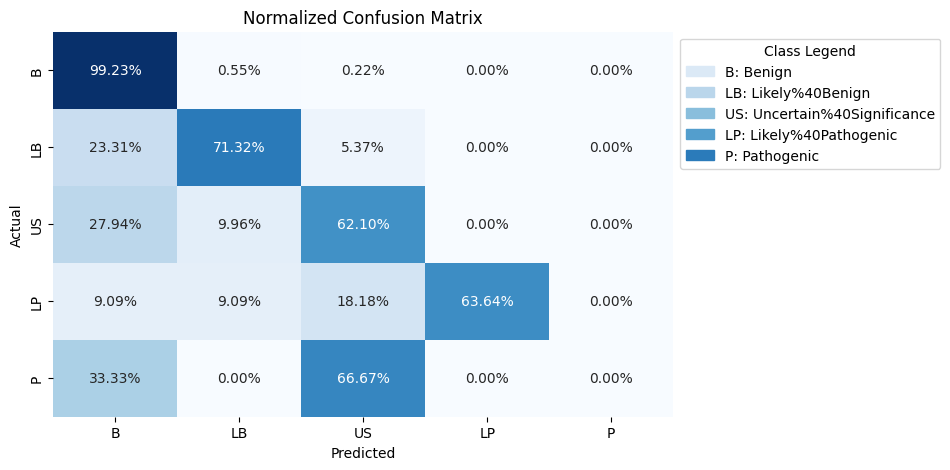

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.54      0.69     29391
           1       0.09      0.60      0.16      2308
           2       0.19      0.17      0.18      2480
           3       0.05      0.82      0.09        11
           4       0.20      0.33      0.25         3

    accuracy                           0.52     34193
   macro avg       0.30      0.49      0.27     34193
weighted avg       0.85      0.52      0.62     34193



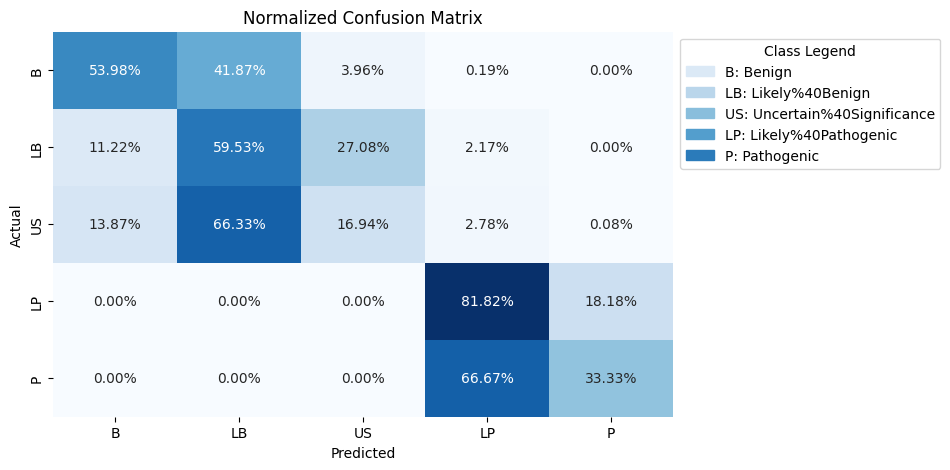

Classification report for Bagging with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29391
           1       0.76      0.75      0.75      2308
           2       0.83      0.67      0.74      2480
           3       0.67      0.36      0.47        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.65      0.55      0.59     34193
weighted avg       0.94      0.95      0.95     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


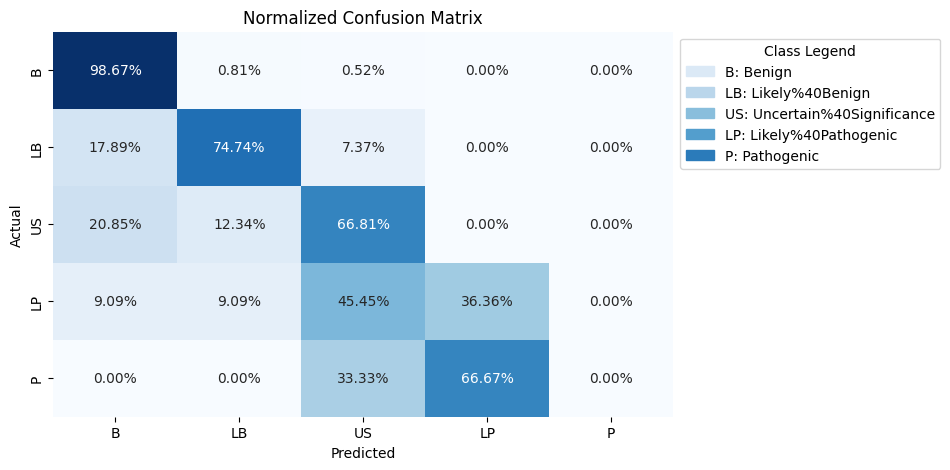

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29391
           1       0.66      0.66      0.66      2308
           2       0.64      0.66      0.65      2480
           3       0.67      0.73      0.70        11
           4       0.25      0.33      0.29         3

    accuracy                           0.92     34193
   macro avg       0.64      0.67      0.65     34193
weighted avg       0.92      0.92      0.92     34193



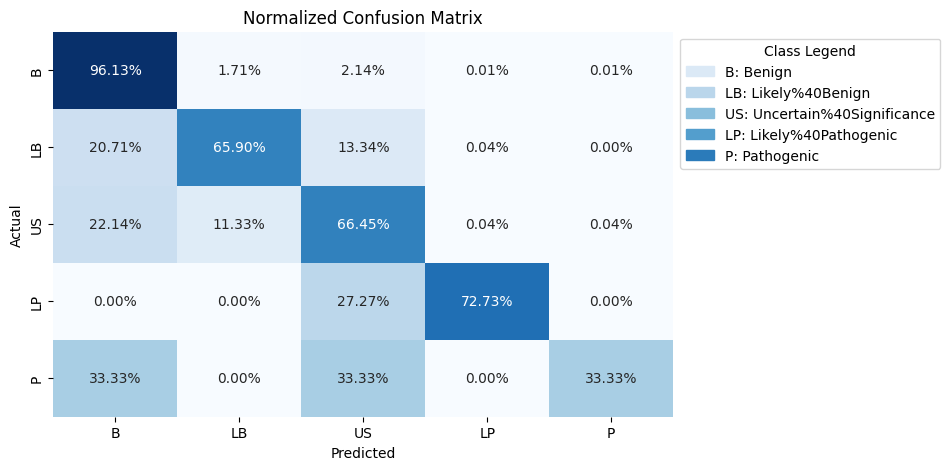

Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.87      0.45      0.59     29391
           1       0.00      0.00      0.00      2308
           2       0.00      0.00      0.00      2480
           3       0.00      0.82      0.00        11
           4       0.00      0.00      0.00         3

    accuracy                           0.38     34193
   macro avg       0.17      0.25      0.12     34193
weighted avg       0.75      0.38      0.51     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


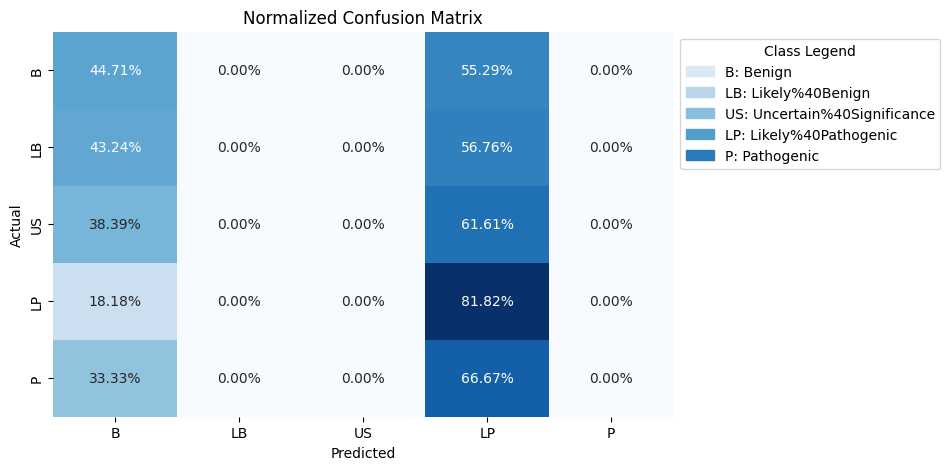

Classification report for Random Forest with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     29391
           1       0.81      0.71      0.76      2308
           2       0.89      0.62      0.73      2480
           3       1.00      0.36      0.53        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.73      0.54      0.60     34193
weighted avg       0.94      0.95      0.94     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


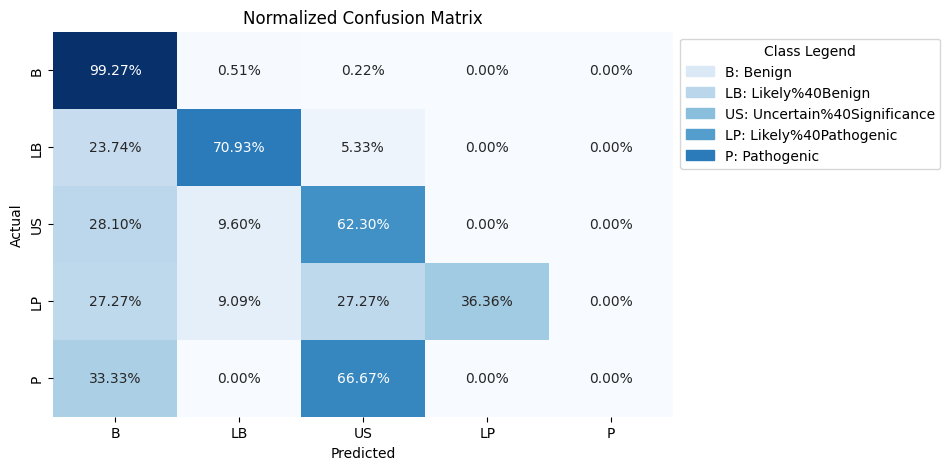

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.33      0.49     29391
           1       0.09      0.81      0.16      2308
           2       0.13      0.15      0.14      2480
           3       0.05      0.73      0.09        11
           4       1.00      0.33      0.50         3

    accuracy                           0.35     34193
   macro avg       0.45      0.47      0.28     34193
weighted avg       0.84      0.35      0.44     34193



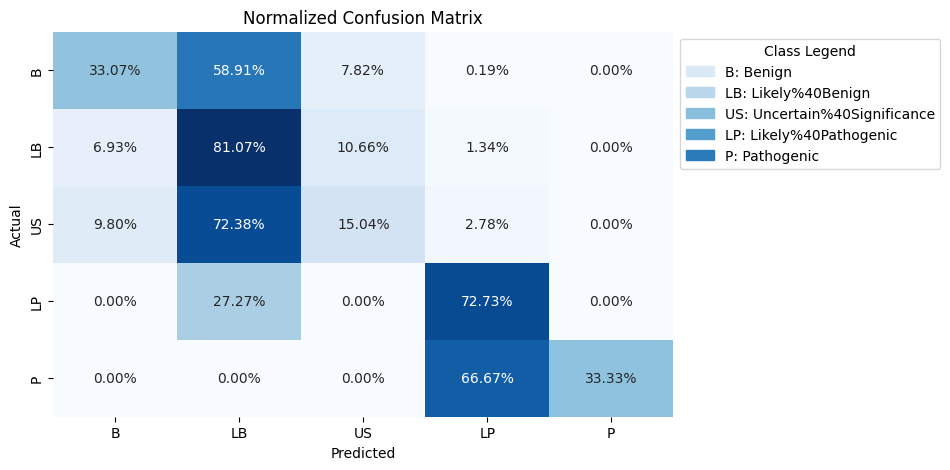

Classification report for Bagging with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29391
           1       0.76      0.74      0.75      2308
           2       0.83      0.66      0.73      2480
           3       0.25      0.09      0.13        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.56      0.50      0.52     34193
weighted avg       0.94      0.95      0.94     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


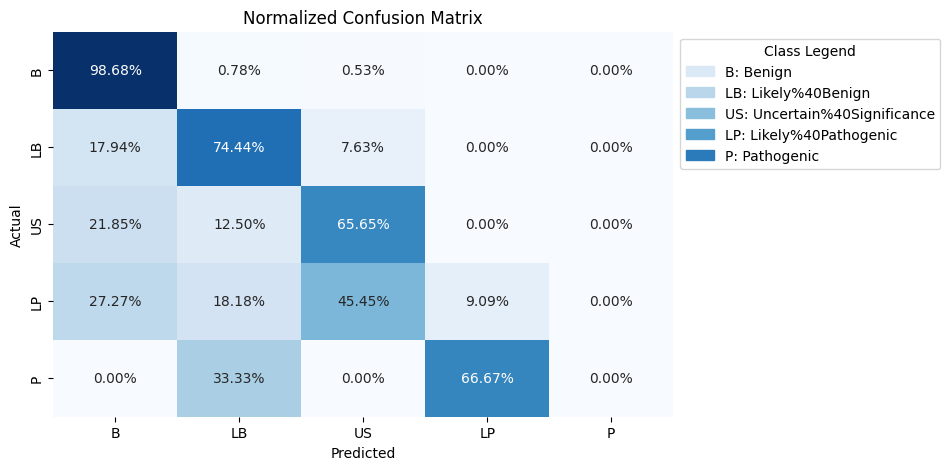

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29391
           1       0.66      0.67      0.67      2308
           2       0.65      0.66      0.65      2480
           3       0.42      0.73      0.53        11
           4       0.00      0.00      0.00         3

    accuracy                           0.92     34193
   macro avg       0.54      0.60      0.56     34193
weighted avg       0.92      0.92      0.92     34193



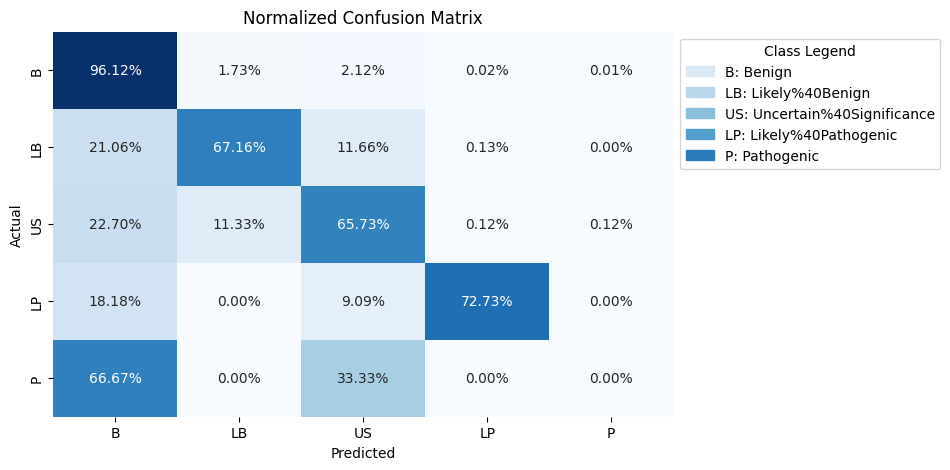

Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.91      0.44      0.59     29391
           1       0.10      0.51      0.17      2308
           2       0.00      0.00      0.00      2480
           3       0.00      0.27      0.00        11
           4       0.00      0.00      0.00         3

    accuracy                           0.41     34193
   macro avg       0.20      0.25      0.15     34193
weighted avg       0.79      0.41      0.52     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


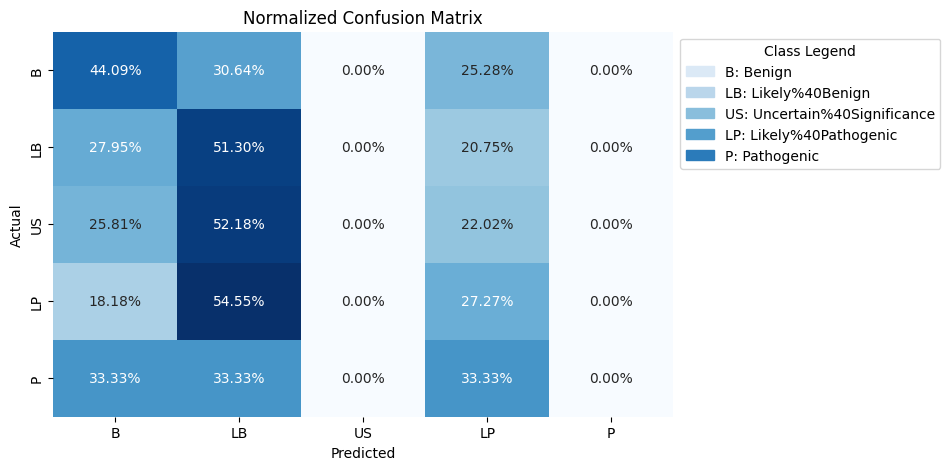

Classification report for Random Forest with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     29391
           1       0.80      0.73      0.76      2308
           2       0.89      0.63      0.74      2480
           3       1.00      0.45      0.62        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.73      0.56      0.62     34193
weighted avg       0.95      0.95      0.94     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


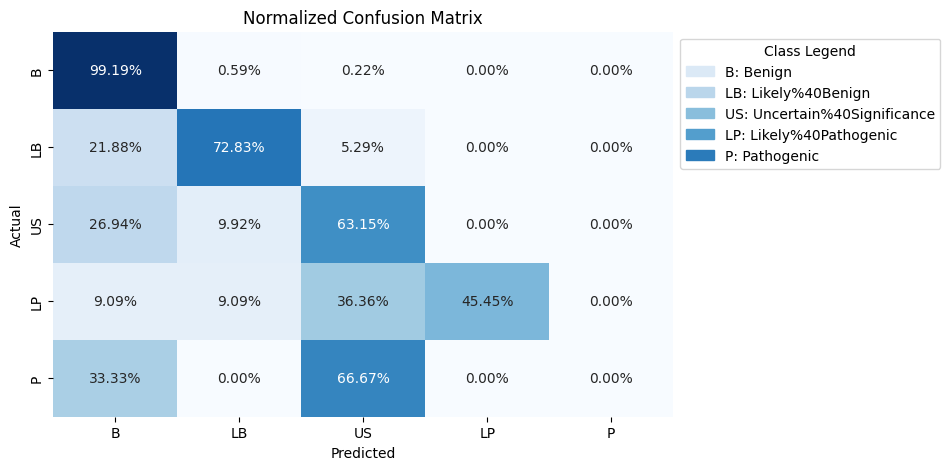

Classification report for AdaBoost with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.54      0.69     29391
           1       0.09      0.60      0.16      2308
           2       0.19      0.17      0.18      2480
           3       0.05      0.82      0.09        11
           4       0.20      0.33      0.25         3

    accuracy                           0.52     34193
   macro avg       0.30      0.49      0.27     34193
weighted avg       0.85      0.52      0.62     34193



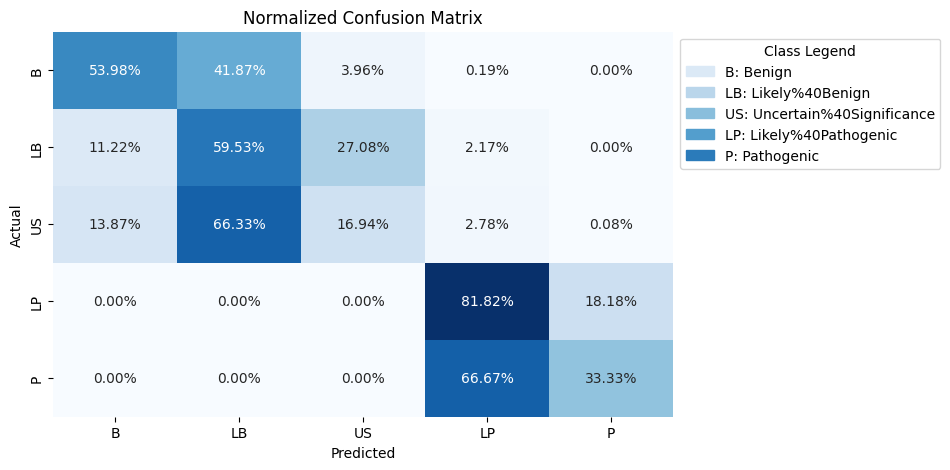

Classification report for Bagging with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29391
           1       0.76      0.74      0.75      2308
           2       0.83      0.66      0.74      2480
           3       0.50      0.18      0.27        11
           4       1.00      0.33      0.50         3

    accuracy                           0.95     34193
   macro avg       0.81      0.58      0.65     34193
weighted avg       0.94      0.95      0.94     34193



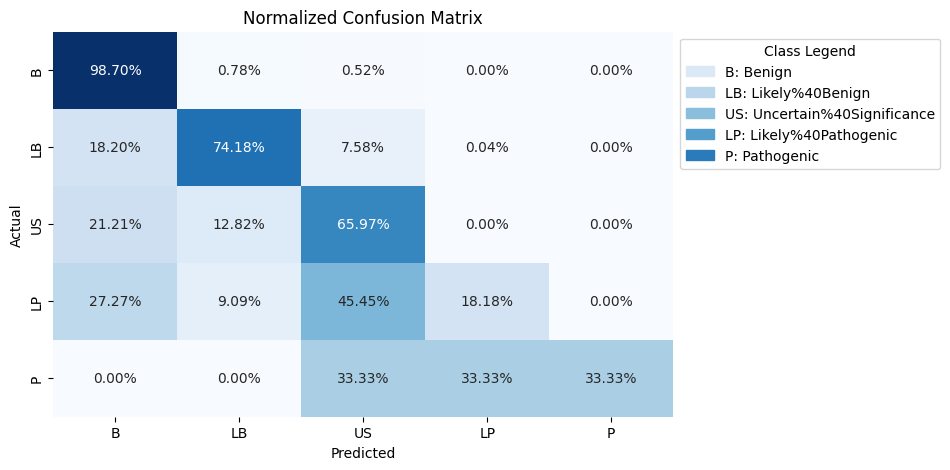

Classification report for Decision Tree with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29391
           1       0.66      0.65      0.65      2308
           2       0.63      0.66      0.65      2480
           3       0.62      0.73      0.67        11
           4       0.33      0.33      0.33         3

    accuracy                           0.92     34193
   macro avg       0.64      0.67      0.65     34193
weighted avg       0.92      0.92      0.92     34193



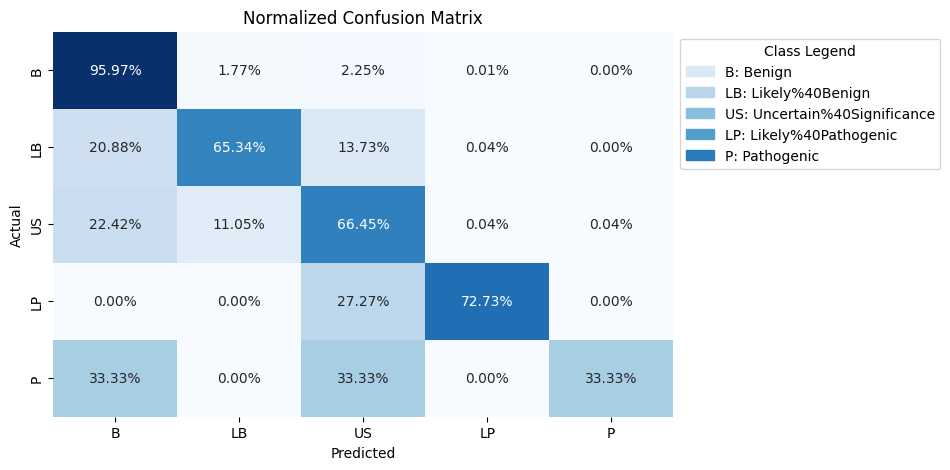

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Logistic Regression with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.87      0.45      0.59     29391
           1       0.00      0.00      0.00      2308
           2       0.00      0.00      0.00      2480
           3       0.00      0.82      0.00        11
           4       0.00      0.00      0.00         3

    accuracy                           0.38     34193
   macro avg       0.17      0.25      0.12     34193
weighted avg       0.75      0.38      0.51     34193



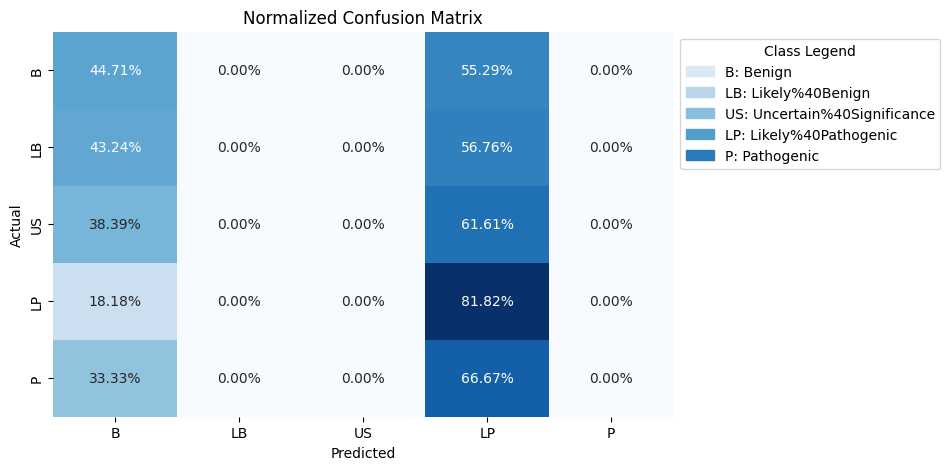

Classification report for Random Forest with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     29391
           1       0.80      0.72      0.76      2308
           2       0.89      0.62      0.73      2480
           3       1.00      0.73      0.84        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.73      0.61      0.66     34193
weighted avg       0.94      0.95      0.94     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


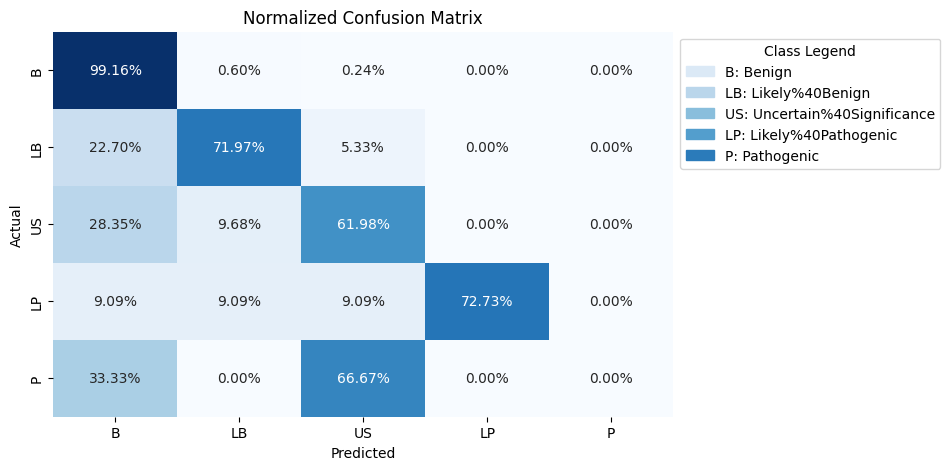

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.54      0.69     29391
           1       0.09      0.60      0.16      2308
           2       0.19      0.17      0.18      2480
           3       0.05      0.82      0.09        11
           4       0.20      0.33      0.25         3

    accuracy                           0.52     34193
   macro avg       0.30      0.49      0.27     34193
weighted avg       0.85      0.52      0.62     34193



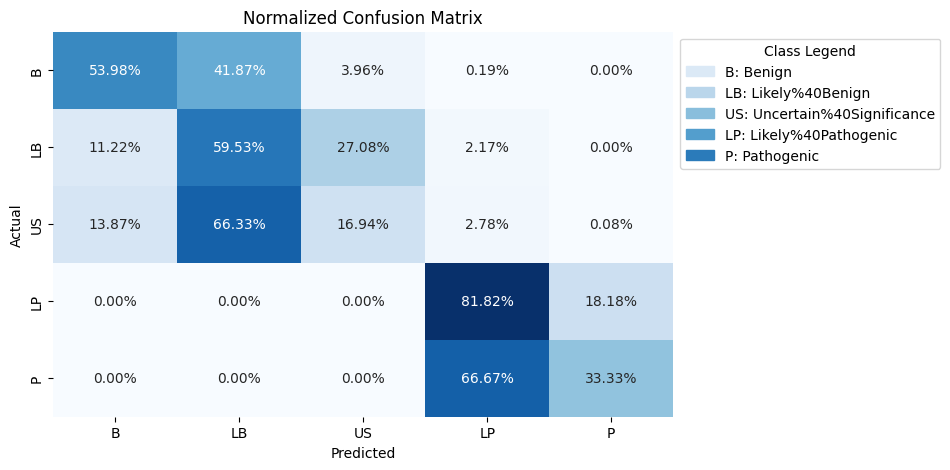

Classification report for Bagging with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29391
           1       0.76      0.74      0.75      2308
           2       0.83      0.67      0.74      2480
           3       0.83      0.45      0.59        11
           4       1.00      0.33      0.50         3

    accuracy                           0.95     34193
   macro avg       0.88      0.64      0.71     34193
weighted avg       0.94      0.95      0.94     34193



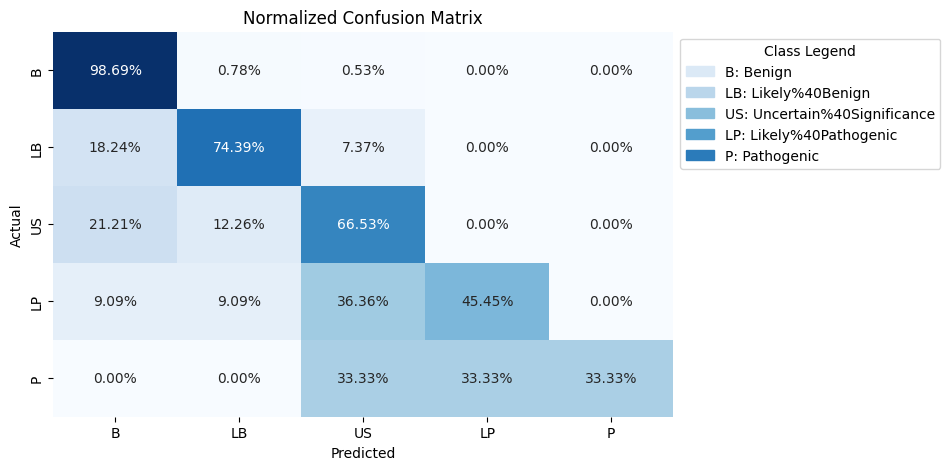

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29391
           1       0.65      0.66      0.65      2308
           2       0.63      0.66      0.64      2480
           3       0.73      0.73      0.73        11
           4       0.25      0.33      0.29         3

    accuracy                           0.92     34193
   macro avg       0.64      0.67      0.65     34193
weighted avg       0.92      0.92      0.92     34193



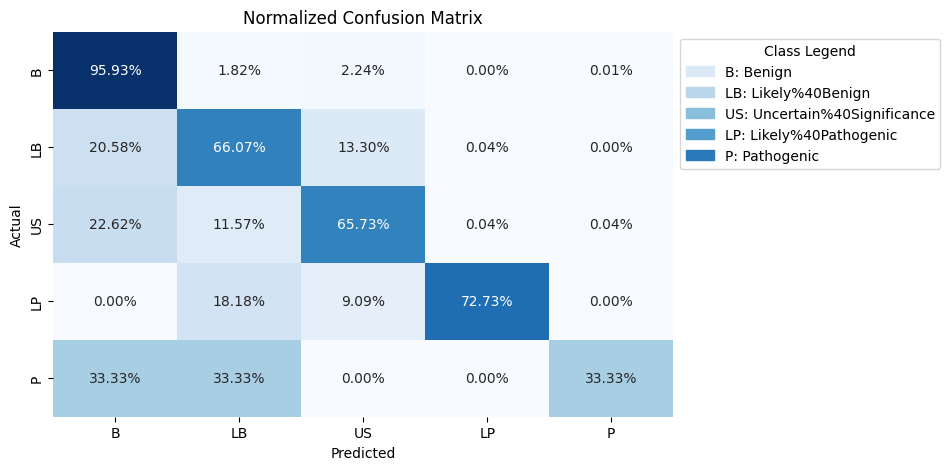

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86     29391
           1       0.35      0.72      0.47      2308
           2       0.27      0.66      0.38      2480
           3       0.05      0.73      0.10        11
           4       0.12      0.67      0.20         3

    accuracy                           0.76     34193
   macro avg       0.35      0.71      0.40     34193
weighted avg       0.88      0.76      0.80     34193



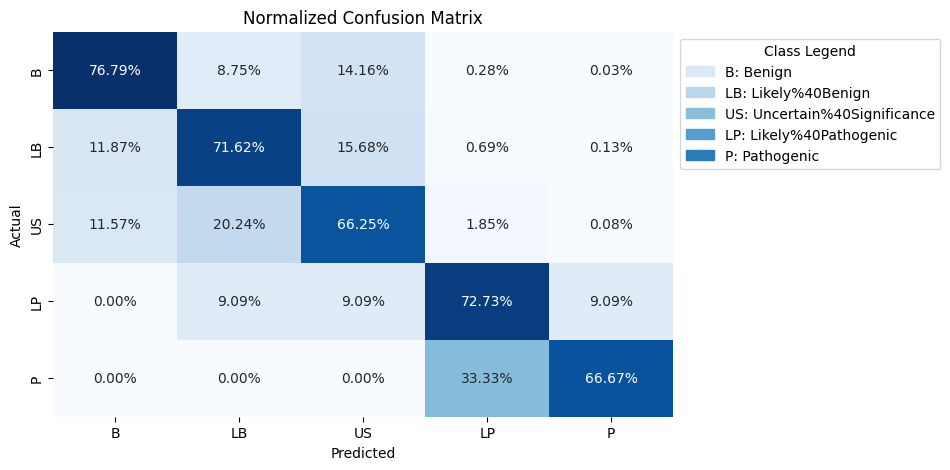

Classification report for Random Forest with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     29391
           1       0.81      0.71      0.76      2308
           2       0.89      0.63      0.73      2480
           3       1.00      0.55      0.71        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.73      0.57      0.63     34193
weighted avg       0.94      0.95      0.94     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


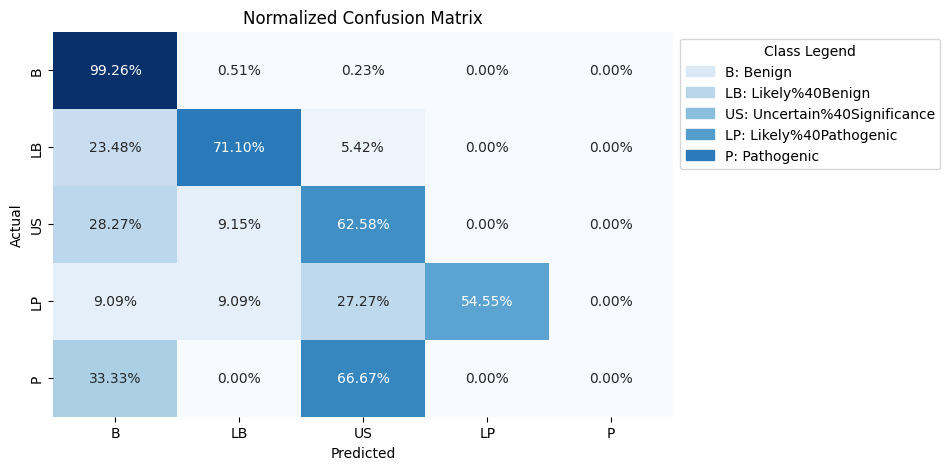

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.28      0.44     29391
           1       0.07      0.69      0.13      2308
           2       0.30      0.25      0.27      2480
           3       0.04      0.82      0.08        11
           4       0.33      0.33      0.33         3

    accuracy                           0.31     34193
   macro avg       0.34      0.48      0.25     34193
weighted avg       0.85      0.31      0.40     34193



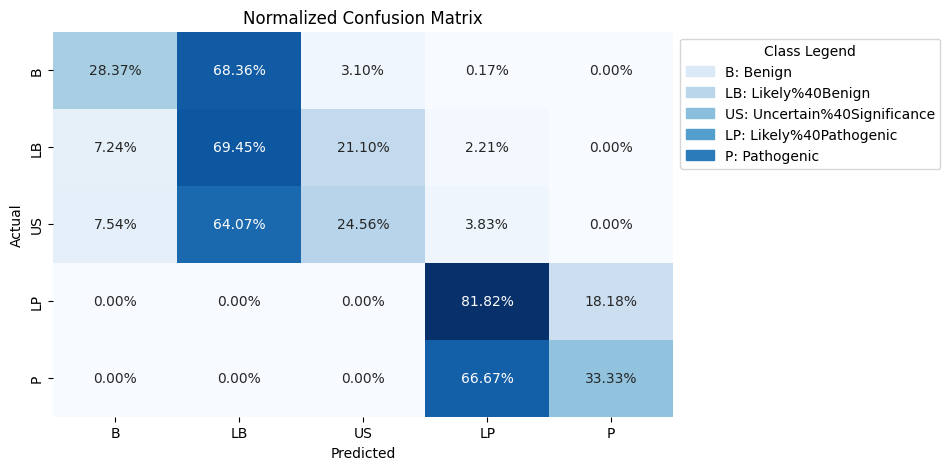

Classification report for Bagging with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29391
           1       0.75      0.74      0.75      2308
           2       0.83      0.65      0.73      2480
           3       0.67      0.36      0.47        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.64      0.55      0.59     34193
weighted avg       0.94      0.95      0.94     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


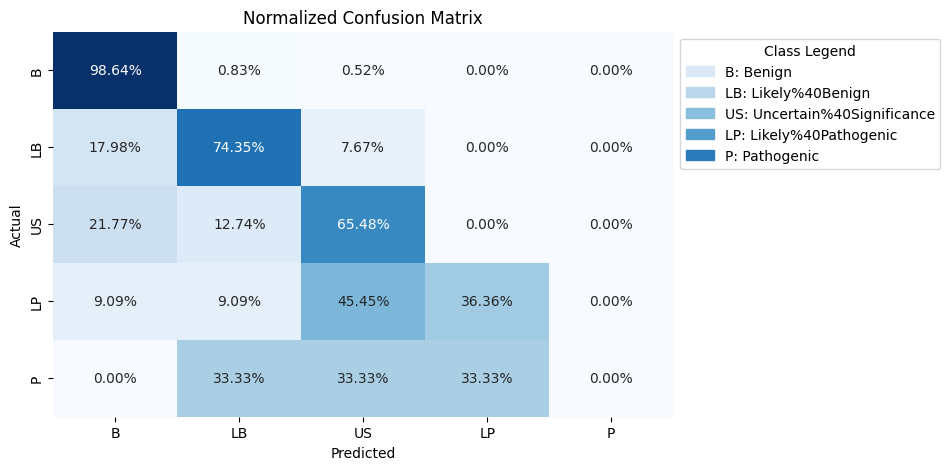

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29391
           1       0.67      0.68      0.67      2308
           2       0.65      0.65      0.65      2480
           3       0.45      0.91      0.61        11
           4       0.25      0.33      0.29         3

    accuracy                           0.92     34193
   macro avg       0.60      0.71      0.64     34193
weighted avg       0.92      0.92      0.92     34193



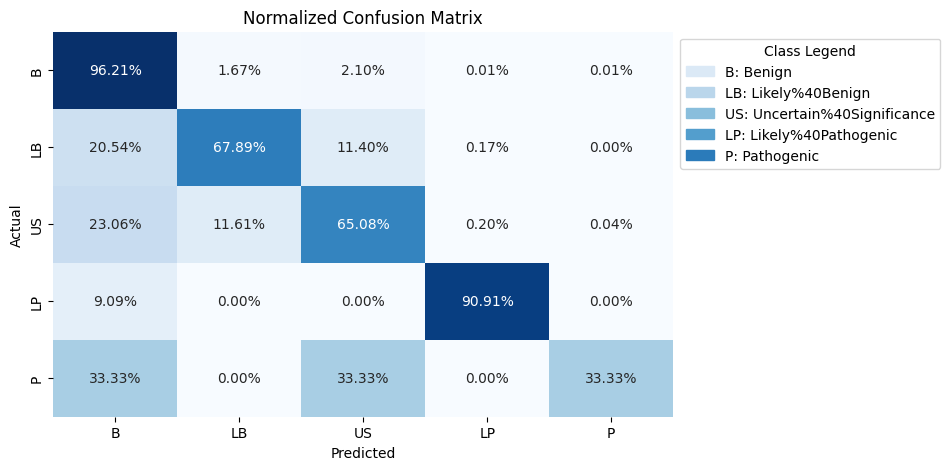

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86     29391
           1       0.35      0.71      0.47      2308
           2       0.27      0.67      0.38      2480
           3       0.06      0.73      0.11        11
           4       0.11      0.67      0.18         3

    accuracy                           0.76     34193
   macro avg       0.35      0.71      0.40     34193
weighted avg       0.88      0.76      0.80     34193



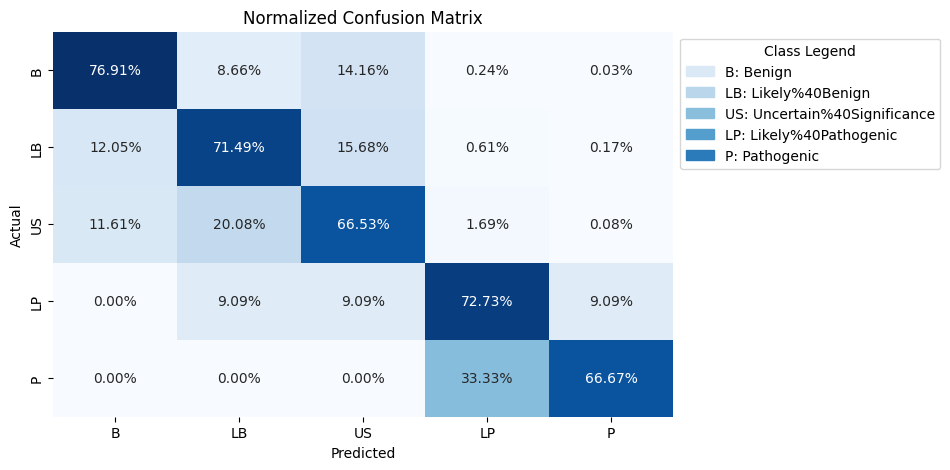

Classification report for Random Forest with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     29391
           1       0.80      0.73      0.76      2308
           2       0.89      0.63      0.74      2480
           3       1.00      0.64      0.78        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.73      0.60      0.65     34193
weighted avg       0.94      0.95      0.94     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


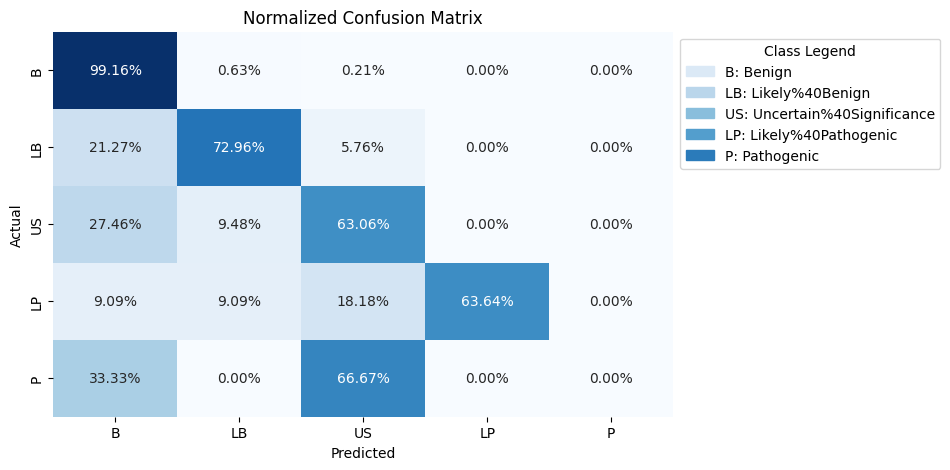

Classification report for AdaBoost with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.54      0.69     29391
           1       0.09      0.60      0.16      2308
           2       0.19      0.17      0.18      2480
           3       0.05      0.82      0.09        11
           4       0.20      0.33      0.25         3

    accuracy                           0.52     34193
   macro avg       0.30      0.49      0.27     34193
weighted avg       0.85      0.52      0.62     34193



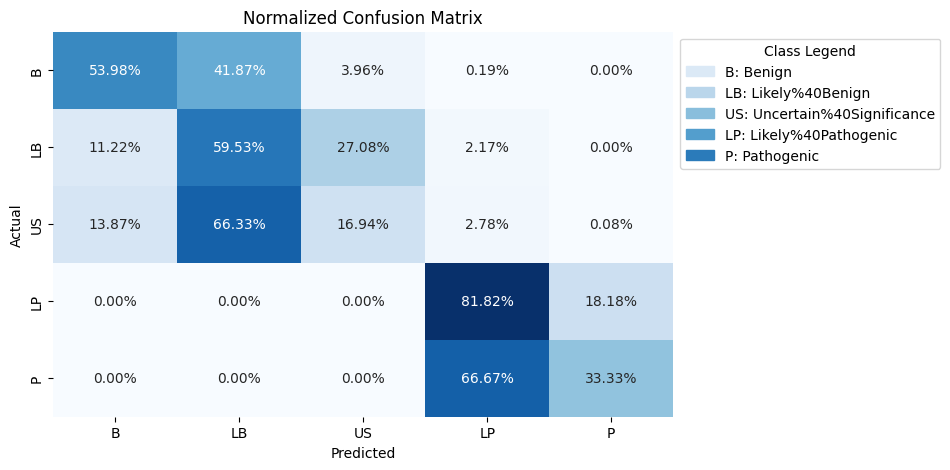

Classification report for Bagging with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29391
           1       0.76      0.74      0.75      2308
           2       0.83      0.66      0.74      2480
           3       0.71      0.45      0.56        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.65      0.57      0.60     34193
weighted avg       0.94      0.95      0.94     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


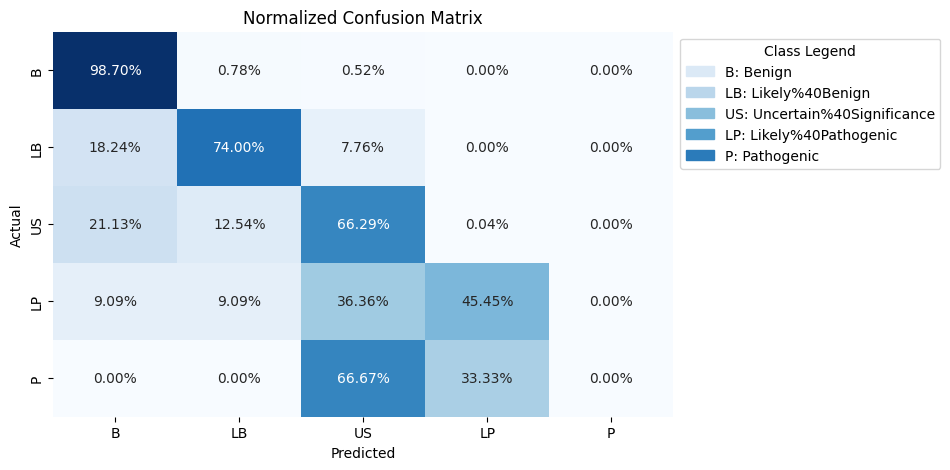

Classification report for Decision Tree with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29391
           1       0.65      0.65      0.65      2308
           2       0.63      0.66      0.64      2480
           3       0.62      0.73      0.67        11
           4       0.33      0.33      0.33         3

    accuracy                           0.92     34193
   macro avg       0.64      0.67      0.65     34193
weighted avg       0.92      0.92      0.92     34193



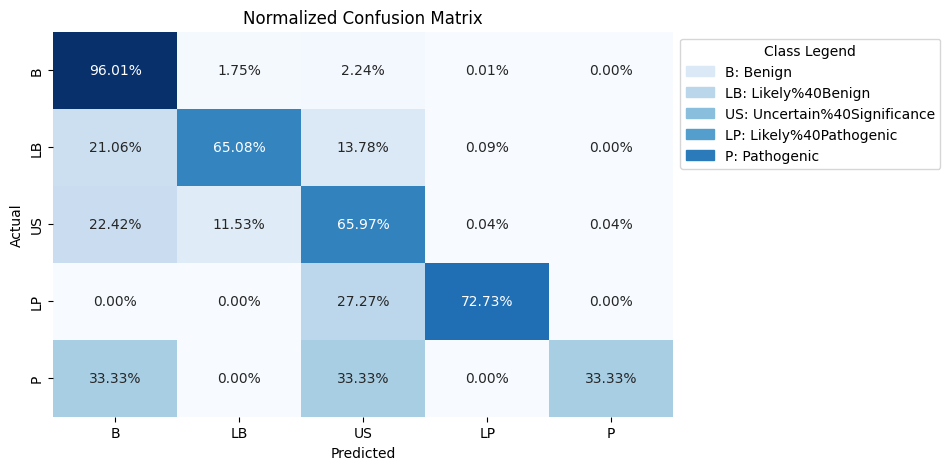

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86     29391
           1       0.35      0.72      0.47      2308
           2       0.26      0.65      0.37      2480
           3       0.05      0.82      0.10        11
           4       0.09      0.67      0.15         3

    accuracy                           0.76     34193
   macro avg       0.35      0.72      0.39     34193
weighted avg       0.88      0.76      0.80     34193



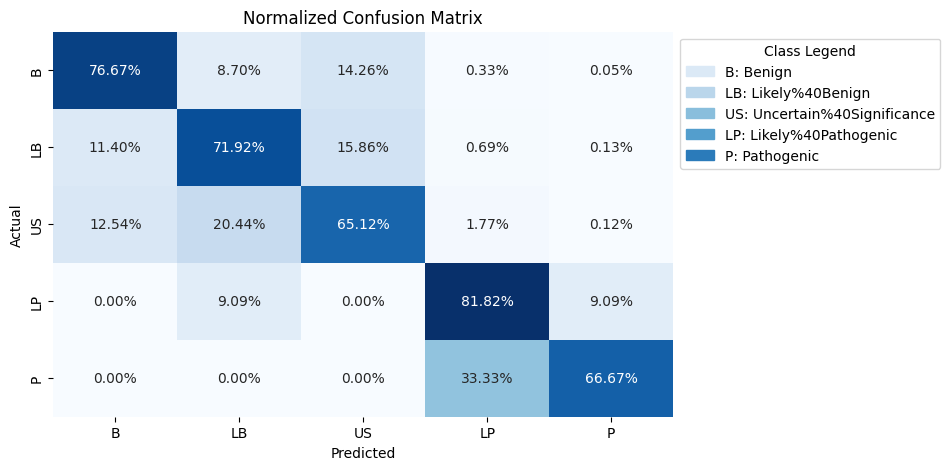

Classification report for Random Forest with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     29391
           1       0.80      0.71      0.75      2308
           2       0.89      0.63      0.74      2480
           3       1.00      0.64      0.78        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.73      0.59      0.65     34193
weighted avg       0.94      0.95      0.94     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


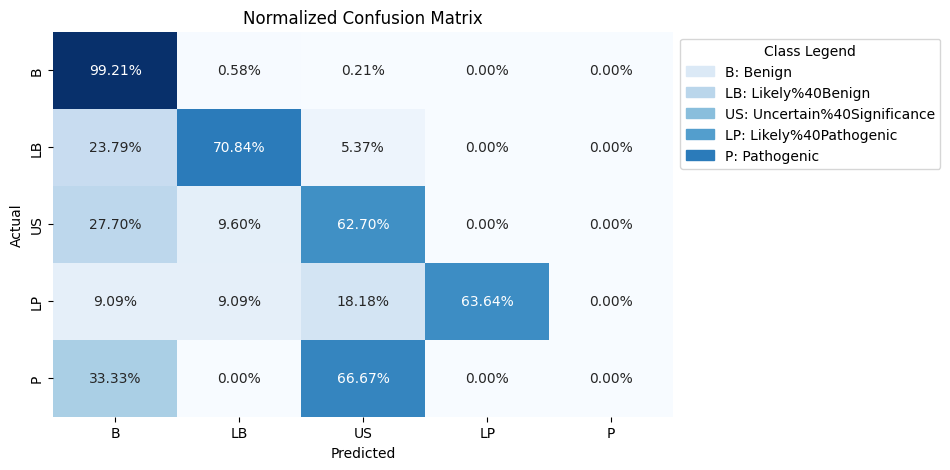

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.54      0.69     29391
           1       0.09      0.60      0.16      2308
           2       0.19      0.17      0.18      2480
           3       0.05      0.82      0.09        11
           4       0.20      0.33      0.25         3

    accuracy                           0.52     34193
   macro avg       0.30      0.49      0.27     34193
weighted avg       0.85      0.52      0.62     34193



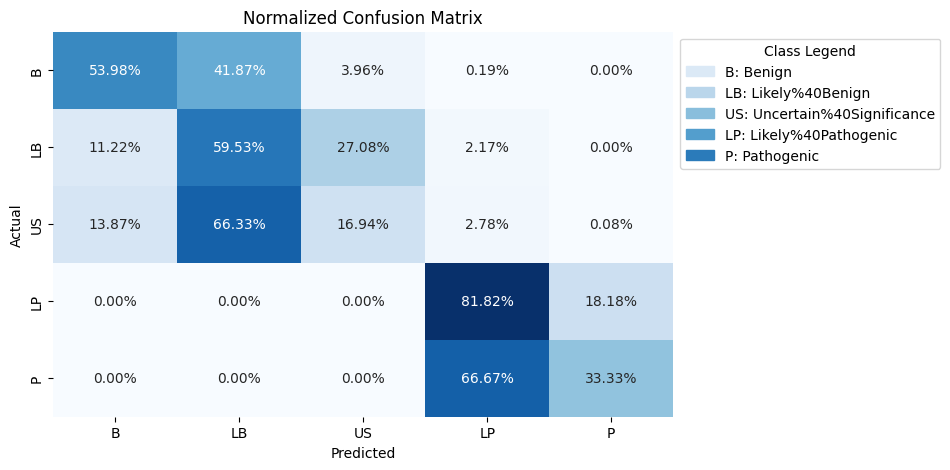

Classification report for Bagging with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29391
           1       0.76      0.74      0.75      2308
           2       0.83      0.66      0.74      2480
           3       0.67      0.18      0.29        11
           4       1.00      0.33      0.50         3

    accuracy                           0.95     34193
   macro avg       0.85      0.58      0.65     34193
weighted avg       0.94      0.95      0.94     34193



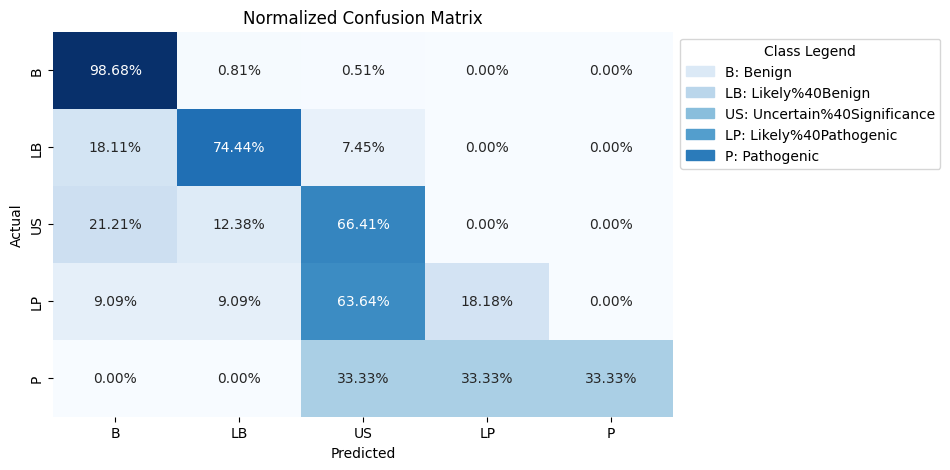

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     29391
           1       0.65      0.65      0.65      2308
           2       0.63      0.67      0.65      2480
           3       0.62      0.73      0.67        11
           4       0.33      0.33      0.33         3

    accuracy                           0.92     34193
   macro avg       0.64      0.67      0.65     34193
weighted avg       0.92      0.92      0.92     34193



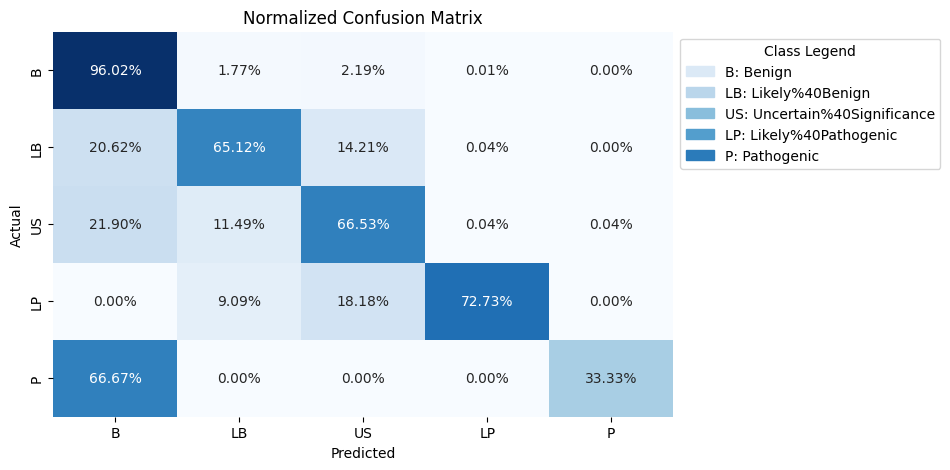

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.71      0.81     29391
           1       0.22      0.66      0.33      2308
           2       0.25      0.36      0.29      2480
           3       0.01      0.73      0.01        11
           4       0.00      0.67      0.00         3

    accuracy                           0.68     34193
   macro avg       0.29      0.62      0.29     34193
weighted avg       0.86      0.68      0.74     34193



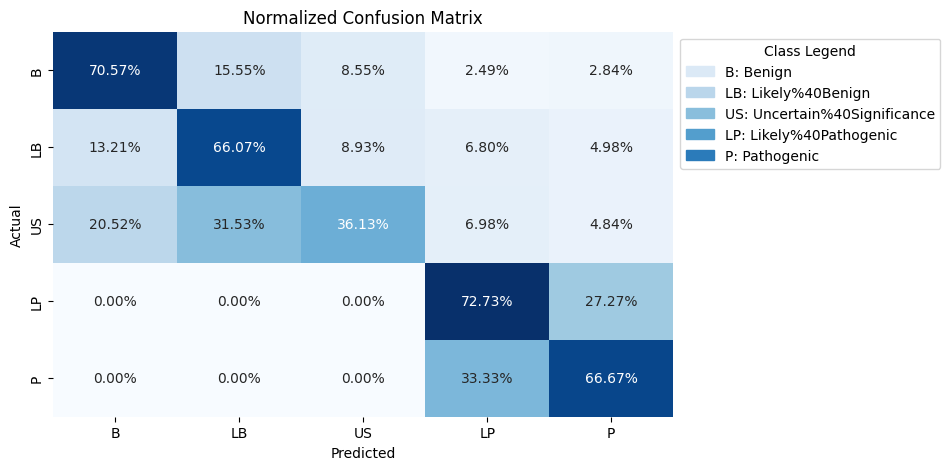

Classification report for Random Forest with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     29391
           1       0.81      0.71      0.75      2308
           2       0.90      0.62      0.74      2480
           3       1.00      0.55      0.71        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.73      0.57      0.63     34193
weighted avg       0.94      0.95      0.94     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


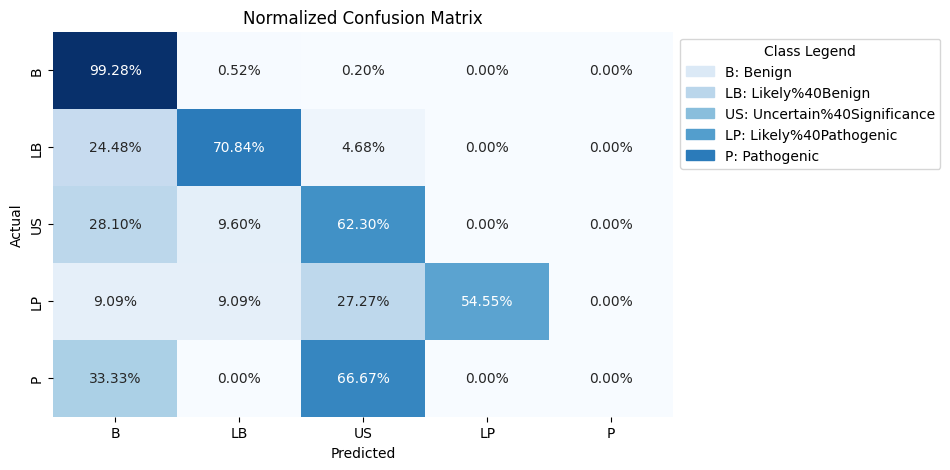

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.33      0.49     29391
           1       0.09      0.81      0.16      2308
           2       0.13      0.15      0.14      2480
           3       0.05      0.73      0.09        11
           4       1.00      0.33      0.50         3

    accuracy                           0.35     34193
   macro avg       0.45      0.47      0.28     34193
weighted avg       0.84      0.35      0.44     34193



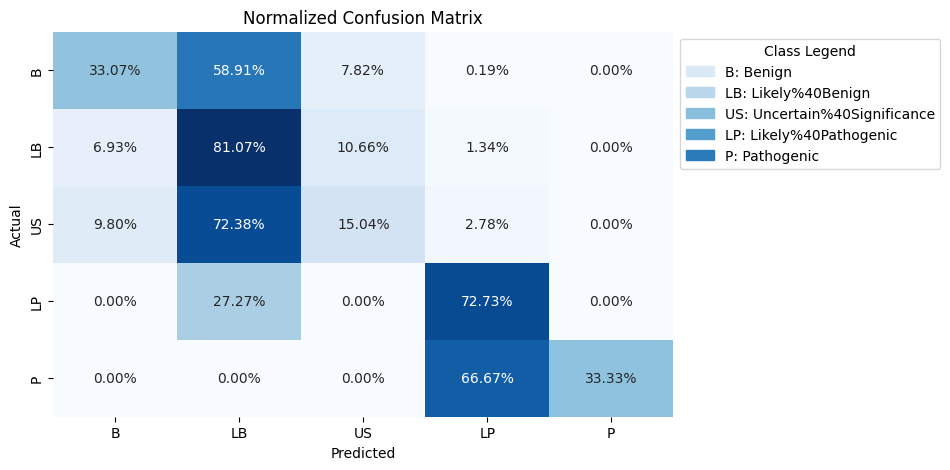

Classification report for Bagging with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29391
           1       0.76      0.75      0.75      2308
           2       0.83      0.66      0.73      2480
           3       0.57      0.36      0.44        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.63      0.55      0.58     34193
weighted avg       0.94      0.95      0.94     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


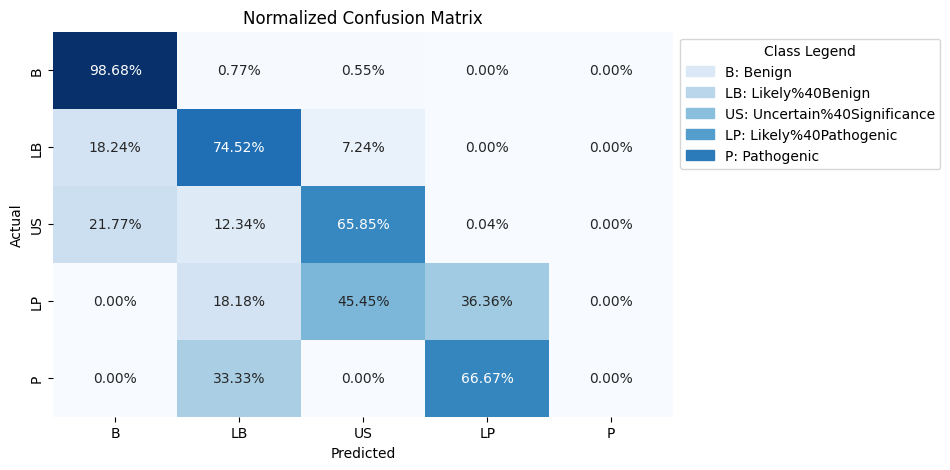

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29391
           1       0.66      0.67      0.67      2308
           2       0.64      0.66      0.65      2480
           3       0.42      0.73      0.53        11
           4       0.00      0.00      0.00         3

    accuracy                           0.92     34193
   macro avg       0.54      0.60      0.56     34193
weighted avg       0.92      0.92      0.92     34193



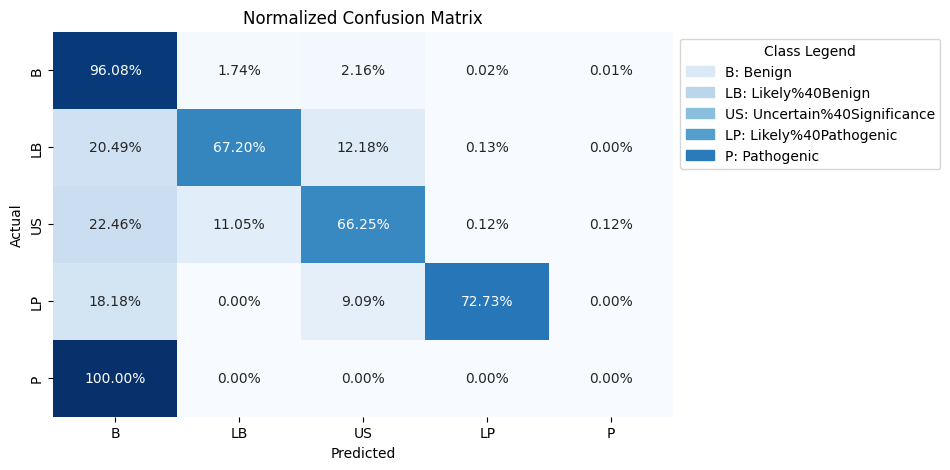

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.98      0.34      0.50     29391
           1       0.17      0.62      0.27      2308
           2       0.13      0.62      0.22      2480
           3       0.00      0.82      0.01        11
           4       0.00      0.67      0.00         3

    accuracy                           0.38     34193
   macro avg       0.26      0.61      0.20     34193
weighted avg       0.86      0.38      0.47     34193



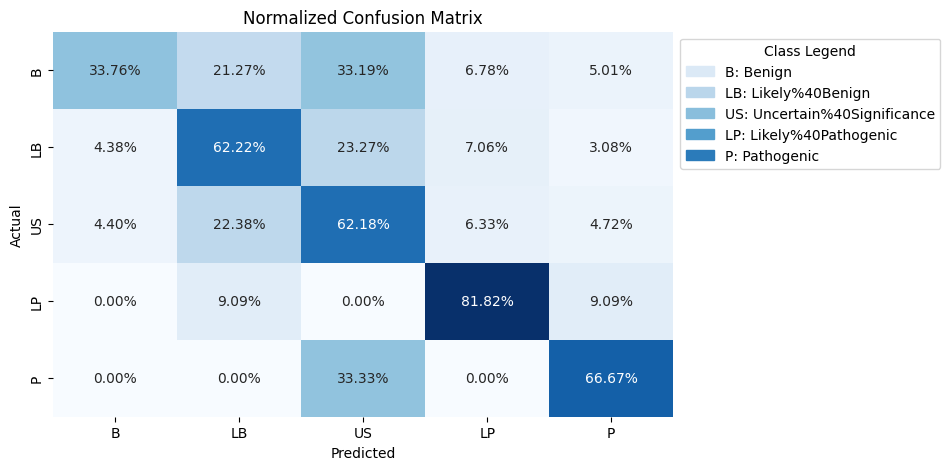

Classification report for Random Forest with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     29391
           1       0.81      0.72      0.76      2308
           2       0.89      0.63      0.74      2480
           3       1.00      0.45      0.62        11
           4       0.00      0.00      0.00         3

    accuracy                           0.95     34193
   macro avg       0.73      0.56      0.62     34193
weighted avg       0.94      0.95      0.94     34193



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


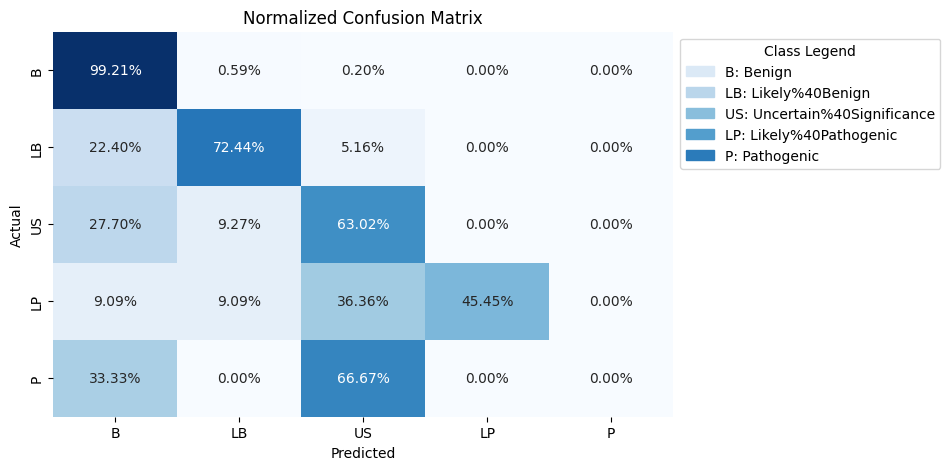

Classification report for AdaBoost with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.54      0.69     29391
           1       0.09      0.60      0.16      2308
           2       0.19      0.17      0.18      2480
           3       0.05      0.82      0.09        11
           4       0.20      0.33      0.25         3

    accuracy                           0.52     34193
   macro avg       0.30      0.49      0.27     34193
weighted avg       0.85      0.52      0.62     34193



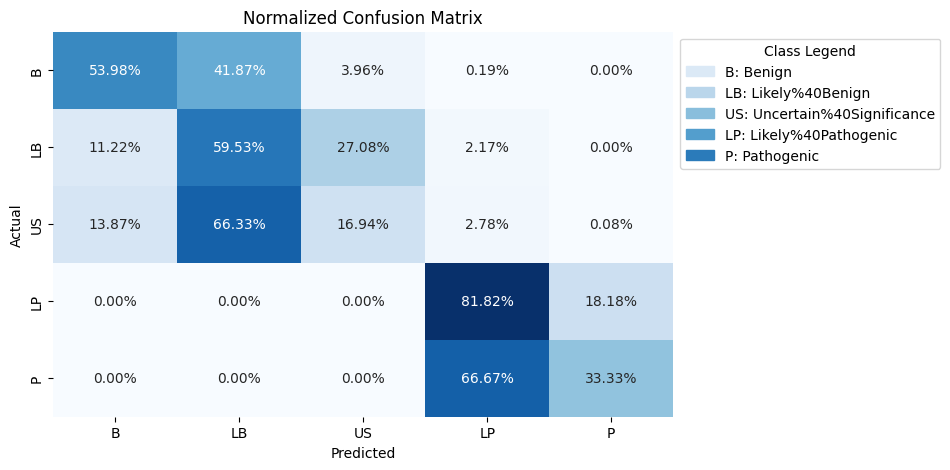

Classification report for Bagging with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29391
           1       0.76      0.74      0.75      2308
           2       0.83      0.67      0.74      2480
           3       0.80      0.36      0.50        11
           4       1.00      0.33      0.50         3

    accuracy                           0.95     34193
   macro avg       0.87      0.62      0.69     34193
weighted avg       0.94      0.95      0.94     34193



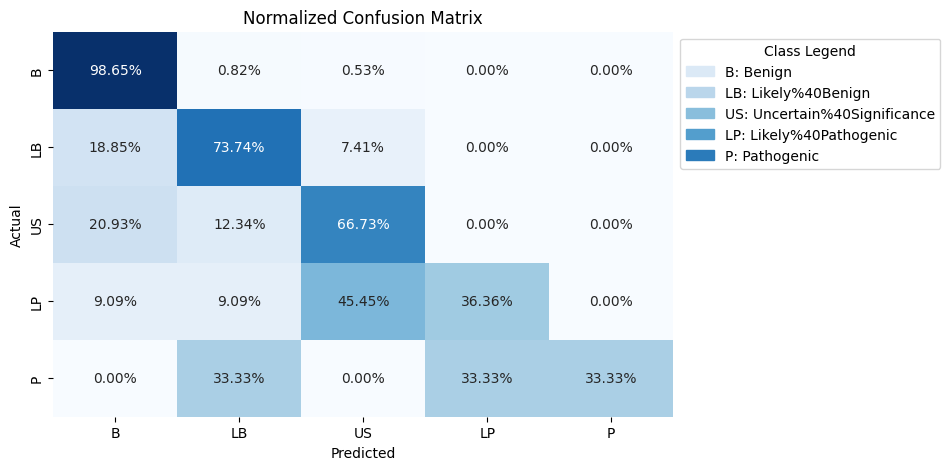

Classification report for Decision Tree with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     29391
           1       0.65      0.65      0.65      2308
           2       0.63      0.66      0.65      2480
           3       0.67      0.73      0.70        11
           4       0.33      0.33      0.33         3

    accuracy                           0.92     34193
   macro avg       0.65      0.67      0.66     34193
weighted avg       0.92      0.92      0.92     34193



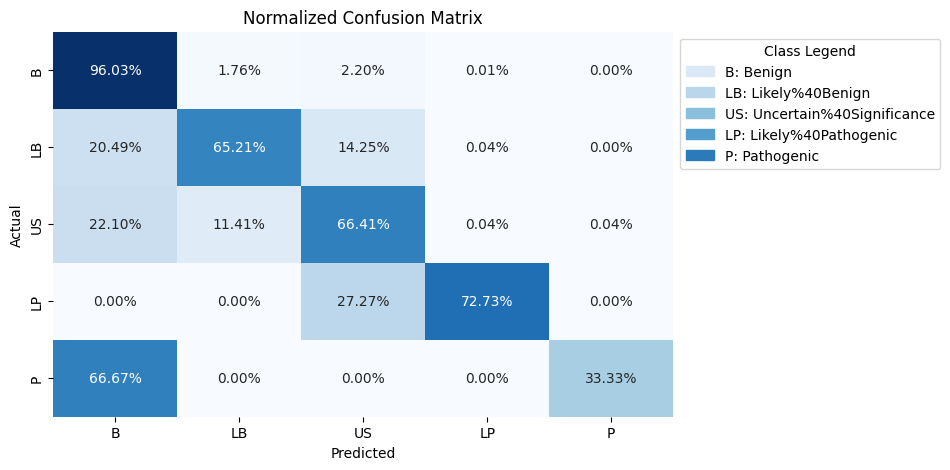

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.62      0.76     29391
           1       0.23      0.61      0.34      2308
           2       0.20      0.57      0.30      2480
           3       0.01      0.91      0.02        11
           4       0.00      0.67      0.00         3

    accuracy                           0.62     34193
   macro avg       0.28      0.68      0.28     34193
weighted avg       0.87      0.62      0.70     34193



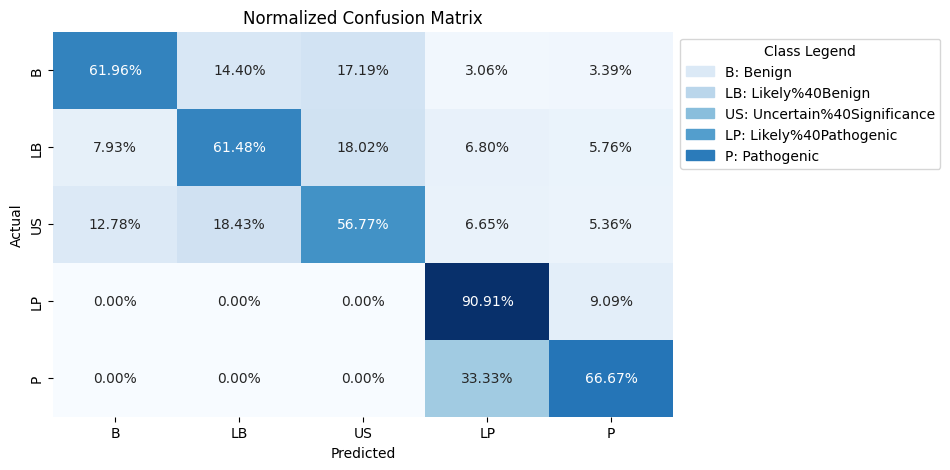

In [26]:
preprocessings = [
    ("None", None),
    ("MinMax", MinMaxScaler()),
    ("Robust", RobustScaler())
]

datasets = [
    ("Encoded - OneHot Nans, Outside Range", encoded_df1),
    ("Encoded - OneHot Nans, Median",encoded_df2),
    ("Encoded - Outside Range", encoded_df3)
]

for preprocessing_name, preprocessing_method in preprocessings:
    for dataset_name, dataset in datasets:
        test_patient = dataset[dataset['patient'] == 0].copy()
        test_patient = test_patient.sample(frac=1, random_state=42).reset_index(drop=True)
        temp_df = dataset[dataset['patient'] != 0]

        X_test = test_patient.drop(columns=["patient", target_column])
        y_test = test_patient[target_column]

        X = temp_df.drop(columns = ["patient", target_column])
        y = temp_df[target_column]
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
        if preprocessing_name != "None":
            X_train = pd.DataFrame(preprocessing_method.fit_transform(X_train), columns=X.columns)
            X_val = pd.DataFrame(preprocessing_method.transform(X_val), columns=X.columns)
            X_test = pd.DataFrame(preprocessing_method.transform(X_test), columns=X.columns)
        model_seed = 42

        class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

        models = [
            ('Random Forest', RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('AdaBoost', AdaBoostClassifier(random_state=model_seed)),
            ('Bagging', BaggingClassifier(random_state=model_seed)),
            ('Decision Tree', DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            
        ]

        for model_name, model in models:
            clf = model

            pipeline = Pipeline([
                ('classifier', clf)
            ])

            if model_name == 'AdaBoost':
                sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
                pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
            else:
                pipeline.fit(X_train, y_train)
            
            y_pred = pipeline.predict(X_val)
            report = classification_report(y_val, y_pred)
            print(f"Classification report for {model_name} with dataset {dataset_name} and preprocessing {preprocessing_name}:")
            print(report)

            get_confusion_matrix_plot(y_val, y_pred, inverted_mapping)

Classification report for CatBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     90705
           1       0.16      0.69      0.26      2671
           2       0.64      0.31      0.42      9105
           3       0.26      0.40      0.31        20
           4       0.57      0.25      0.35        16

    accuracy                           0.88    102517
   macro avg       0.52      0.52      0.46    102517
weighted avg       0.93      0.88      0.90    102517



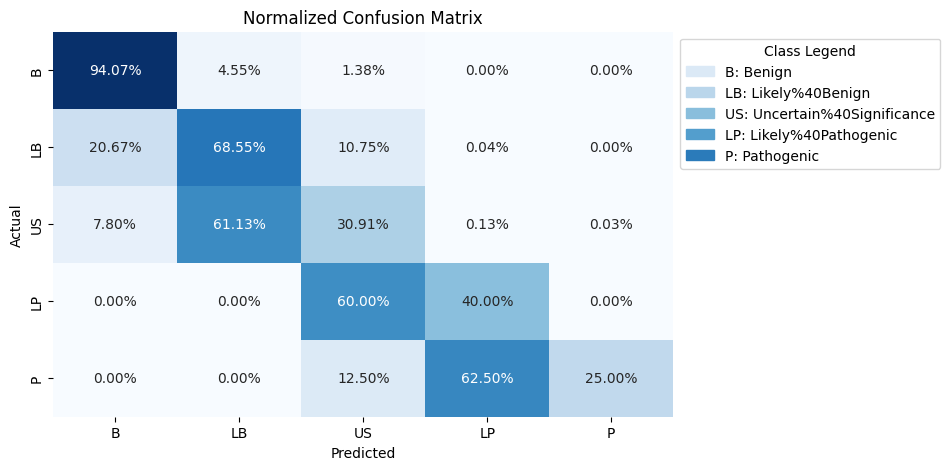

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [13:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     90705
           1       0.18      0.44      0.26      2671
           2       0.89      0.26      0.40      9105
           3       0.33      0.30      0.32        20
           4       1.00      0.19      0.32        16

    accuracy                           0.92    102517
   macro avg       0.68      0.44      0.46    102517
weighted avg       0.94      0.92      0.91    102517



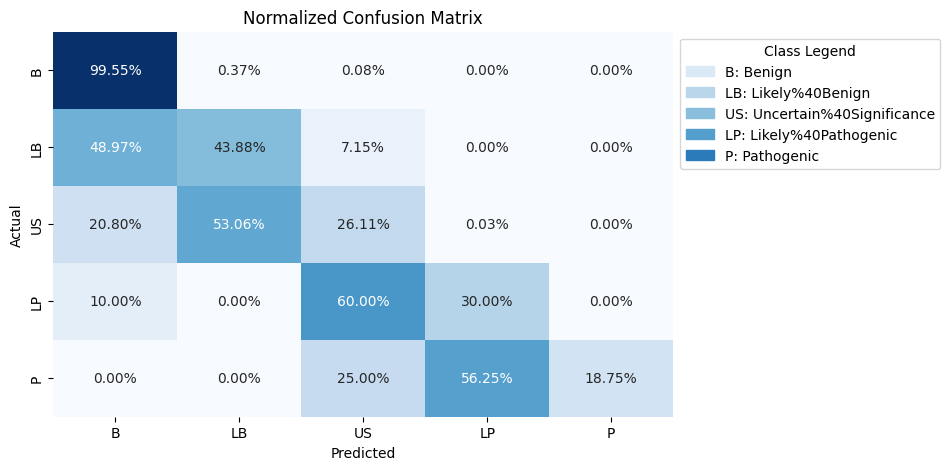

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8818
[LightGBM] [Info] Number of data points in the train set: 307734, number of used features: 169
[LightGBM] [Info] Start training from score -1.610776
[LightGBM] [Info] Start training from score -1.610759
[LightGBM] [Info] Start training from score -1.610765
[LightGBM] [Info] Start training from score -1.617204
[LightGBM] [Info] Start training from score -1.597786
Classification report for LightGBM with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     90705
           1       0.16      0.71      0.26      2671
           2       0.66      0.29      0.40      9105
           3       0.22      0.35      0.27      

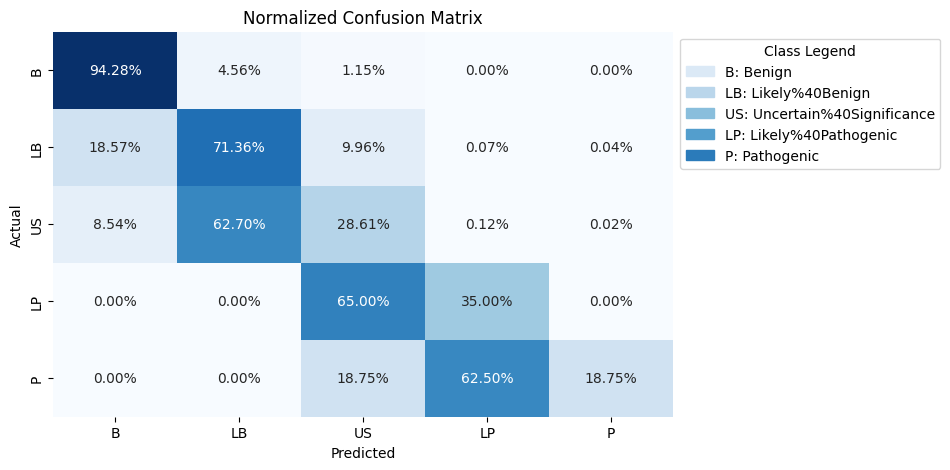

Classification report for Random Forest with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     90705
           1       0.20      0.39      0.26      2671
           2       0.93      0.27      0.42      9105
           3       0.45      0.25      0.32        20
           4       1.00      0.12      0.22        16

    accuracy                           0.92    102517
   macro avg       0.71      0.41      0.44    102517
weighted avg       0.94      0.92      0.91    102517



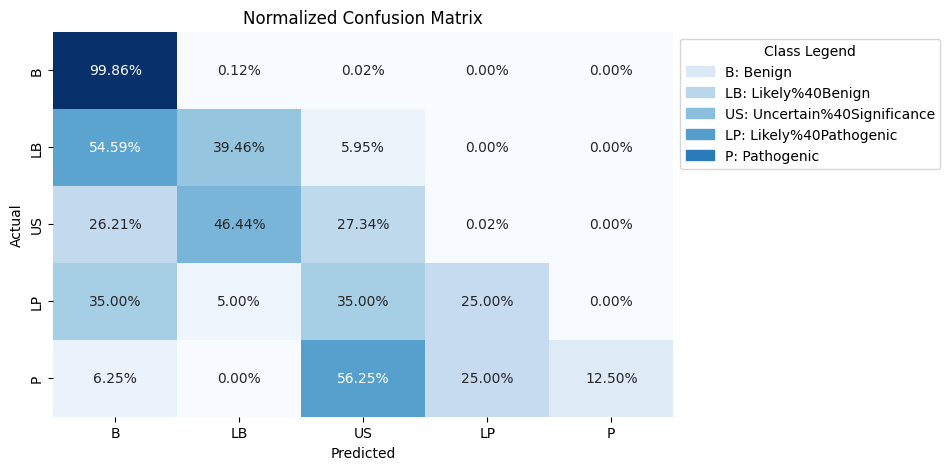

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     90705
           1       0.04      0.56      0.07      2671
           2       0.45      0.40      0.43      9105
           3       0.02      0.60      0.04        20
           4       0.28      0.31      0.29        16

    accuracy                           0.58    102517
   macro avg       0.35      0.49      0.31    102517
weighted avg       0.89      0.58      0.69    102517



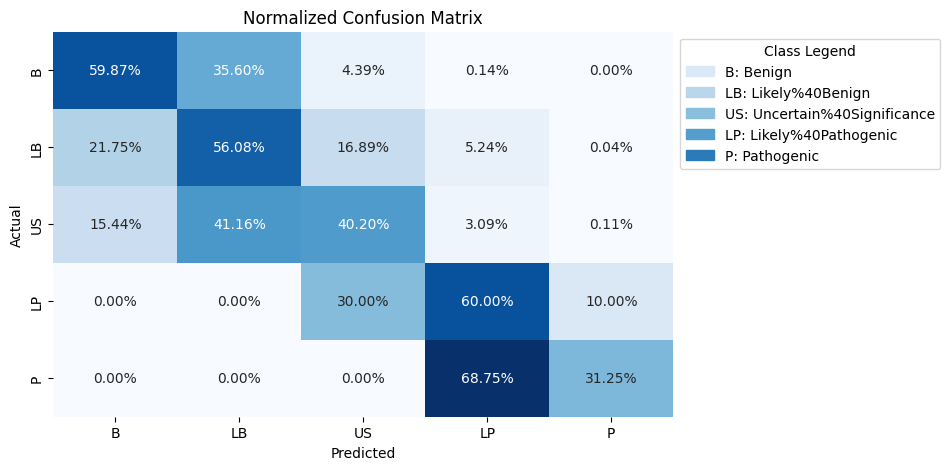

Classification report for Bagging with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     90705
           1       0.17      0.39      0.24      2671
           2       0.88      0.25      0.39      9105
           3       0.25      0.20      0.22        20
           4       1.00      0.06      0.12        16

    accuracy                           0.91    102517
   macro avg       0.65      0.38      0.39    102517
weighted avg       0.94      0.91      0.91    102517



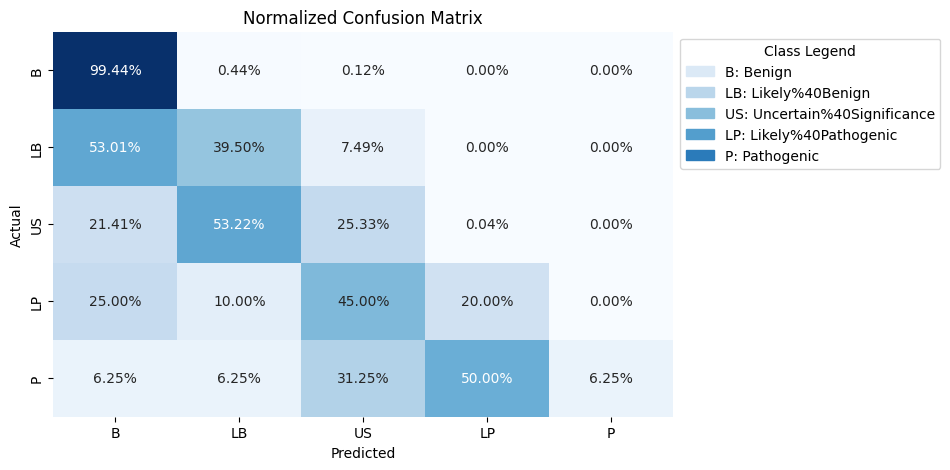

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     90705
           1       0.15      0.43      0.23      2671
           2       0.64      0.30      0.41      9105
           3       0.21      0.25      0.23        20
           4       0.11      0.06      0.08        16

    accuracy                           0.89    102517
   macro avg       0.42      0.40      0.38    102517
weighted avg       0.92      0.89      0.90    102517



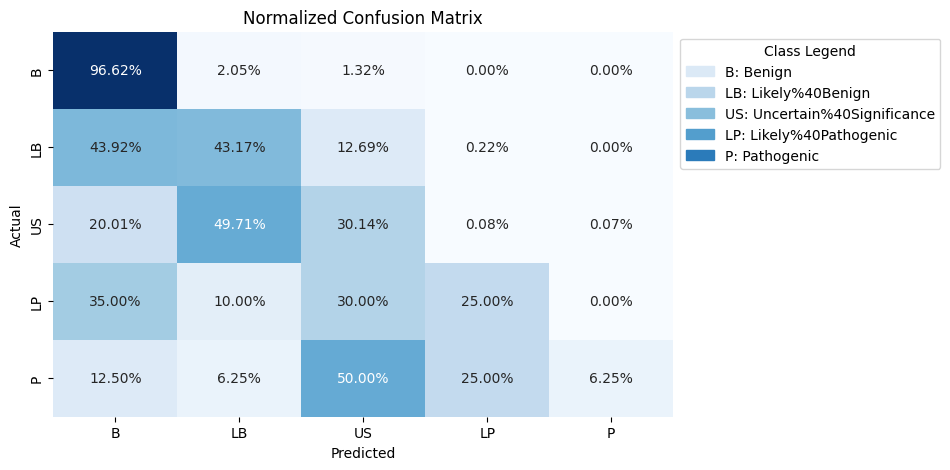

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.89      0.43      0.58     90705
           1       0.00      0.00      0.00      2671
           2       0.00      0.00      0.00      9105
           3       0.00      0.70      0.00        20
           4       0.00      0.00      0.00        16

    accuracy                           0.38    102517
   macro avg       0.18      0.23      0.12    102517
weighted avg       0.79      0.38      0.51    102517



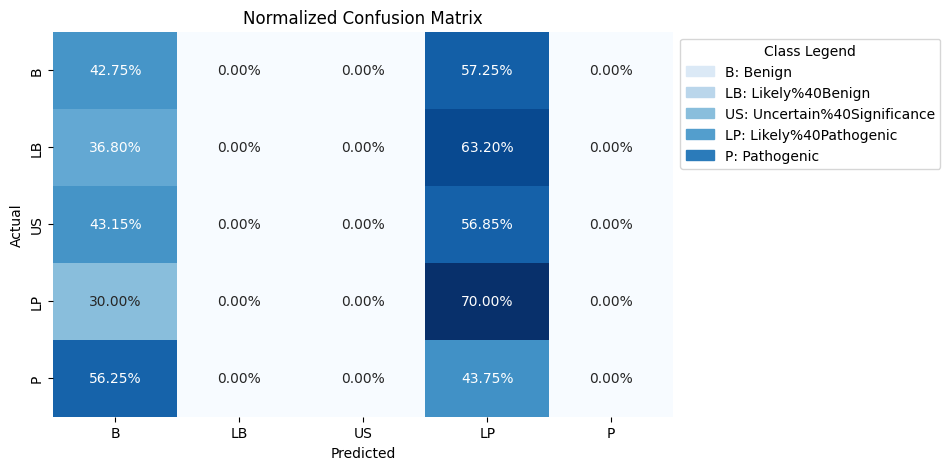

Classification report for CatBoost with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     90705
           1       0.19      0.70      0.31      2671
           2       0.63      0.37      0.46      9105
           3       0.24      0.35      0.29        20
           4       0.67      0.38      0.48        16

    accuracy                           0.89    102517
   macro avg       0.54      0.55      0.50    102517
weighted avg       0.93      0.89      0.90    102517



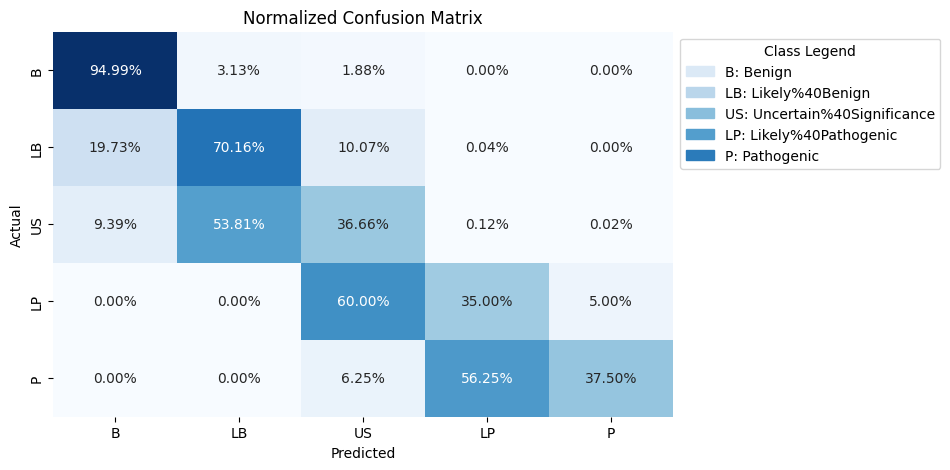

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [13:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     90705
           1       0.18      0.43      0.25      2671
           2       0.88      0.26      0.40      9105
           3       0.28      0.25      0.26        20
           4       1.00      0.31      0.48        16

    accuracy                           0.91    102517
   macro avg       0.66      0.45      0.47    102517
weighted avg       0.94      0.91      0.91    102517



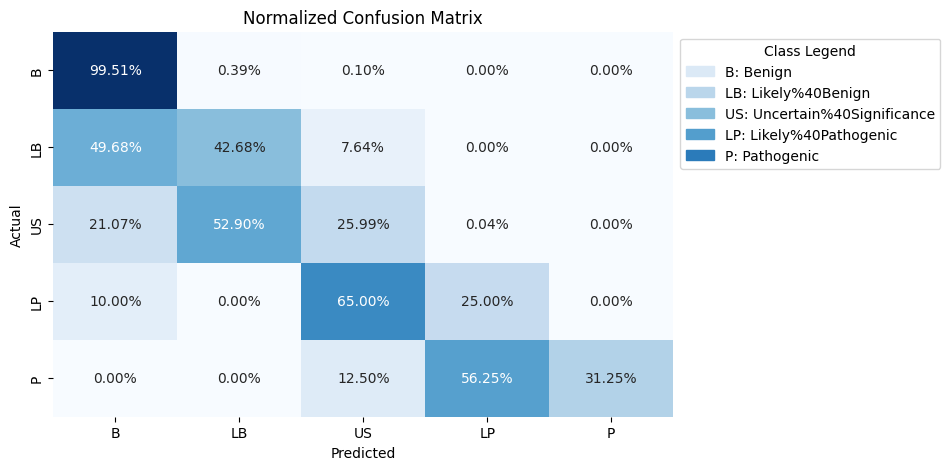

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8730
[LightGBM] [Info] Number of data points in the train set: 307734, number of used features: 165
[LightGBM] [Info] Start training from score -1.610776
[LightGBM] [Info] Start training from score -1.610759
[LightGBM] [Info] Start training from score -1.610765
[LightGBM] [Info] Start training from score -1.617204
[LightGBM] [Info] Start training from score -1.597786
Classification report for LightGBM with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     90705
           1       0.15      0.69      0.25      2671
           2       0.65      0.28      0.39      9105
           3       0.16      0.30      0.21        20
  

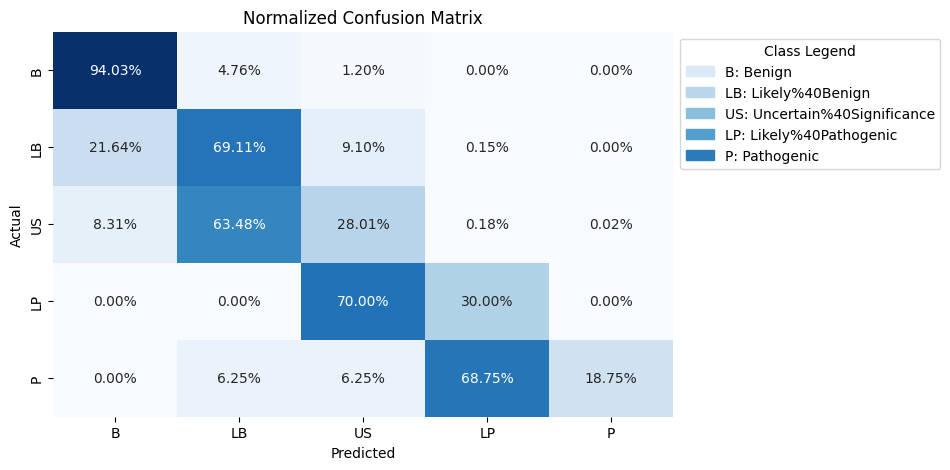

Classification report for Random Forest with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     90705
           1       0.19      0.39      0.26      2671
           2       0.93      0.28      0.43      9105
           3       0.45      0.25      0.32        20
           4       1.00      0.12      0.22        16

    accuracy                           0.92    102517
   macro avg       0.71      0.41      0.44    102517
weighted avg       0.94      0.92      0.91    102517



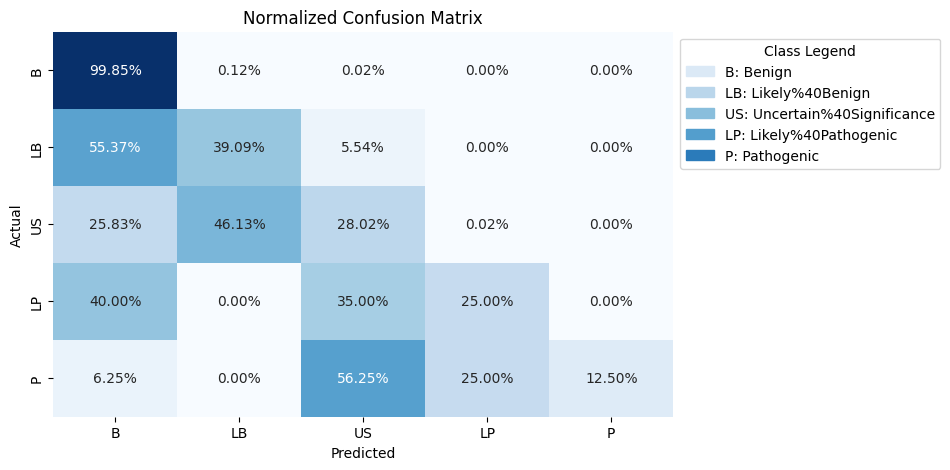

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.32      0.48     90705
           1       0.03      0.66      0.05      2671
           2       0.19      0.18      0.19      9105
           3       0.03      0.65      0.05        20
           4       0.27      0.25      0.26        16

    accuracy                           0.32    102517
   macro avg       0.30      0.41      0.21    102517
weighted avg       0.87      0.32      0.44    102517



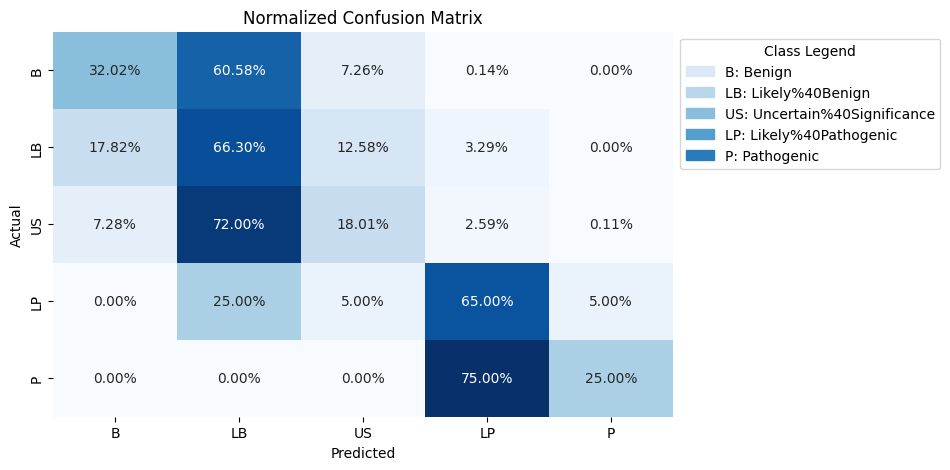

Classification report for Bagging with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     90705
           1       0.18      0.40      0.25      2671
           2       0.89      0.26      0.40      9105
           3       0.29      0.25      0.27        20
           4       1.00      0.06      0.12        16

    accuracy                           0.91    102517
   macro avg       0.66      0.39      0.40    102517
weighted avg       0.94      0.91      0.91    102517



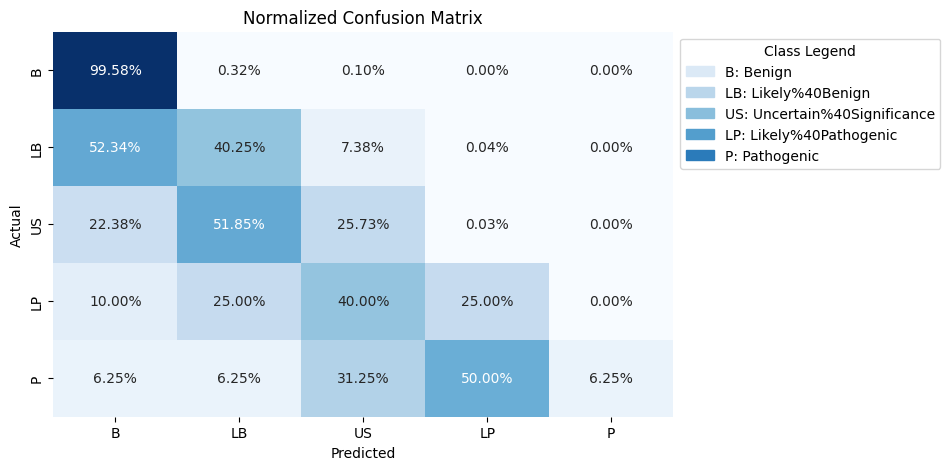

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     90705
           1       0.14      0.39      0.21      2671
           2       0.63      0.30      0.41      9105
           3       0.06      0.10      0.08        20
           4       0.12      0.06      0.08        16

    accuracy                           0.89    102517
   macro avg       0.38      0.37      0.35    102517
weighted avg       0.91      0.89      0.90    102517



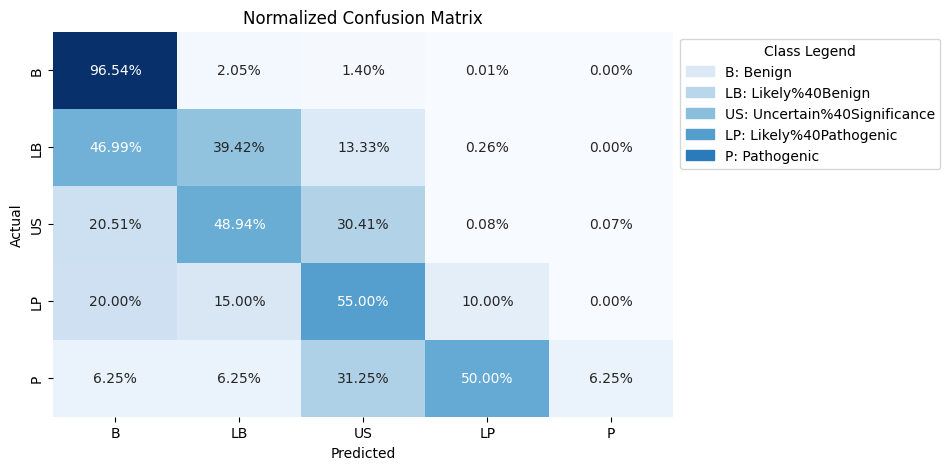

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.92      0.42      0.58     90705
           1       0.03      0.39      0.06      2671
           2       0.00      0.00      0.00      9105
           3       0.00      0.30      0.00        20
           4       0.00      0.00      0.00        16

    accuracy                           0.38    102517
   macro avg       0.19      0.22      0.13    102517
weighted avg       0.82      0.38      0.51    102517



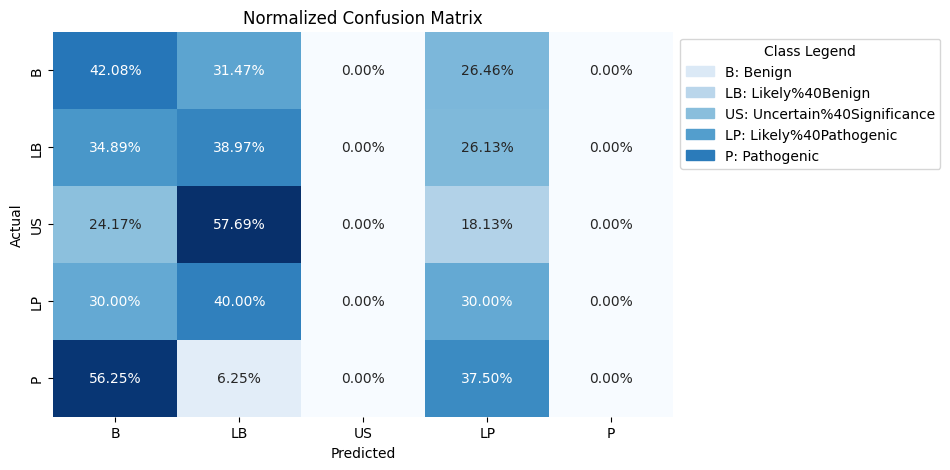

Classification report for CatBoost with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     90705
           1       0.19      0.66      0.29      2671
           2       0.62      0.37      0.46      9105
           3       0.28      0.45      0.35        20
           4       0.67      0.25      0.36        16

    accuracy                           0.89    102517
   macro avg       0.55      0.54      0.49    102517
weighted avg       0.93      0.89      0.90    102517



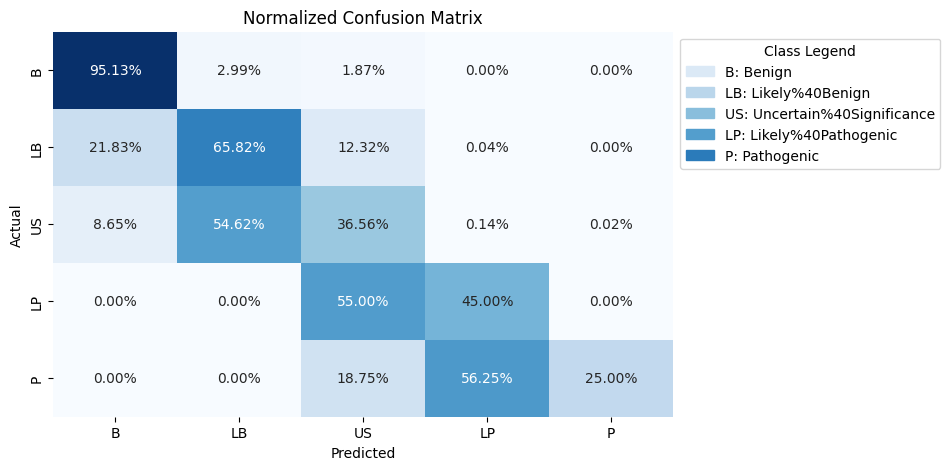

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [13:59:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     90705
           1       0.18      0.43      0.26      2671
           2       0.89      0.26      0.40      9105
           3       0.28      0.25      0.26        20
           4       1.00      0.19      0.32        16

    accuracy                           0.91    102517
   macro avg       0.66      0.42      0.44    102517
weighted avg       0.94      0.91      0.91    102517



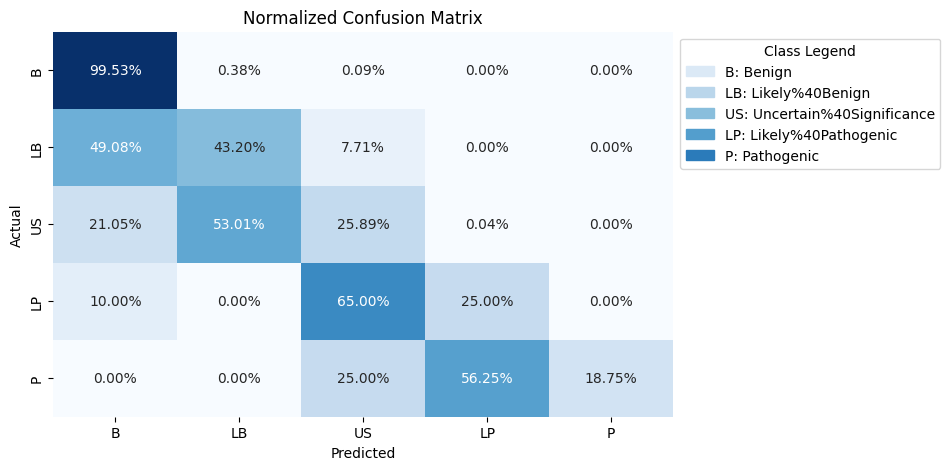

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8690
[LightGBM] [Info] Number of data points in the train set: 307734, number of used features: 105
[LightGBM] [Info] Start training from score -1.610776
[LightGBM] [Info] Start training from score -1.610759
[LightGBM] [Info] Start training from score -1.610765
[LightGBM] [Info] Start training from score -1.617204
[LightGBM] [Info] Start training from score -1.597786
Classification report for LightGBM with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     90705
           1       0.16      0.71      0.27      2671
           2       0.66      0.29      0.40      9105
           3       0.23      0.35      0.28        20
        

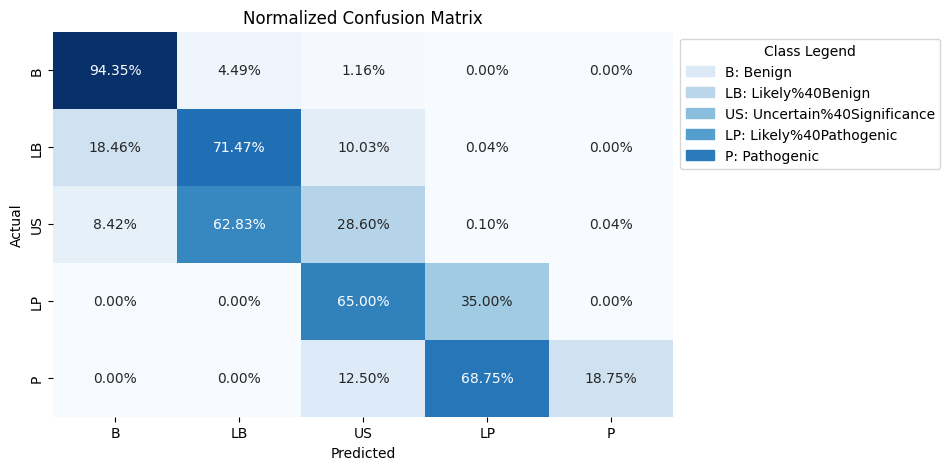

Classification report for Random Forest with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     90705
           1       0.20      0.40      0.26      2671
           2       0.92      0.27      0.42      9105
           3       0.45      0.25      0.32        20
           4       1.00      0.12      0.22        16

    accuracy                           0.92    102517
   macro avg       0.71      0.41      0.44    102517
weighted avg       0.94      0.92      0.91    102517



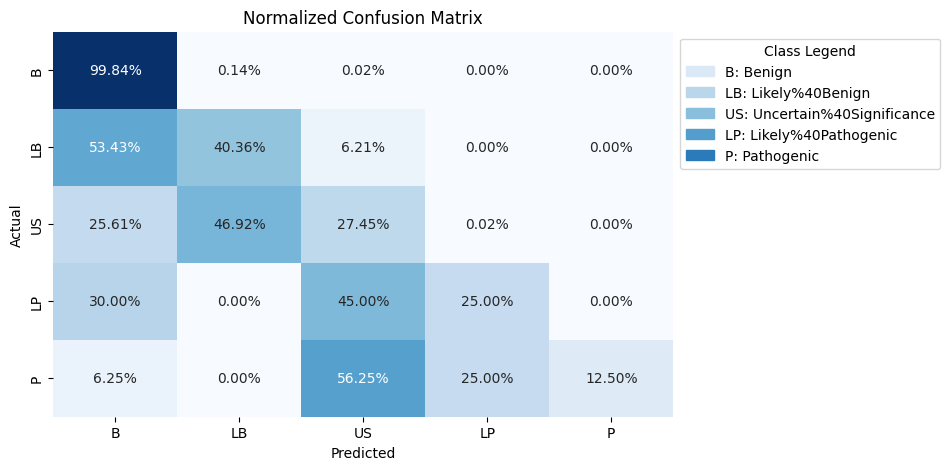

Classification report for AdaBoost with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     90705
           1       0.04      0.56      0.07      2671
           2       0.45      0.40      0.43      9105
           3       0.02      0.60      0.04        20
           4       0.28      0.31      0.29        16

    accuracy                           0.58    102517
   macro avg       0.35      0.49      0.31    102517
weighted avg       0.89      0.58      0.69    102517



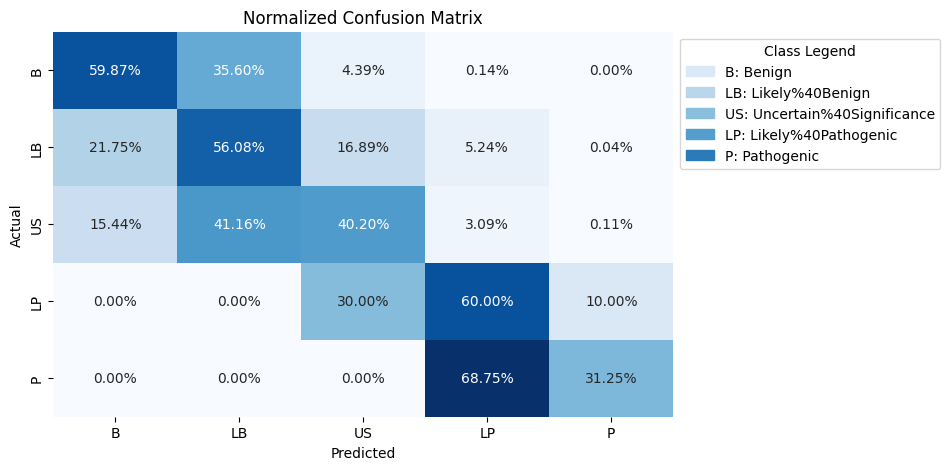

Classification report for Bagging with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     90705
           1       0.17      0.39      0.23      2671
           2       0.87      0.25      0.39      9105
           3       0.29      0.20      0.24        20
           4       1.00      0.06      0.12        16

    accuracy                           0.91    102517
   macro avg       0.66      0.38      0.39    102517
weighted avg       0.93      0.91      0.91    102517



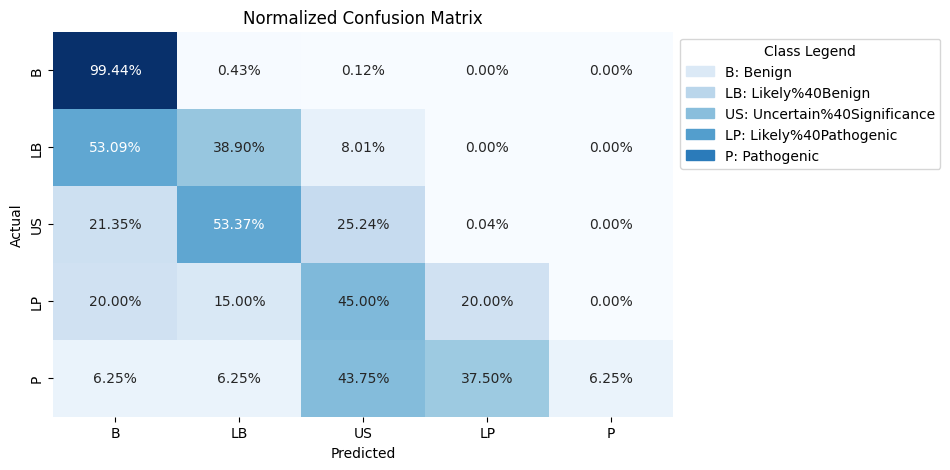

Classification report for Decision Tree with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     90705
           1       0.15      0.43      0.23      2671
           2       0.63      0.30      0.41      9105
           3       0.21      0.25      0.23        20
           4       0.12      0.06      0.08        16

    accuracy                           0.89    102517
   macro avg       0.42      0.40      0.38    102517
weighted avg       0.92      0.89      0.90    102517



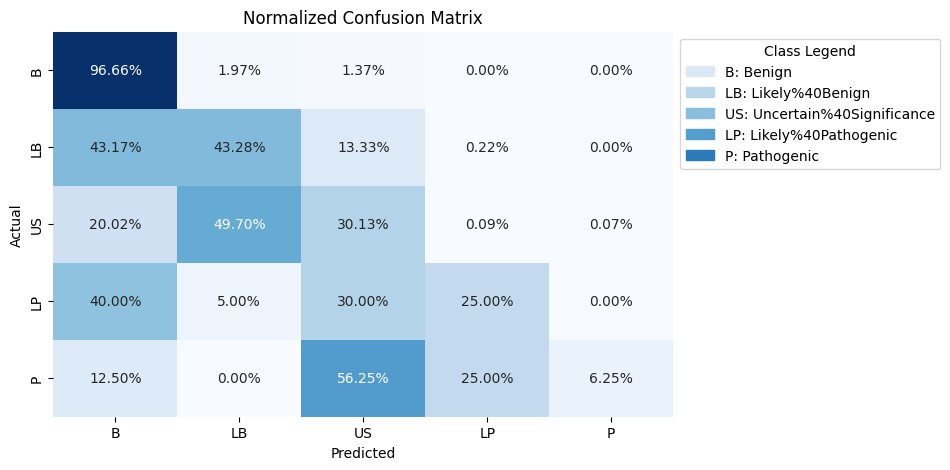

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Logistic Regression with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.89      0.43      0.58     90705
           1       0.00      0.00      0.00      2671
           2       0.00      0.00      0.00      9105
           3       0.00      0.70      0.00        20
           4       0.00      0.00      0.00        16

    accuracy                           0.38    102517
   macro avg       0.18      0.23      0.12    102517
weighted avg       0.79      0.38      0.51    102517



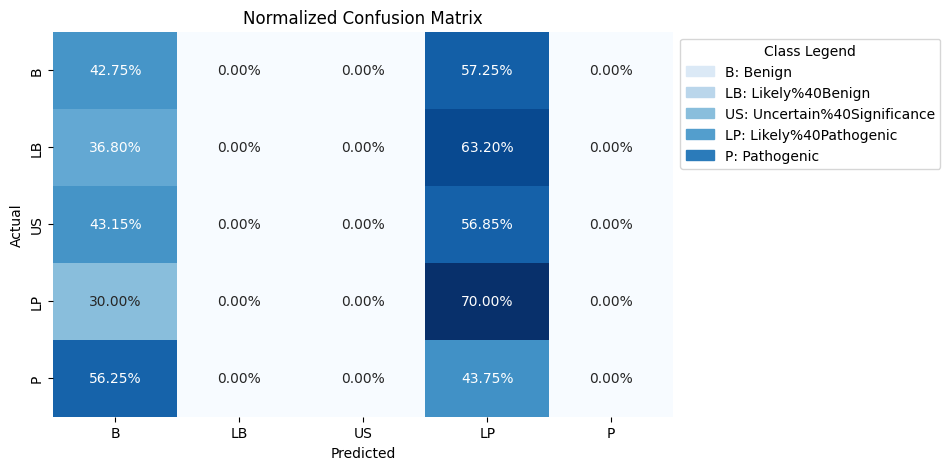

Classification report for CatBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.99      0.95      0.96     90705
           1       0.17      0.69      0.27      2671
           2       0.65      0.31      0.42      9105
           3       0.24      0.40      0.30        20
           4       0.67      0.25      0.36        16

    accuracy                           0.88    102517
   macro avg       0.54      0.52      0.46    102517
weighted avg       0.93      0.88      0.90    102517



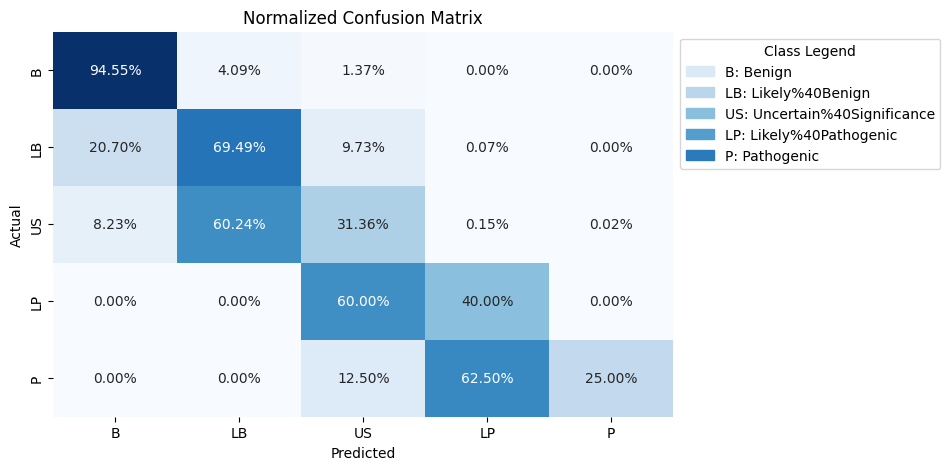

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [14:10:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     90705
           1       0.18      0.43      0.26      2671
           2       0.89      0.26      0.40      9105
           3       0.38      0.30      0.33        20
           4       1.00      0.25      0.40        16

    accuracy                           0.92    102517
   macro avg       0.68      0.45      0.47    102517
weighted avg       0.94      0.92      0.91    102517



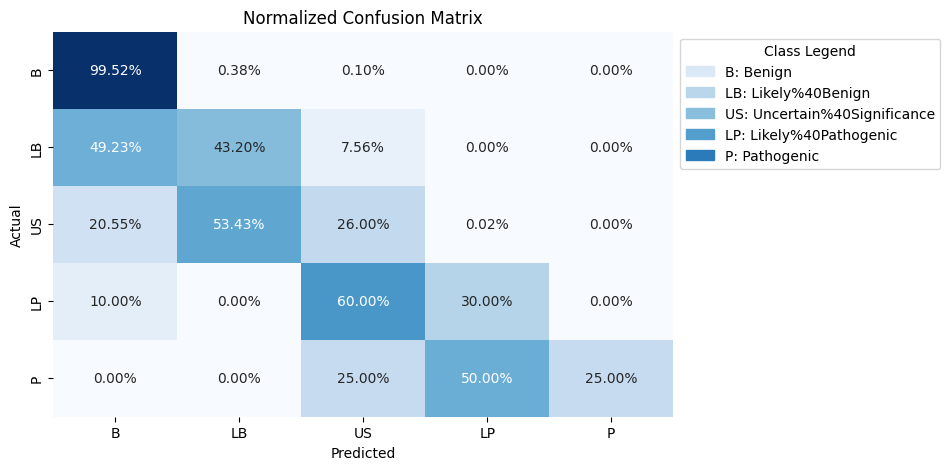

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8808
[LightGBM] [Info] Number of data points in the train set: 307734, number of used features: 169
[LightGBM] [Info] Start training from score -1.610776
[LightGBM] [Info] Start training from score -1.610759
[LightGBM] [Info] Start training from score -1.610765
[LightGBM] [Info] Start training from score -1.617204
[LightGBM] [Info] Start training from score -1.597786
Classification report for LightGBM with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     90705
           1       0.16      0.70      0.26      2671
           2       0.66      0.28      0.39      9105
           3       0.24      0.35      0.29    

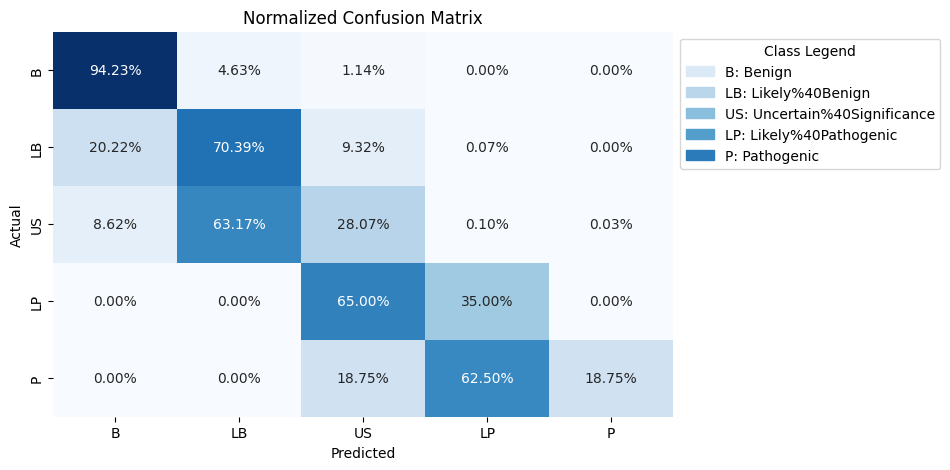

Classification report for Random Forest with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     90705
           1       0.20      0.40      0.26      2671
           2       0.93      0.28      0.43      9105
           3       0.50      0.25      0.33        20
           4       1.00      0.12      0.22        16

    accuracy                           0.92    102517
   macro avg       0.72      0.41      0.44    102517
weighted avg       0.94      0.92      0.91    102517



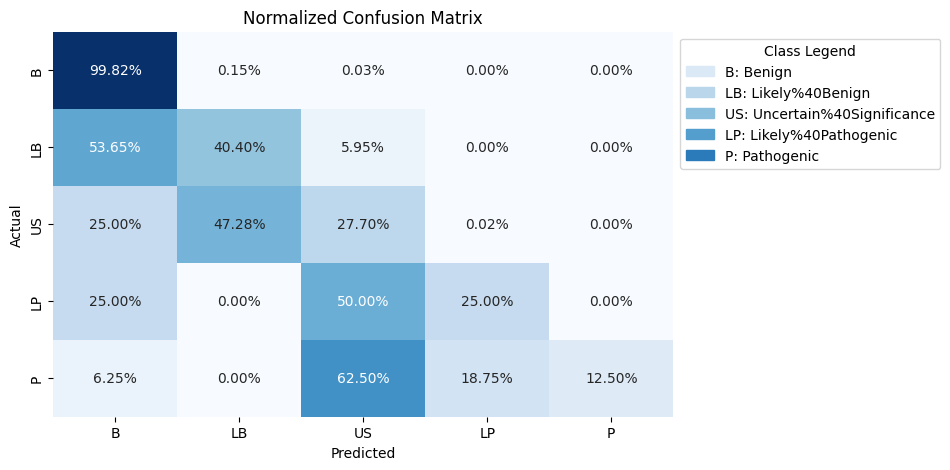

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     90705
           1       0.04      0.56      0.07      2671
           2       0.45      0.40      0.43      9105
           3       0.02      0.60      0.04        20
           4       0.28      0.31      0.29        16

    accuracy                           0.58    102517
   macro avg       0.35      0.49      0.31    102517
weighted avg       0.89      0.58      0.69    102517



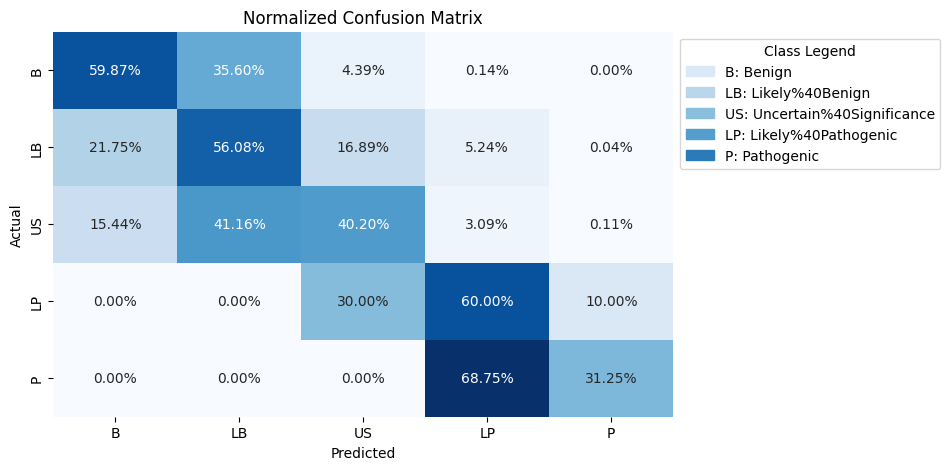

Classification report for Bagging with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     90705
           1       0.17      0.40      0.24      2671
           2       0.88      0.25      0.39      9105
           3       0.23      0.15      0.18        20
           4       1.00      0.12      0.22        16

    accuracy                           0.91    102517
   macro avg       0.65      0.38      0.40    102517
weighted avg       0.94      0.91      0.91    102517



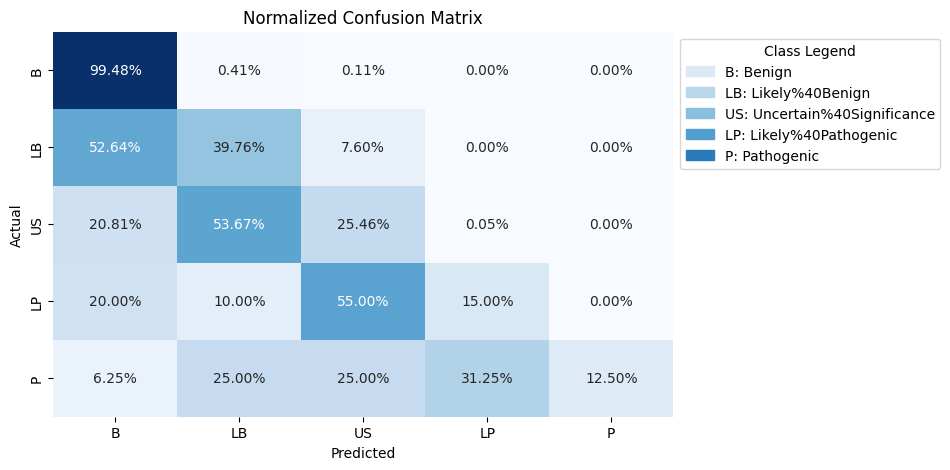

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     90705
           1       0.16      0.44      0.23      2671
           2       0.65      0.30      0.41      9105
           3       0.23      0.25      0.24        20
           4       0.12      0.06      0.08        16

    accuracy                           0.90    102517
   macro avg       0.43      0.40      0.39    102517
weighted avg       0.92      0.90      0.90    102517



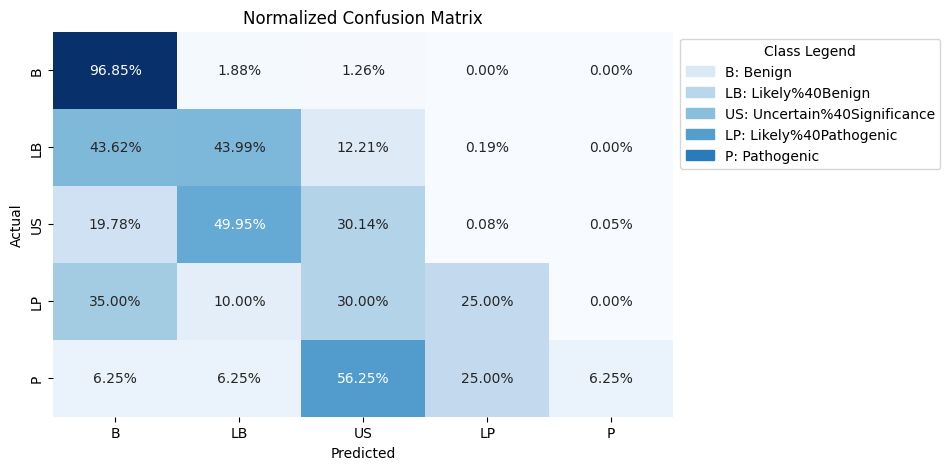

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     90705
           1       0.11      0.26      0.15      2671
           2       0.86      0.00      0.01      9105
           3       0.02      0.75      0.05        20
           4       0.00      0.00      0.00        16

    accuracy                           0.88    102517
   macro avg       0.39      0.40      0.23    102517
weighted avg       0.91      0.88      0.86    102517



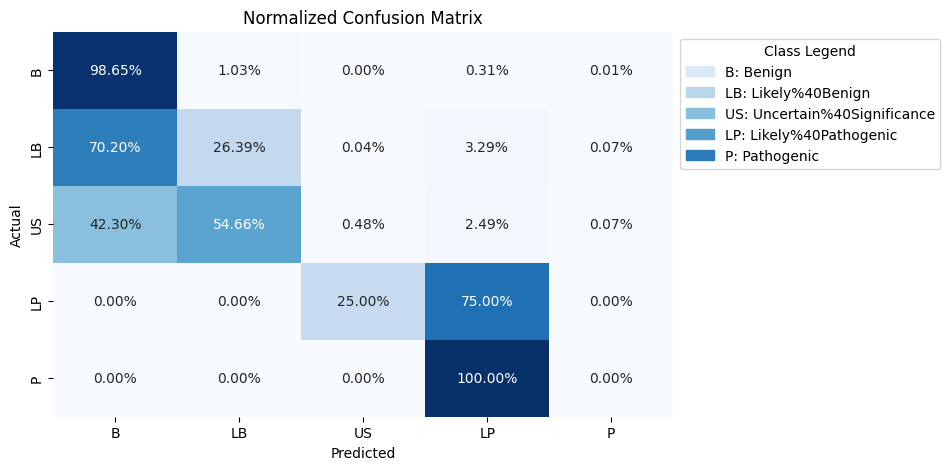

Classification report for CatBoost with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     90705
           1       0.17      0.70      0.27      2671
           2       0.65      0.31      0.42      9105
           3       0.24      0.35      0.29        20
           4       0.67      0.38      0.48        16

    accuracy                           0.88    102517
   macro avg       0.54      0.54      0.48    102517
weighted avg       0.93      0.88      0.90    102517



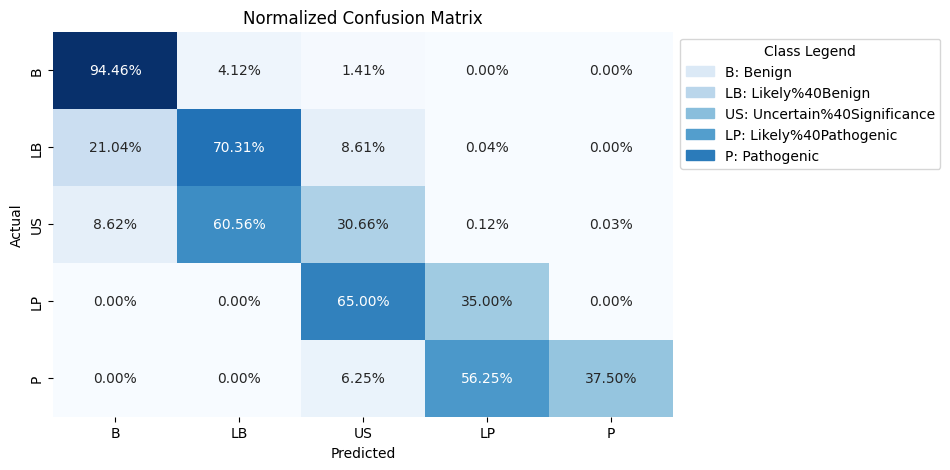

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [14:24:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     90705
           1       0.18      0.42      0.25      2671
           2       0.88      0.26      0.40      9105
           3       0.25      0.25      0.25        20
           4       0.75      0.19      0.30        16

    accuracy                           0.91    102517
   macro avg       0.61      0.42      0.44    102517
weighted avg       0.94      0.91      0.91    102517



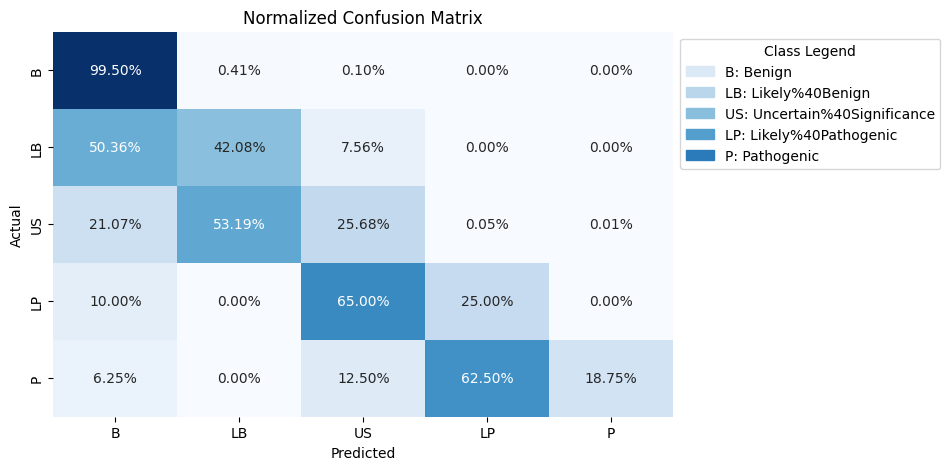

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8727
[LightGBM] [Info] Number of data points in the train set: 307734, number of used features: 165
[LightGBM] [Info] Start training from score -1.610776
[LightGBM] [Info] Start training from score -1.610759
[LightGBM] [Info] Start training from score -1.610765
[LightGBM] [Info] Start training from score -1.617204
[LightGBM] [Info] Start training from score -1.597786
Classification report for LightGBM with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     90705
           1       0.15      0.69      0.25      2671
           2       0.65      0.28      0.39      9105
           3       0.17      0.35      0.23        20


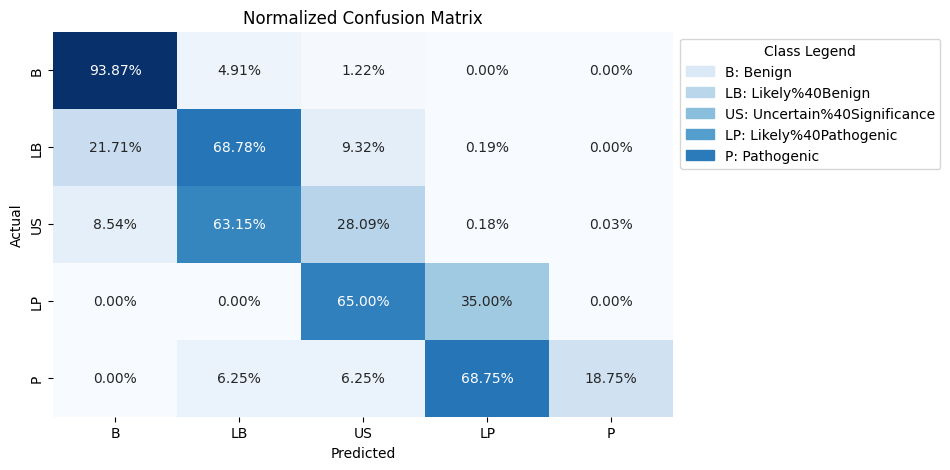

Classification report for Random Forest with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     90705
           1       0.19      0.39      0.25      2671
           2       0.93      0.28      0.43      9105
           3       0.45      0.25      0.32        20
           4       1.00      0.12      0.22        16

    accuracy                           0.92    102517
   macro avg       0.71      0.41      0.44    102517
weighted avg       0.94      0.92      0.91    102517



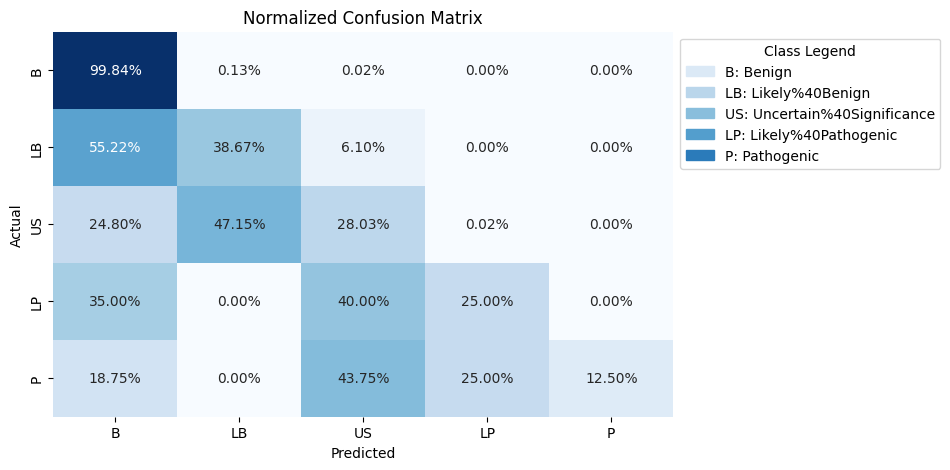

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.28      0.44     90705
           1       0.03      0.68      0.05      2671
           2       0.53      0.34      0.42      9105
           3       0.03      0.85      0.06        20
           4       0.35      0.38      0.36        16

    accuracy                           0.30    102517
   macro avg       0.38      0.51      0.26    102517
weighted avg       0.90      0.30      0.42    102517



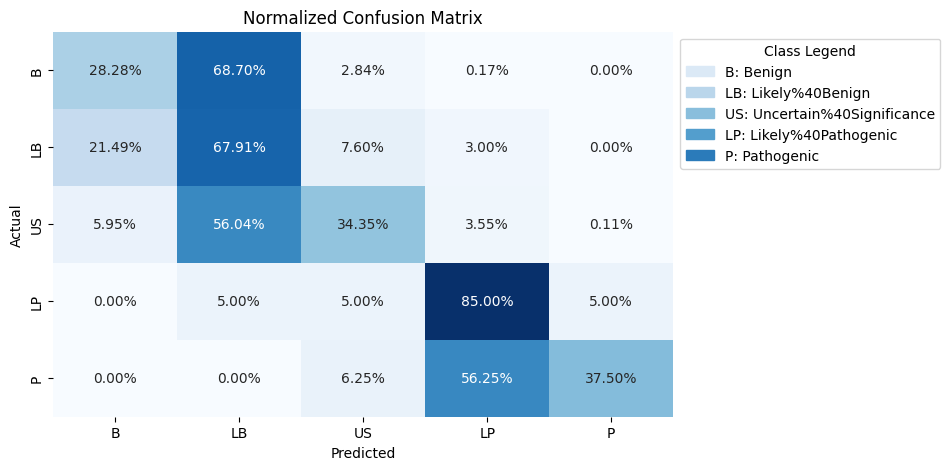

Classification report for Bagging with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     90705
           1       0.17      0.40      0.24      2671
           2       0.89      0.25      0.40      9105
           3       0.31      0.25      0.28        20
           4       0.50      0.12      0.20        16

    accuracy                           0.91    102517
   macro avg       0.57      0.40      0.42    102517
weighted avg       0.94      0.91      0.91    102517



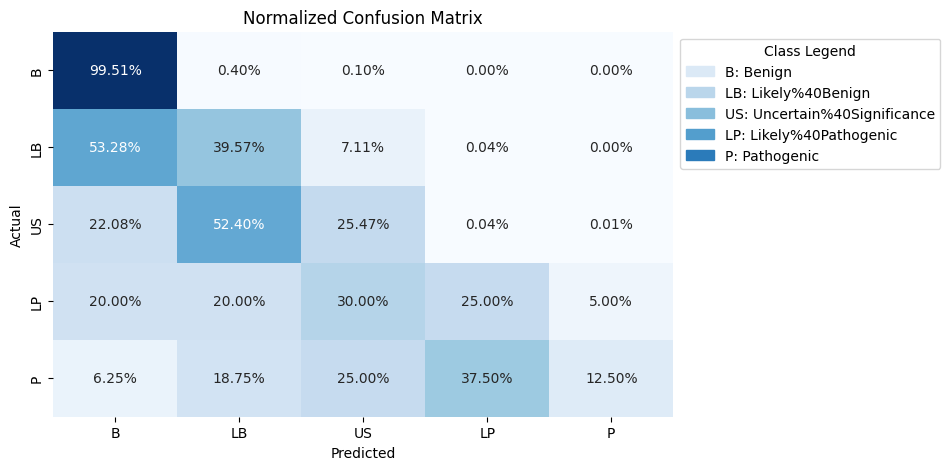

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     90705
           1       0.15      0.41      0.22      2671
           2       0.66      0.30      0.41      9105
           3       0.19      0.25      0.21        20
           4       0.14      0.06      0.09        16

    accuracy                           0.89    102517
   macro avg       0.42      0.40      0.38    102517
weighted avg       0.92      0.89      0.90    102517



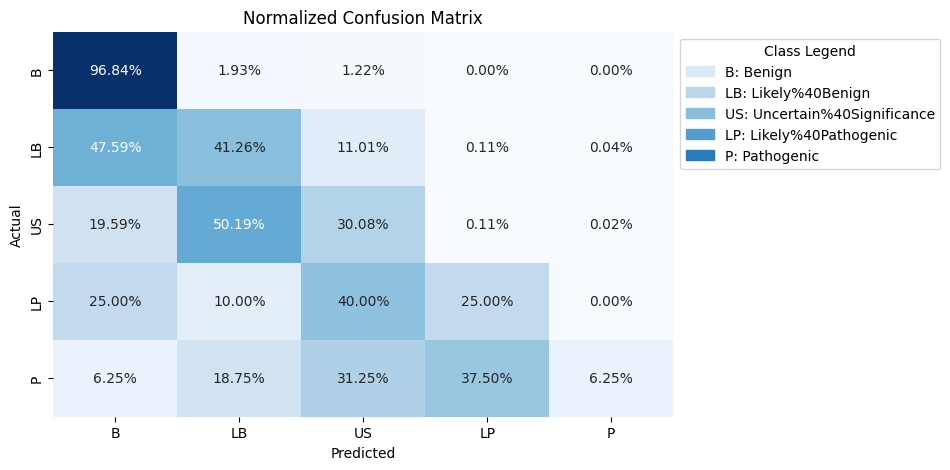

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.72      0.83     90705
           1       0.07      0.89      0.13      2671
           2       0.52      0.05      0.09      9105
           3       0.05      0.65      0.09        20
           4       0.14      0.50      0.22        16

    accuracy                           0.66    102517
   macro avg       0.35      0.56      0.27    102517
weighted avg       0.92      0.66      0.75    102517



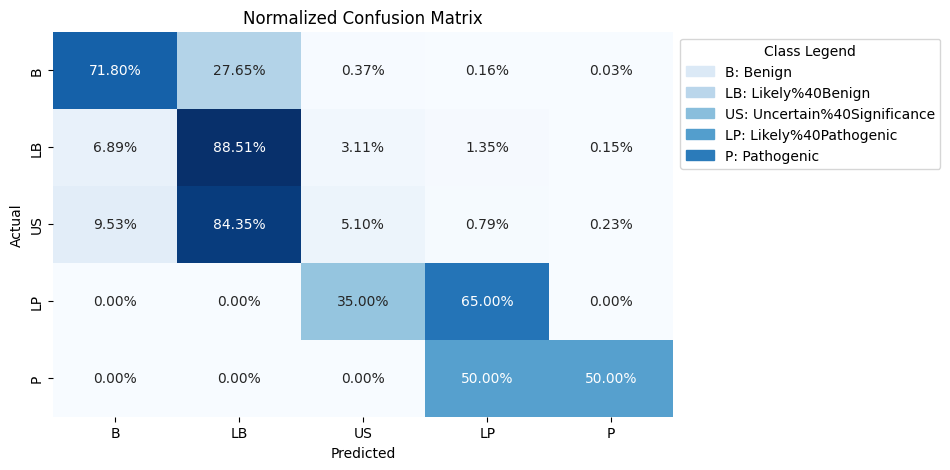

Classification report for CatBoost with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     90705
           1       0.19      0.68      0.30      2671
           2       0.61      0.37      0.46      9105
           3       0.24      0.35      0.29        20
           4       0.60      0.19      0.29        16

    accuracy                           0.89    102517
   macro avg       0.53      0.51      0.46    102517
weighted avg       0.93      0.89      0.90    102517



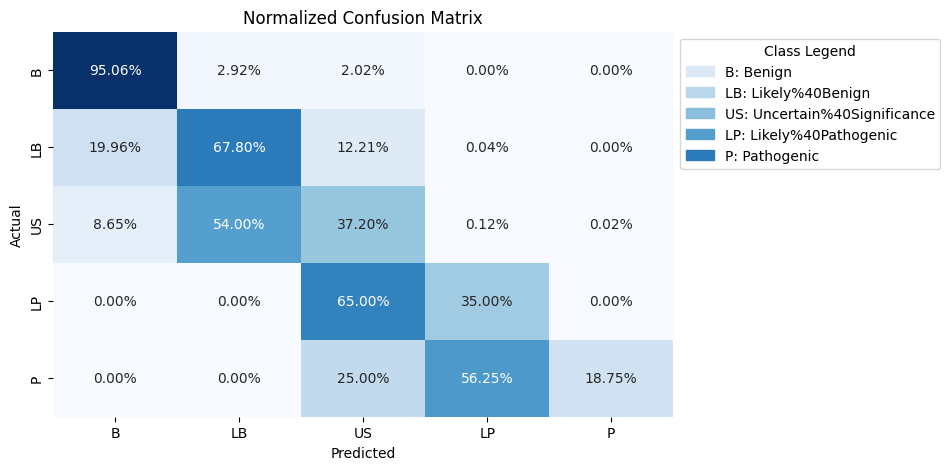

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [14:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     90705
           1       0.18      0.43      0.26      2671
           2       0.89      0.26      0.40      9105
           3       0.31      0.25      0.28        20
           4       1.00      0.25      0.40        16

    accuracy                           0.92    102517
   macro avg       0.67      0.44      0.46    102517
weighted avg       0.94      0.92      0.91    102517



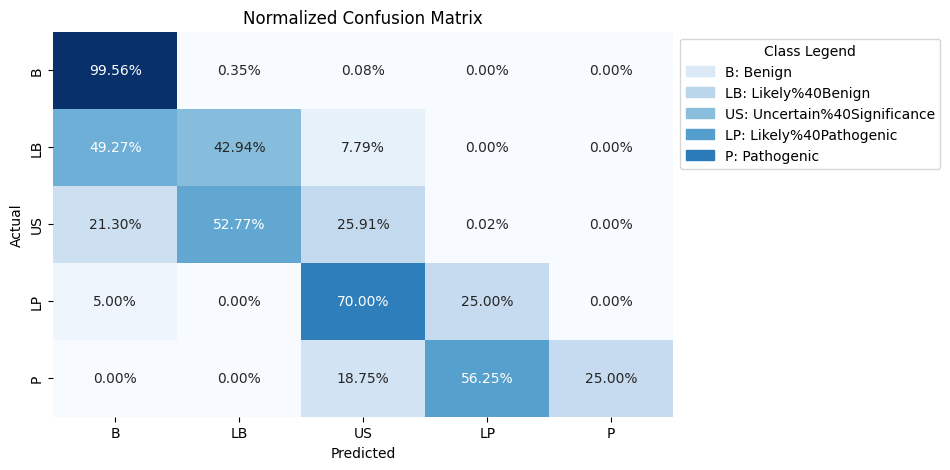

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8680
[LightGBM] [Info] Number of data points in the train set: 307734, number of used features: 105
[LightGBM] [Info] Start training from score -1.610776
[LightGBM] [Info] Start training from score -1.610759
[LightGBM] [Info] Start training from score -1.610765
[LightGBM] [Info] Start training from score -1.617204
[LightGBM] [Info] Start training from score -1.597786
Classification report for LightGBM with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     90705
           1       0.16      0.70      0.26      2671
           2       0.67      0.28      0.40      9105
           3       0.21      0.25      0.23        20
      

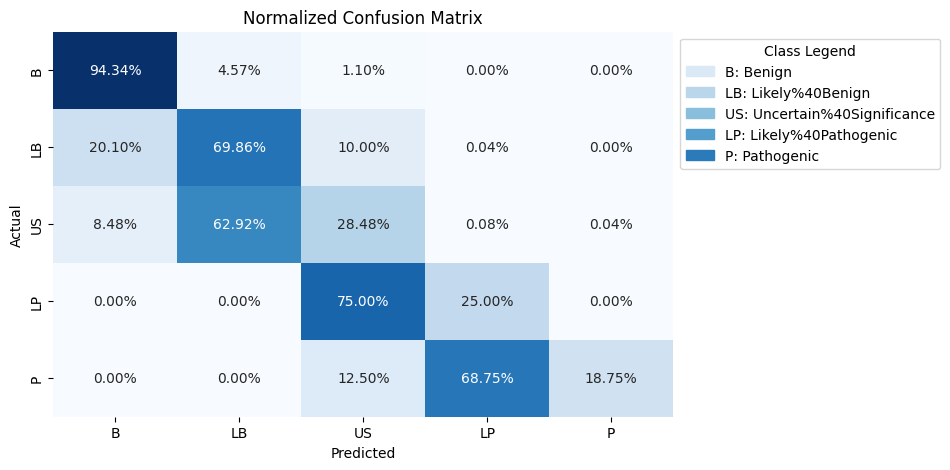

Classification report for Random Forest with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     90705
           1       0.20      0.42      0.27      2671
           2       0.93      0.28      0.44      9105
           3       0.45      0.25      0.32        20
           4       1.00      0.12      0.22        16

    accuracy                           0.92    102517
   macro avg       0.71      0.42      0.45    102517
weighted avg       0.94      0.92      0.91    102517



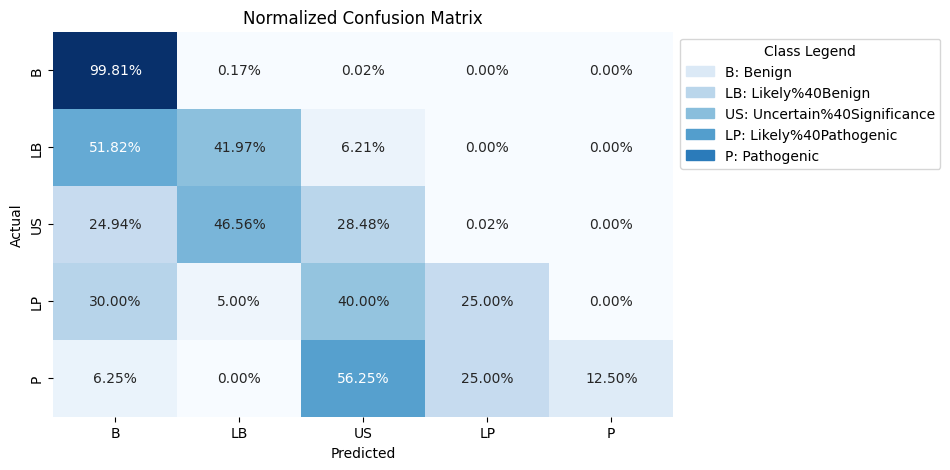

Classification report for AdaBoost with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     90705
           1       0.04      0.56      0.07      2671
           2       0.45      0.40      0.43      9105
           3       0.02      0.60      0.04        20
           4       0.28      0.31      0.29        16

    accuracy                           0.58    102517
   macro avg       0.35      0.49      0.31    102517
weighted avg       0.89      0.58      0.69    102517



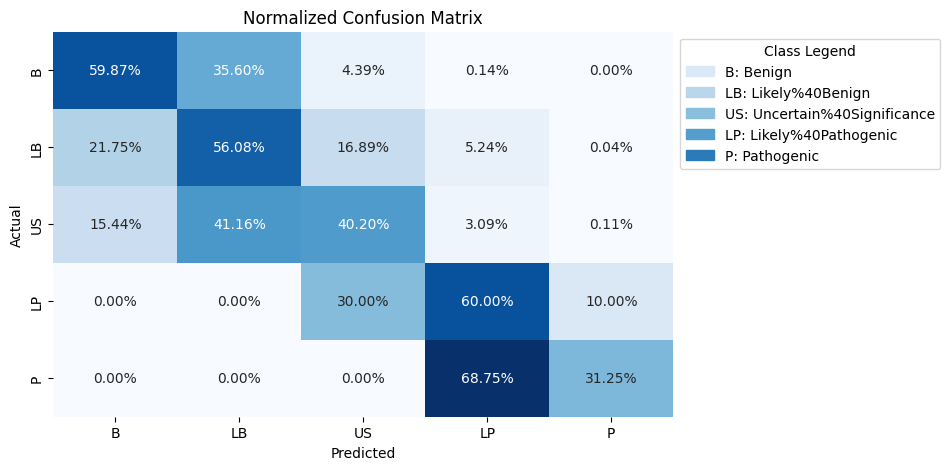

Classification report for Bagging with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     90705
           1       0.17      0.39      0.24      2671
           2       0.88      0.25      0.39      9105
           3       0.31      0.20      0.24        20
           4       0.50      0.06      0.11        16

    accuracy                           0.91    102517
   macro avg       0.56      0.38      0.39    102517
weighted avg       0.94      0.91      0.91    102517



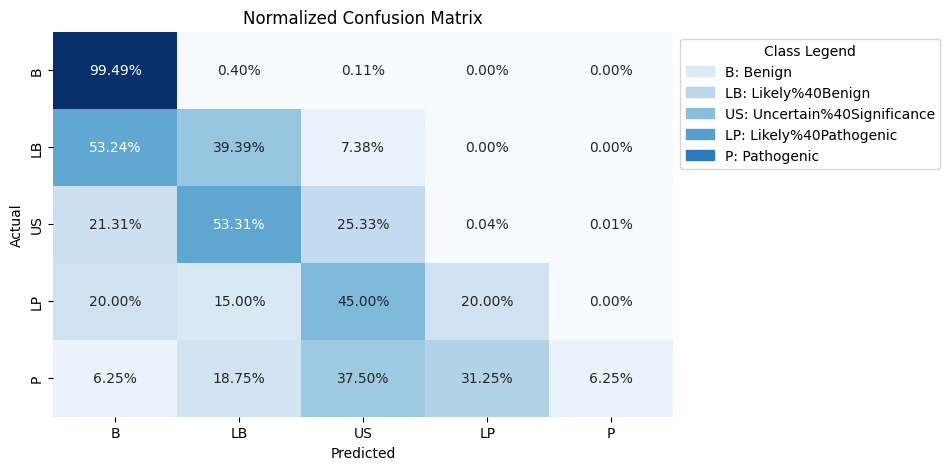

Classification report for Decision Tree with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     90705
           1       0.16      0.43      0.23      2671
           2       0.65      0.30      0.41      9105
           3       0.23      0.25      0.24        20
           4       0.12      0.06      0.08        16

    accuracy                           0.90    102517
   macro avg       0.43      0.40      0.39    102517
weighted avg       0.92      0.90      0.90    102517



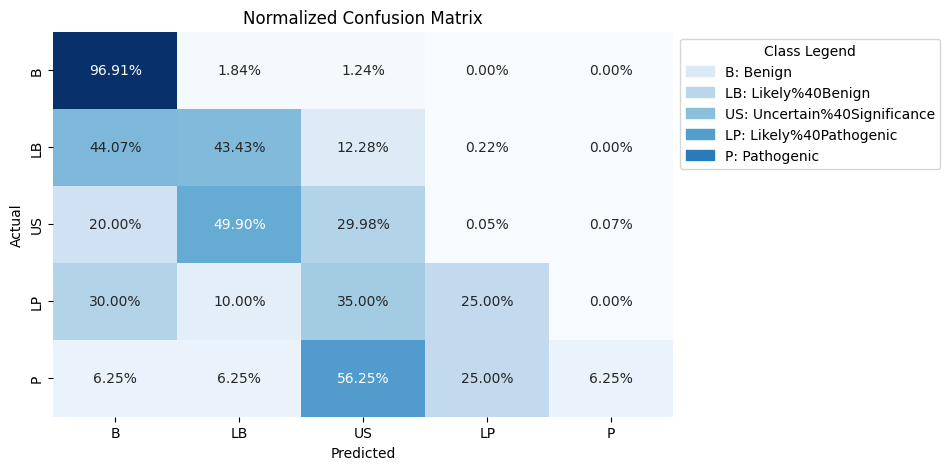

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     90705
           1       0.11      0.35      0.17      2671
           2       1.00      0.00      0.00      9105
           3       0.02      0.80      0.04        20
           4       0.00      0.00      0.00        16

    accuracy                           0.87    102517
   macro avg       0.42      0.42      0.23    102517
weighted avg       0.93      0.87      0.85    102517



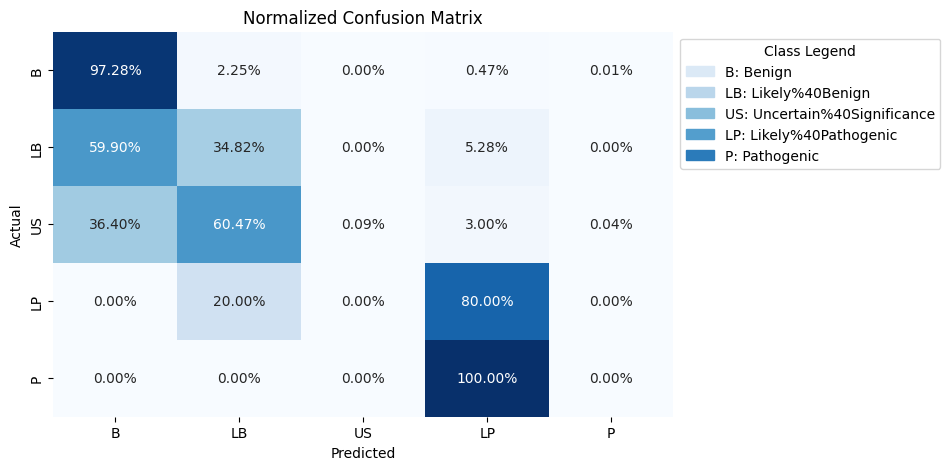

Classification report for CatBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     90705
           1       0.18      0.70      0.28      2671
           2       0.65      0.31      0.42      9105
           3       0.27      0.45      0.34        20
           4       0.83      0.31      0.45        16

    accuracy                           0.89    102517
   macro avg       0.58      0.54      0.49    102517
weighted avg       0.93      0.89      0.90    102517



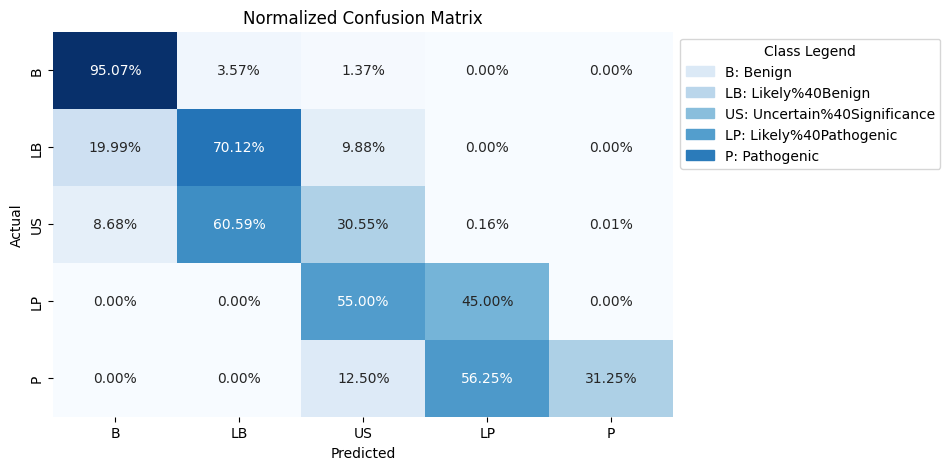

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [14:51:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     90705
           1       0.18      0.43      0.26      2671
           2       0.88      0.26      0.40      9105
           3       0.26      0.25      0.26        20
           4       1.00      0.12      0.22        16

    accuracy                           0.91    102517
   macro avg       0.66      0.41      0.42    102517
weighted avg       0.94      0.91      0.91    102517



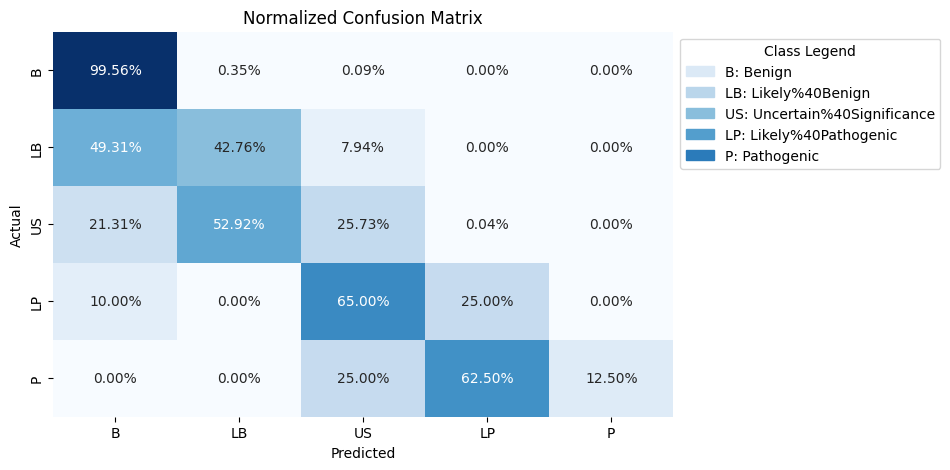

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8956
[LightGBM] [Info] Number of data points in the train set: 307734, number of used features: 169
[LightGBM] [Info] Start training from score -1.610776
[LightGBM] [Info] Start training from score -1.610759
[LightGBM] [Info] Start training from score -1.610765
[LightGBM] [Info] Start training from score -1.617204
[LightGBM] [Info] Start training from score -1.597786
Classification report for LightGBM with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     90705
           1       0.16      0.72      0.27      2671
           2       0.67      0.28      0.40      9105
           3       0.19      0.30      0.23    

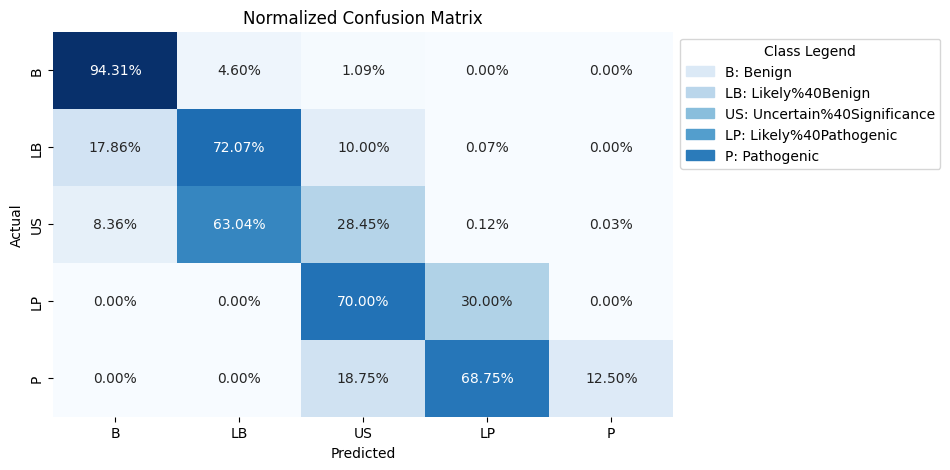

Classification report for Random Forest with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     90705
           1       0.20      0.40      0.27      2671
           2       0.93      0.29      0.44      9105
           3       0.50      0.25      0.33        20
           4       1.00      0.06      0.12        16

    accuracy                           0.92    102517
   macro avg       0.72      0.40      0.43    102517
weighted avg       0.94      0.92      0.91    102517



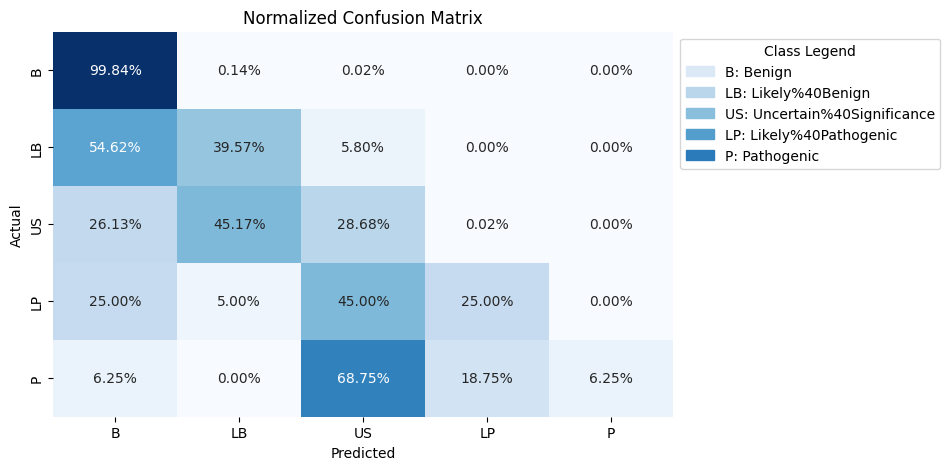

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     90705
           1       0.04      0.56      0.07      2671
           2       0.45      0.40      0.43      9105
           3       0.02      0.60      0.04        20
           4       0.28      0.31      0.29        16

    accuracy                           0.58    102517
   macro avg       0.35      0.49      0.31    102517
weighted avg       0.89      0.58      0.69    102517



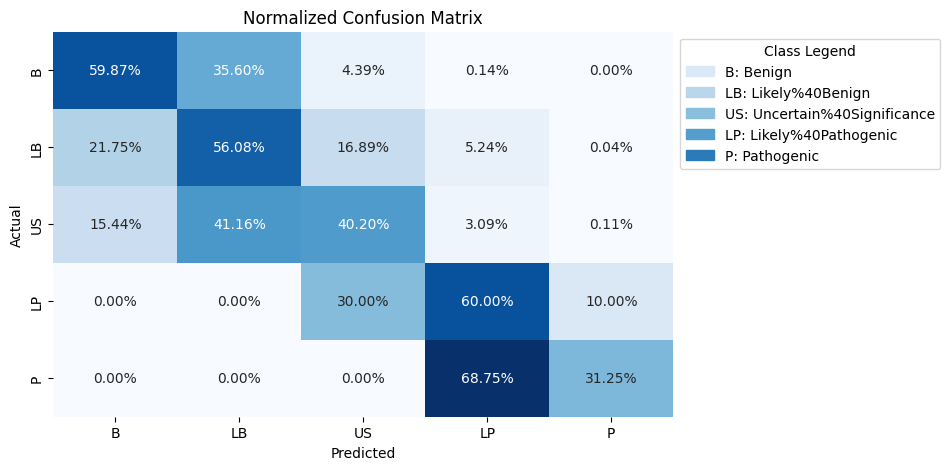

Classification report for Bagging with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     90705
           1       0.17      0.39      0.23      2671
           2       0.87      0.25      0.39      9105
           3       0.25      0.20      0.22        20
           4       0.50      0.06      0.11        16

    accuracy                           0.91    102517
   macro avg       0.55      0.38      0.39    102517
weighted avg       0.93      0.91      0.91    102517



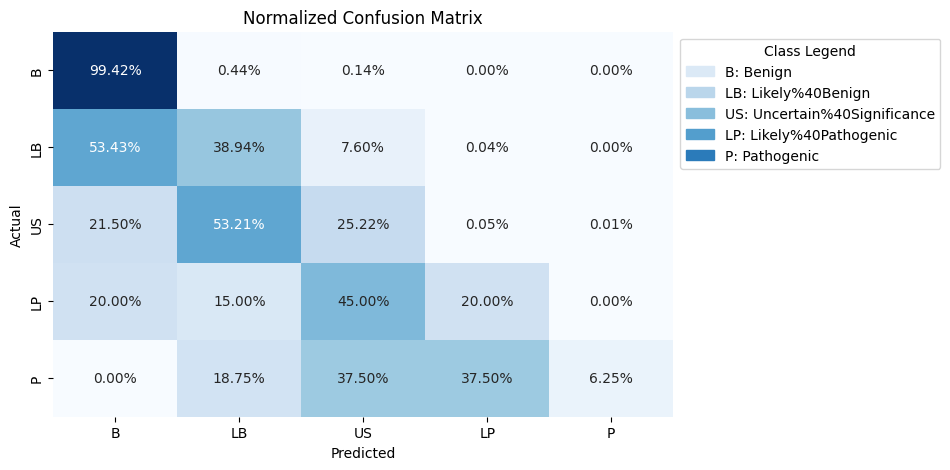

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     90705
           1       0.15      0.44      0.23      2671
           2       0.65      0.30      0.41      9105
           3       0.24      0.25      0.24        20
           4       0.12      0.06      0.08        16

    accuracy                           0.89    102517
   macro avg       0.43      0.40      0.39    102517
weighted avg       0.92      0.89      0.90    102517



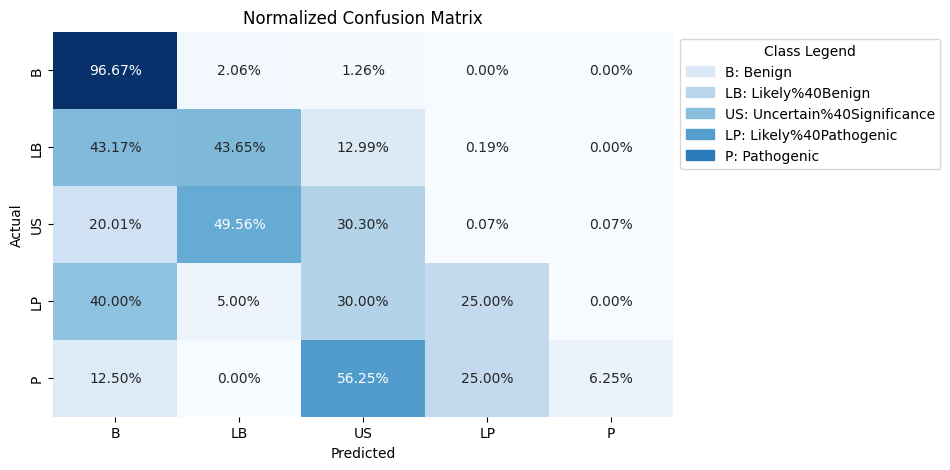

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.72      0.83     90705
           1       0.03      0.27      0.05      2671
           2       0.37      0.19      0.25      9105
           3       0.00      0.60      0.01        20
           4       0.00      0.19      0.00        16

    accuracy                           0.66    102517
   macro avg       0.28      0.39      0.23    102517
weighted avg       0.90      0.66      0.75    102517



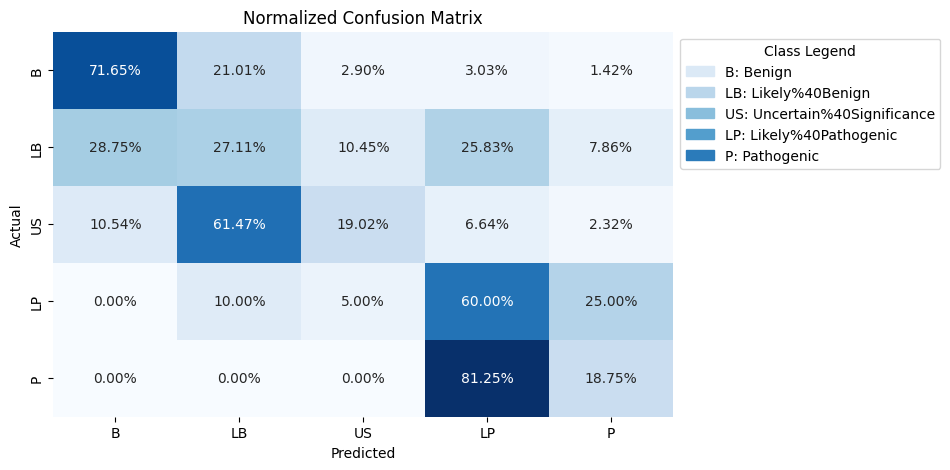

Classification report for CatBoost with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     90705
           1       0.17      0.70      0.27      2671
           2       0.65      0.31      0.42      9105
           3       0.26      0.45      0.33        20
           4       0.50      0.31      0.38        16

    accuracy                           0.88    102517
   macro avg       0.51      0.54      0.47    102517
weighted avg       0.93      0.88      0.90    102517



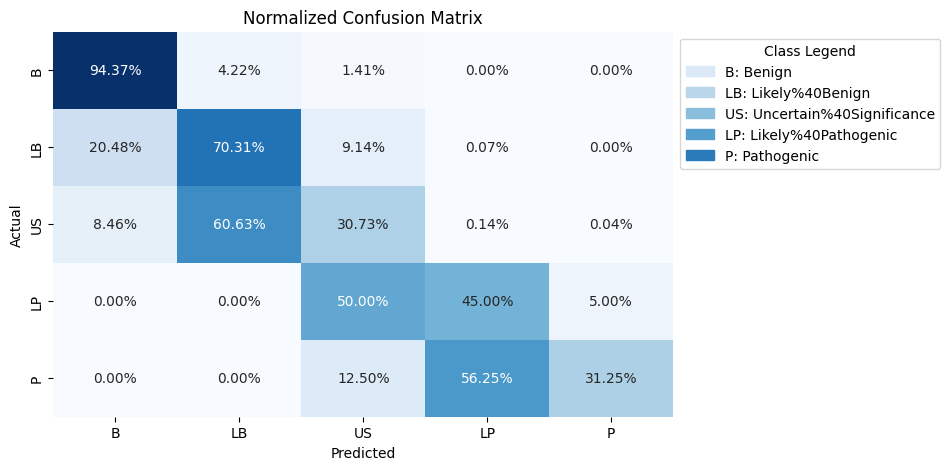

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [15:10:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     90705
           1       0.18      0.43      0.25      2671
           2       0.89      0.26      0.40      9105
           3       0.32      0.30      0.31        20
           4       0.83      0.31      0.45        16

    accuracy                           0.91    102517
   macro avg       0.64      0.46      0.48    102517
weighted avg       0.94      0.91      0.91    102517



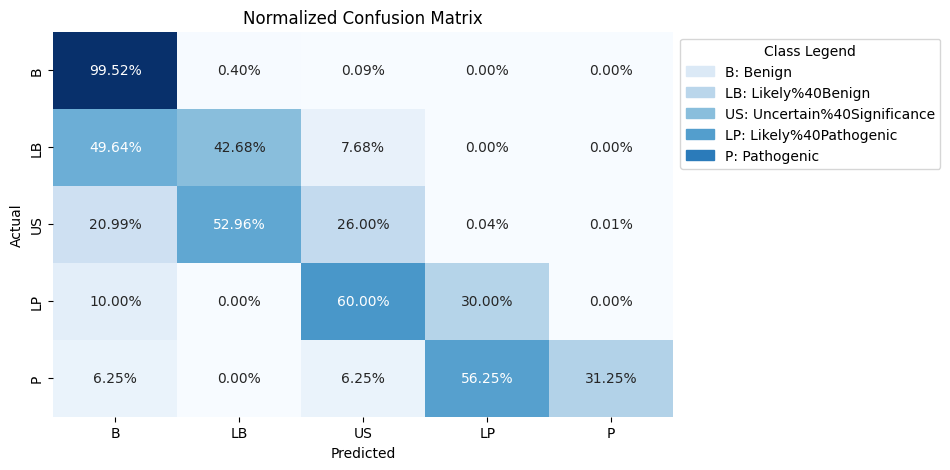

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8936
[LightGBM] [Info] Number of data points in the train set: 307734, number of used features: 165
[LightGBM] [Info] Start training from score -1.610776
[LightGBM] [Info] Start training from score -1.610759
[LightGBM] [Info] Start training from score -1.610765
[LightGBM] [Info] Start training from score -1.617204
[LightGBM] [Info] Start training from score -1.597786
Classification report for LightGBM with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     90705
           1       0.15      0.68      0.25      2671
           2       0.65      0.28      0.39      9105
           3       0.17      0.30      0.21        20


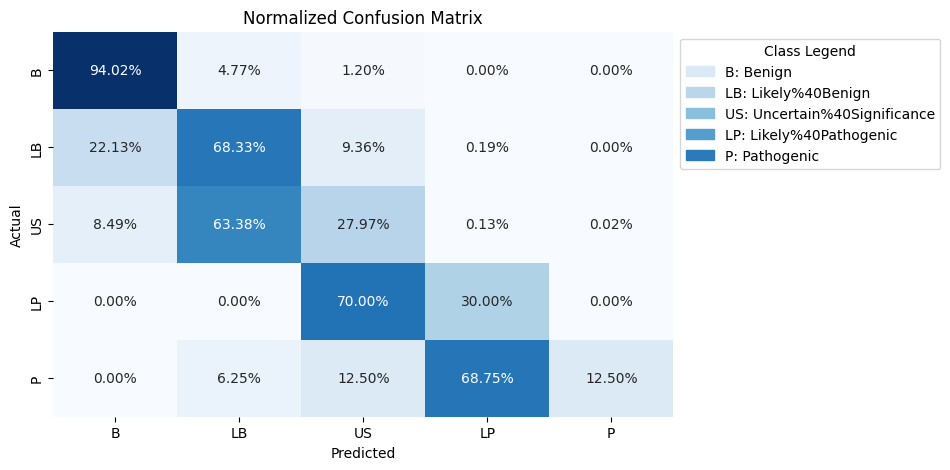

Classification report for Random Forest with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     90705
           1       0.19      0.37      0.25      2671
           2       0.93      0.29      0.44      9105
           3       0.42      0.25      0.31        20
           4       1.00      0.12      0.22        16

    accuracy                           0.92    102517
   macro avg       0.70      0.41      0.44    102517
weighted avg       0.94      0.92      0.91    102517



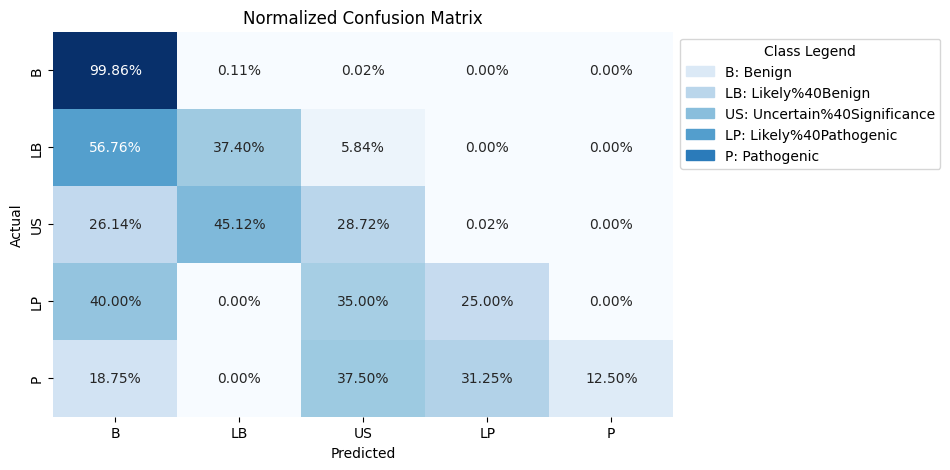

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.32      0.48     90705
           1       0.03      0.66      0.05      2671
           2       0.19      0.18      0.19      9105
           3       0.03      0.65      0.05        20
           4       0.27      0.25      0.26        16

    accuracy                           0.32    102517
   macro avg       0.30      0.41      0.21    102517
weighted avg       0.87      0.32      0.44    102517



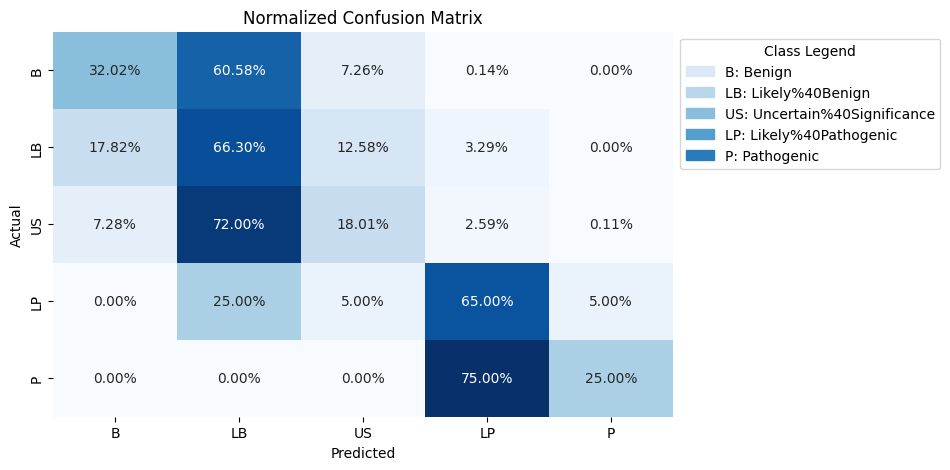

Classification report for Bagging with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     90705
           1       0.18      0.41      0.25      2671
           2       0.88      0.25      0.39      9105
           3       0.31      0.25      0.28        20
           4       1.00      0.06      0.12        16

    accuracy                           0.91    102517
   macro avg       0.67      0.39      0.40    102517
weighted avg       0.94      0.91      0.91    102517



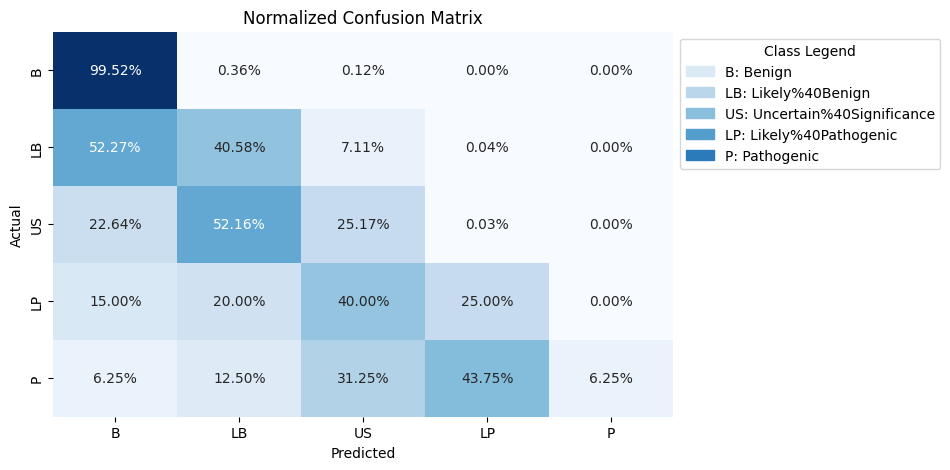

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     90705
           1       0.14      0.40      0.21      2671
           2       0.63      0.30      0.41      9105
           3       0.06      0.10      0.07        20
           4       0.12      0.06      0.08        16

    accuracy                           0.89    102517
   macro avg       0.39      0.37      0.35    102517
weighted avg       0.91      0.89      0.90    102517



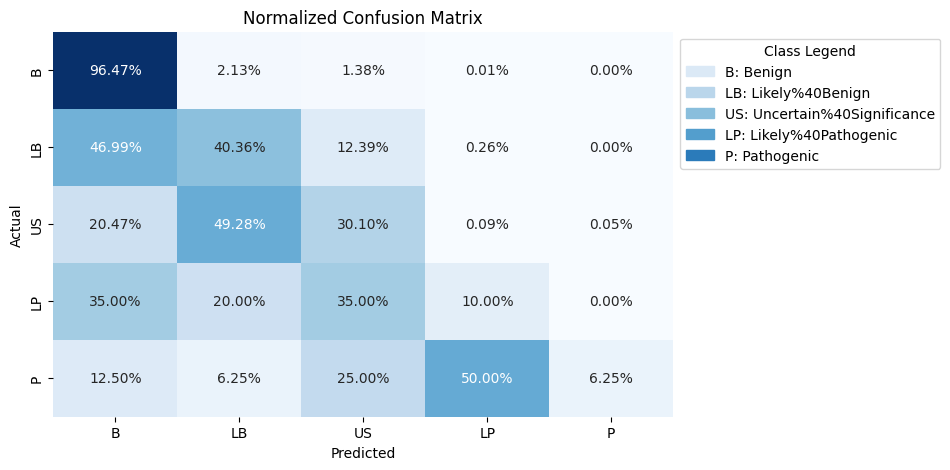

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.99      0.38      0.55     90705
           1       0.03      0.15      0.06      2671
           2       0.15      0.65      0.24      9105
           3       0.00      0.70      0.00        20
           4       0.00      0.31      0.00        16

    accuracy                           0.40    102517
   macro avg       0.23      0.44      0.17    102517
weighted avg       0.89      0.40      0.51    102517



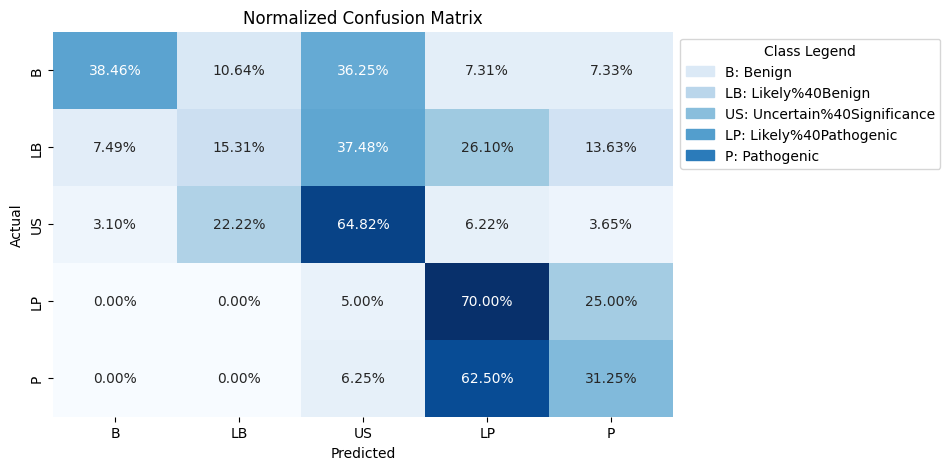

Classification report for CatBoost with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     90705
           1       0.19      0.67      0.30      2671
           2       0.63      0.37      0.46      9105
           3       0.22      0.35      0.27        20
           4       0.67      0.25      0.36        16

    accuracy                           0.89    102517
   macro avg       0.54      0.52      0.47    102517
weighted avg       0.93      0.89      0.91    102517



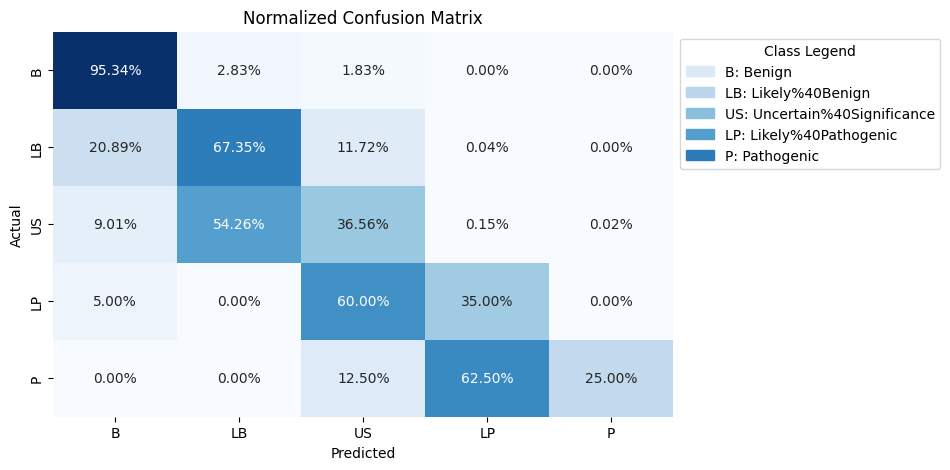

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [15:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     90705
           1       0.18      0.42      0.25      2671
           2       0.89      0.26      0.40      9105
           3       0.28      0.25      0.26        20
           4       1.00      0.25      0.40        16

    accuracy                           0.92    102517
   macro avg       0.66      0.44      0.46    102517
weighted avg       0.94      0.92      0.91    102517



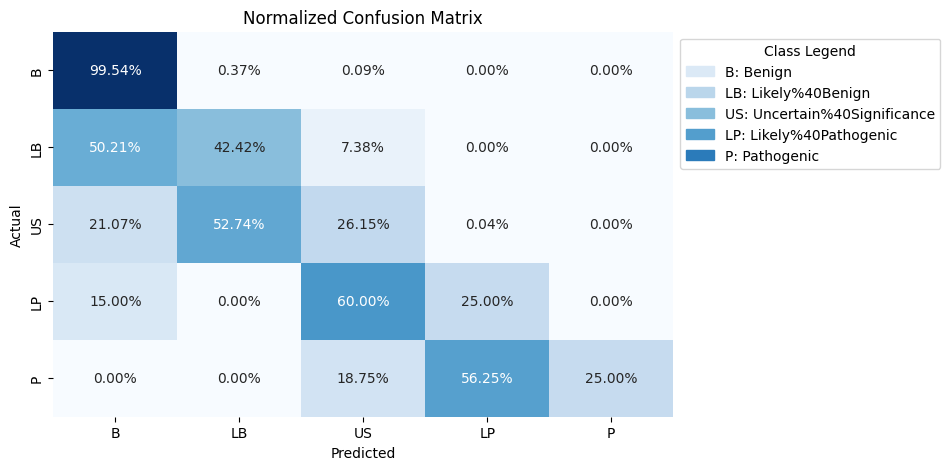

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8828
[LightGBM] [Info] Number of data points in the train set: 307734, number of used features: 105
[LightGBM] [Info] Start training from score -1.610776
[LightGBM] [Info] Start training from score -1.610759
[LightGBM] [Info] Start training from score -1.610765
[LightGBM] [Info] Start training from score -1.617204
[LightGBM] [Info] Start training from score -1.597786
Classification report for LightGBM with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     90705
           1       0.16      0.71      0.26      2671
           2       0.66      0.28      0.40      9105
           3       0.17      0.30      0.22        20
      

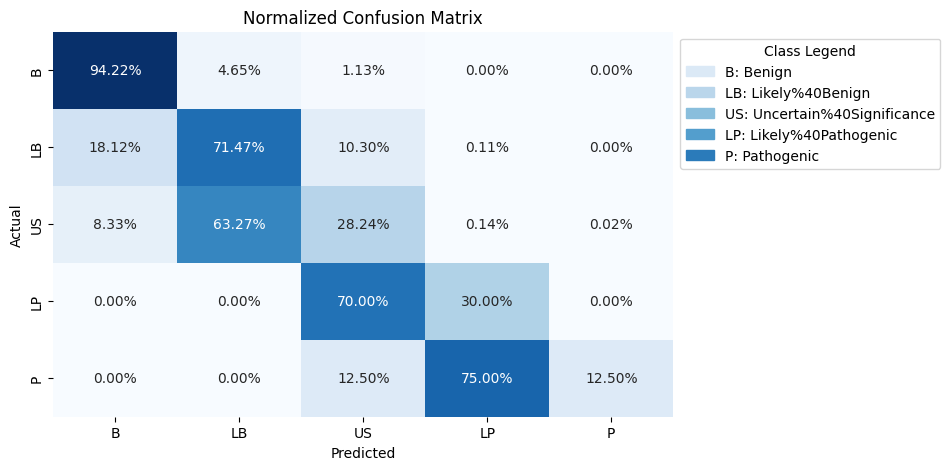

Classification report for Random Forest with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     90705
           1       0.20      0.41      0.26      2671
           2       0.93      0.27      0.42      9105
           3       0.45      0.25      0.32        20
           4       1.00      0.12      0.22        16

    accuracy                           0.92    102517
   macro avg       0.71      0.41      0.44    102517
weighted avg       0.94      0.92      0.91    102517



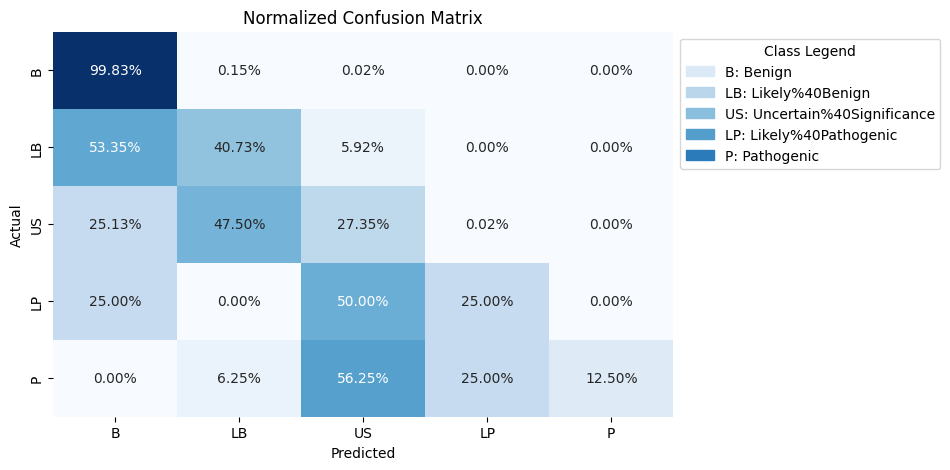

Classification report for AdaBoost with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     90705
           1       0.04      0.56      0.07      2671
           2       0.45      0.40      0.43      9105
           3       0.02      0.60      0.04        20
           4       0.28      0.31      0.29        16

    accuracy                           0.58    102517
   macro avg       0.35      0.49      0.31    102517
weighted avg       0.89      0.58      0.69    102517



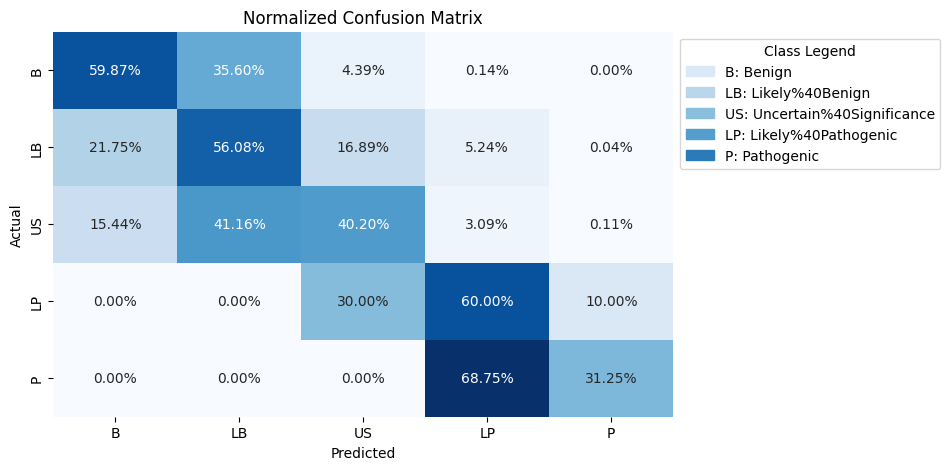

Classification report for Bagging with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     90705
           1       0.17      0.39      0.23      2671
           2       0.87      0.25      0.39      9105
           3       0.27      0.20      0.23        20
           4       0.50      0.06      0.11        16

    accuracy                           0.91    102517
   macro avg       0.55      0.38      0.39    102517
weighted avg       0.93      0.91      0.91    102517



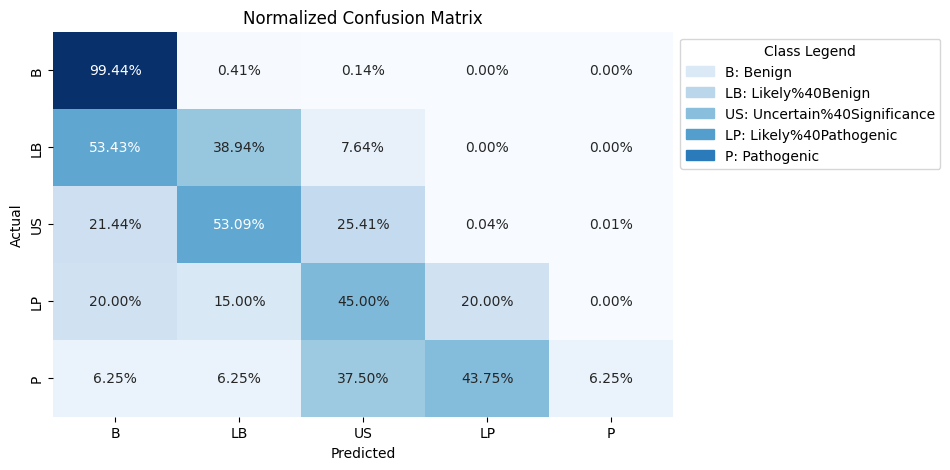

Classification report for Decision Tree with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     90705
           1       0.16      0.44      0.23      2671
           2       0.63      0.30      0.41      9105
           3       0.24      0.25      0.24        20
           4       0.12      0.06      0.08        16

    accuracy                           0.89    102517
   macro avg       0.42      0.40      0.39    102517
weighted avg       0.92      0.89      0.90    102517



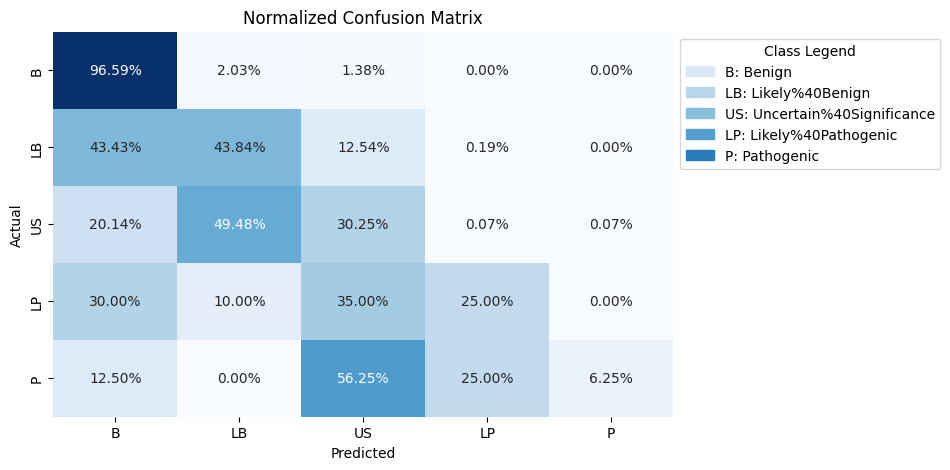

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.98      0.71      0.82     90705
           1       0.03      0.17      0.05      2671
           2       0.26      0.48      0.34      9105
           3       0.00      0.65      0.01        20
           4       0.00      0.19      0.00        16

    accuracy                           0.67    102517
   macro avg       0.25      0.44      0.24    102517
weighted avg       0.89      0.67      0.76    102517



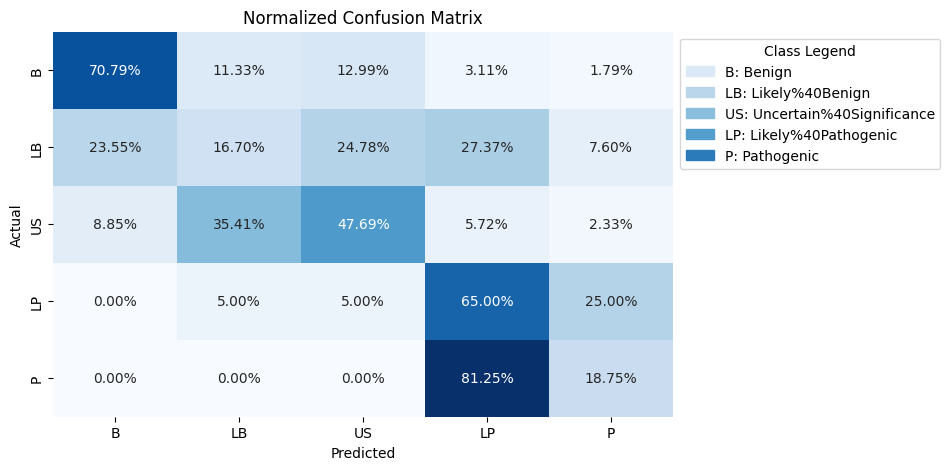

In [27]:
preprocessings = [
    ("None", None),
    ("MinMax", MinMaxScaler()),
    ("Robust", RobustScaler())
]

datasets = [
    ("Encoded - OneHot Nans, Outside Range", encoded_df1),
    ("Encoded - OneHot Nans, Median", encoded_df2),
    ("Encoded - Outside Range", encoded_df3)
]

for preprocessing_name, preprocessing_method in preprocessings:
    for dataset_name, dataset in datasets:
        test_patient = dataset[dataset['patient'] == 0].copy()
        test_patient = test_patient.sample(frac=1, random_state=42).reset_index(drop=True)
        temp_df = dataset[dataset['patient'] != 0]

        X_test = test_patient.drop(columns=["patient", target_column])
        y_test = test_patient[target_column]

        X = temp_df.drop(columns = ["patient", target_column])
        y = temp_df[target_column]
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
        if preprocessing_name != "None":
            X_train = pd.DataFrame(preprocessing_method.fit_transform(X_train), columns=X.columns)
            X_val = pd.DataFrame(preprocessing_method.transform(X_val), columns=X.columns)
            X_test = pd.DataFrame(preprocessing_method.transform(X_test), columns=X.columns)
        model_seed = 42

        class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y) 
        models = [
            ('CatBoost', CatBoostClassifier(class_weights=class_weights, verbose=False, random_state=model_seed)),
            ('XGBoost', XGBClassifier(scale_pos_weight=sum(y_train==0)/sum(y_train==1), random_state=model_seed)),
            ('LightGBM', LGBMClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('Random Forest', RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('AdaBoost', AdaBoostClassifier(random_state=model_seed)),
            ('Bagging', BaggingClassifier(random_state=model_seed)),
            ('Decision Tree', DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
        ]

        for model_name, model in models:
            clf = model

            pipeline = Pipeline([
                ('classifier', clf)
            ])

            if model_name == 'AdaBoost':
                sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
                pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
            else:
                pipeline.fit(X_train, y_train)

            y_pred = pipeline.predict(X_test)
            report = classification_report(y_test, y_pred)
            print(f"Classification report for {model_name} with dataset {dataset_name} and preprocessing {preprocessing_name}:")
            print(report)

            get_confusion_matrix_plot(y_test, y_pred, inverted_mapping)


### Custom Weight Matrix

In [28]:
inverted_mapping

{0: 'Benign',
 1: 'Likely%40Benign',
 2: 'Uncertain%40Significance',
 3: 'Likely%40Pathogenic',
 4: 'Pathogenic'}

In [29]:
cost_matrix = np.array([
    [0, 1, 3, 5, 6], #B
    [1, 0, 3, 5, 6], #LB
    [5, 3, 0, 1, 2], #US
    [10, 7, 5, 0, 1], #LP
    [12, 10, 5, 1, 0]  #P
], dtype = np.float64)

In [30]:
def custom_loss(y_true, y_pred):
    loss = 0
    for i in range(len(y_true)):
        loss += cost_matrix[y_true[i]][y_pred[i]]
    return loss

In [31]:
class_weights = []
for i in range(5):
    count = dataset["ACMG_class"].value_counts().get(i, 0)
    class_weights.append(count)
class_weights = np.array(class_weights, dtype=np.float64)
class_weights -= np.sum(class_weights)
class_weights *= (-1)
class_weights /= np.max(class_weights)
weighted_cost_matrix = cost_matrix * class_weights[:, np.newaxis]
weighted_cost_matrix

array([[ 0.        ,  0.13464403,  0.4039321 ,  0.67322016,  0.80786419],
       [ 0.94215944,  0.        ,  2.82647831,  4.71079718,  5.65295661],
       [ 4.61906551,  2.77143931,  0.        ,  0.9238131 ,  1.84762621],
       [ 9.99833481,  6.99883437,  4.99916741,  0.        ,  0.99983348],
       [12.        , 10.        ,  5.        ,  1.        ,  0.        ]])